# Module & Function

In [1077]:
from ismn.interface import ISMN_Interface
import ismn.interface
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy
import netCDF4 as nc
import glob
from netCDF4 import *
import pandas as pd
import os
from tqdm import tqdm
from glob import *
import warnings
from scipy import stats
from scipy.stats import linregress
from scipy.stats import gaussian_kde
import glob
import calendar
from glob import glob
import glob
import seaborn as sns
import xskillscore as xs
import cartopy.feature as cfeature
import pytz
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.dates as mdates

from datetime import datetime, timezone, timedelta

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import dask.array as da
from dask.diagnostics import ProgressBar

from matplotlib.colors import Normalize
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.colors import TwoSlopeNorm
from matplotlib.lines import Line2D

In [517]:
def LST(data,lon):
    if (-172.5 < lon < -157.5):
        data.index=data.index + np.timedelta64(-11,'h')
    elif (-157.5 < lon < -142.5):
        data.index=data.index + np.timedelta64(-10,'h')
    elif (-142.5 < lon < -127.5):
        data.index=data.index + np.timedelta64(-9,'h')
    elif (-127.5 < lon < -112.5):
        data.index=data.index + np.timedelta64(-8,'h')
    elif (-112.5 < lon < -97.5):
        data.index=data.index + np.timedelta64(-7,'h')
    elif (-97.5 < lon < -87.5):
        data.index=data.index + np.timedelta64(-6,'h')
    elif (-87.5 < lon < -67.5):
        data.index=data.index + np.timedelta64(-5,'h')
    elif (-67.5 < lon < -52.5):
        data.index=data.index + np.timedelta64(-4,'h')
    elif (-52.5 < lon < -37.5):
        data.index=data.index + np.timedelta64(-3,'h')
    elif (-37.5 < lon < -22.5):
        data.index=data.index + np.timedelta64(-2,'h')
    elif (-22.5 < lon < -7.5):
        data.index=data.index + np.timedelta64(-1,'h')
    elif (7.5 < lon < 22.5):
        data.index=data.index + np.timedelta64(1,'h')
    elif (22.5 < lon < 37.5):
        data.index=data.index + np.timedelta64(2,'h')
    elif (37.5 < lon < 52.5):
        data.index=data.index + np.timedelta64(3,'h')
    elif (52.5 < lon < 67.5):
        data.index=data.index + np.timedelta64(4,'h')
    elif (67.5 < lon < 82.5):
        data.index=data.index + np.timedelta64(5,'h')
    elif (82.5 < lon < 97.5):
        data.index=data.index + np.timedelta64(6,'h')
    elif (97.5 < lon < 112.5):
        data.index=data.index + np.timedelta64(7,'h')
    elif (112.5 < lon < 127.5):
        data.index=data.index + np.timedelta64(8,'h')
    elif (127.5 < lon < 142.5):
        data.index=data.index + np.timedelta64(9,'h')
    elif (142.5 < lon < 157.5):
        data.index=data.index + np.timedelta64(10,'h')
    elif (157.5 < lon < 172.5):
        data.index=data.index + np.timedelta64(11,'h')
    return data

# save root

In [3]:
fname='/home/jnhan/python/power spectrum/image/final/'

# Figure 1

## data

### sensor type

In [6]:
ISMN1=sorted(glob.glob('/home/jnhan/python/power spectrum/data/final filter/sm/ISMN_filter/*.csv'))    # 지점 몇개 센서 잘못들어가있음
ISMN2=sorted(glob.glob('/home/jnhan/python/power spectrum/data/ISMN/sm/global/0-10/*'))
ISMN_cosmic=sorted(glob.glob('/home/jnhan/python/power spectrum/data/ISMN/sm/cosmic/*.csv'))

In [ ]:
ISMN1_st=[i.split('/')[-1][:-6] for i in ISMN1]
ISMN2=[item for item in ISMN2 if any(b in item for b in ISMN1_st)]

In [9]:
sensor=[]
lat=[]
lon=[]
for i in range(len(ISMN1)):
    print(i,end='\r')
    a=pd.read_csv(ISMN1[i])
    sensor.append(ISMN2[i].split('/')[-1].split('_')[6])   # 센서 몇개 잘못들어가있어서 원본 파일에서 가지고오기
    lat.append(a.latitude[0])
    lon.append(a.longitude[0])
    del a

In [10]:
lat_cos=[]
lon_cos=[]
for i in ISMN_cosmic:
    a=pd.read_csv(i)
    lat_cos.append(a.latitude[0])
    lon_cos.append(a.longitude[0])
    del a

In [11]:
sensor_classify=sensor.copy()
sensor_classify=['Impedance' if any(word in item for word in ['Theta', 'Hydra']) else item for item in sensor_classify]
sensor_classify=['TDR' if any(word in item for word in ['D-LOG-','TDR','TRIME']) else item for item in sensor_classify]
sensor_classify=['TDT' if 'Time-Domain-Tran' in item else item for item in sensor_classify]
sensor_classify=['Capacitance' if any(word in item for word in ['5T','Decagon' ,'Delta','EC','GS','TEROS','WaterScout']) else item for item in sensor_classify]
sensor_classify=['FDR' if 'LVDSC' in item else item for item in sensor_classify]
sensor_classify=['TLO' if 'CS6' in item else item for item in sensor_classify]
sensor_classify=['WMP' if any(word in item for word in ['SMP','Water']) else item for item in sensor_classify]
sensor_classify=['etc' if item not in ['Impedance', 'TDR', 'TDT', 'Capacitance', 'FDR', 'TLO','WMP'] else item for item in sensor_classify]

In [12]:
df=pd.DataFrame()
df['lat']=lat
df['lon']=lon
df['type']=sensor_classify

df_cos=pd.DataFrame()
df_cos['lat']=lat_cos
df_cos['lon']=lon_cos
df_cos['type']='cosmic'

In [13]:
df_ex_etc=df[df['type']!='etc']
df=pd.concat([df_ex_etc, df_cos], ignore_index=True)

In [14]:
elec = df[df['type'].isin(['Impedance','TDT', 'Capacitance', 'FDR', 'TLO'])]
n_elec = df[df['type'].isin(['cosmic'])]

In [15]:
FDR=df[df['type']=='FDR']
# TDR=df[df['type']=='TDR']
TDT=df[df['type']=='TDT']
Capacitance=df[df['type']=='Capacitance']
Impedance=df[df['type']=='Impedance']
Cosmic=df[df['type']=='cosmic']
TLO=df[df['type']=='TLO']
# WMP=df[df['type']=='WMP']

In [16]:
len_FDR=len(FDR)
# len_TDR=len(TDR)
len_TDT=len(TDT)
len_Capacitance=len(Capacitance)
len_Impedance=len(Impedance)
len_Cosmic=len(Cosmic)
len_TLO=len(TLO)
# len_WMP=len(WMP)

### diurnal variance ratio

In [26]:
from scipy.optimize import curve_fit

def func(x, a, b):
    return a * np.exp(b * x) 

In [23]:
ISMN_sm=sorted(glob.glob('/home/jnhan/python/power spectrum/data/final filter/sm/ISMN_filter/*.csv'))

In [25]:
var=[]
sm_m=[]
data_len=[]
error=[]
for i in range(len(ISMN_sm)):
    print(i,end='\r')
    try:
        a=pd.read_csv(ISMN_sm[i],index_col='date_time',usecols=['date_time','soil_moisture','flag'])
        a.index=pd.to_datetime(a.index)
        a=a[a['flag']=='G']
        a['date'] = a.index.date
        a=a.groupby('date').filter(lambda x: len(x) == 24)
        start=a.index[0]
        end=a.index[-1]
        date=pd.date_range(start=start,end=end,freq='H')
        df=pd.DataFrame(index=date)
        rm=a[['soil_moisture']].rolling(window=24,center=True).mean()
        a['ano']=a['soil_moisture']-rm['soil_moisture']
        a=a.dropna()
        var_total=np.var(a['soil_moisture'])
        var_di=np.var(a['ano'])
        soil_moisture_m=np.mean(a['soil_moisture'])
        if ( 0 < soil_moisture_m < 0.6):
            sm_m.append(soil_moisture_m)
            var.append(var_di/var_total)
            data_len.append(len(a))
            del a,var_total,var_di
    except Exception as e:
        error.append((i,e))

In [28]:
sm_m_f = np.array(sm_m)
var_f = np.array(var)*100
var_log = np.log(var)

In [29]:
popt, pcov = curve_fit(func, sm_m_f, var_f)

sm_fit = np.linspace(min(sm_m_f), max(sm_m_f), 1000)
var_fit = func(sm_fit, *popt)

## plot

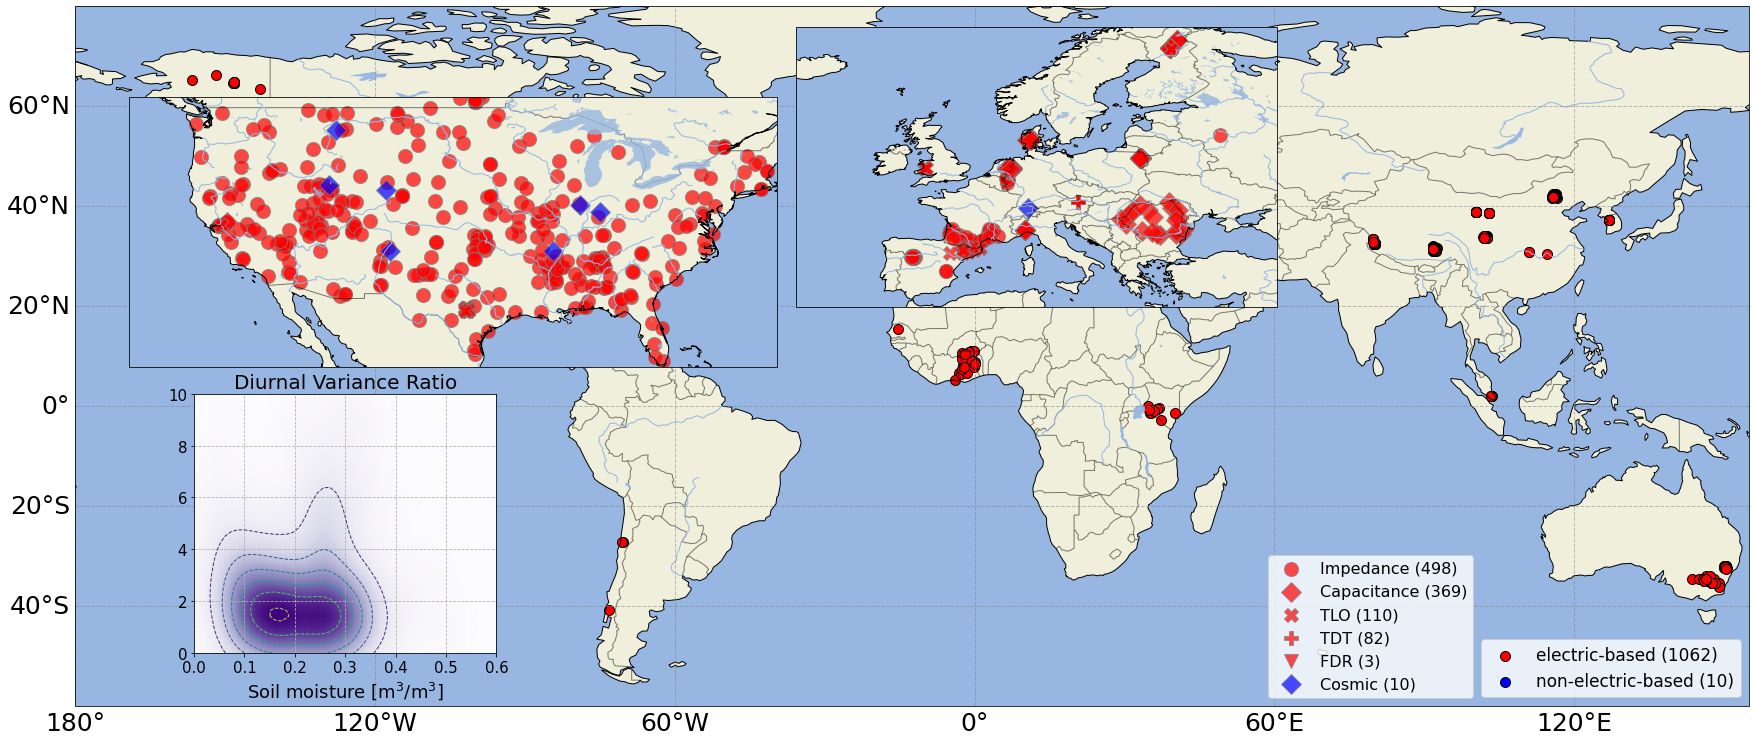

In [1260]:
# Create the combined plot
fig = plt.figure(figsize=(30, 30))
fig.set_facecolor('white')

# Main map
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
ax.set_extent([-180, 155, -60, 80], crs=ccrs.PlateCarree())
ax.coastlines()
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.BORDERS, linestyle='-', alpha=.5)
ax.add_feature(cfeature.LAKES, alpha=0.95)
ax.add_feature(cfeature.RIVERS)

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 25}
gl.ylabel_style = {'size': 25}
scatter_elec = ax.scatter(elec['lon'], elec['lat'], c='r', transform=ccrs.PlateCarree(), s=100, alpha=1, edgecolor='k', label=f'electric-based ({len(elec)})')
scatter_n_elec = ax.scatter(n_elec['lon'], n_elec['lat'], c='b', transform=ccrs.PlateCarree(), s=100, alpha=1, edgecolor='k', label=f'non-electric-based ({len(n_elec)})')

# CONUS
ax_inset = fig.add_axes([0.15, 0.41, 0.3, 0.3], projection=ccrs.PlateCarree())
ax_inset.set_extent([-130, -70, 25, 50], crs=ccrs.PlateCarree())
ax_inset.coastlines()
ax_inset.add_feature(cfeature.LAND)
ax_inset.add_feature(cfeature.OCEAN)
ax_inset.add_feature(cfeature.BORDERS, linestyle='-', alpha=0.5)
ax_inset.add_feature(cfeature.LAKES, alpha=0.8)
ax_inset.add_feature(cfeature.RIVERS)

scatter_Imp = ax_inset.scatter(Impedance['lon'], Impedance['lat'], c='r', transform=ccrs.PlateCarree(), s=200, alpha=.7, marker='o', edgecolor='gray', label='Impedance')
scatter_FDR = ax_inset.scatter(FDR['lon'], FDR['lat'], c='r', transform=ccrs.PlateCarree(), s=200, alpha=.7, marker='v', edgecolor='gray', label='FDR')
scatter_TDT = ax_inset.scatter(TDT['lon'], TDT['lat'], c='r', transform=ccrs.PlateCarree(), s=200, alpha=.7, marker='P', edgecolor='gray', label='TDT')
scatter_Cap = ax_inset.scatter(Capacitance['lon'], Capacitance['lat'], c='r', transform=ccrs.PlateCarree(), s=200, alpha=.7, marker='D', edgecolor='gray', label='Capacitance')
scatter_TLO = ax_inset.scatter(TLO['lon'], TLO['lat'], c='r', transform=ccrs.PlateCarree(), s=200, alpha=.7, marker='X', edgecolor='gray', label='TLO')
scatter_Cos = ax_inset.scatter(Cosmic['lon'], Cosmic['lat'], c='b', transform=ccrs.PlateCarree(), s=200, alpha=.7, marker='D', edgecolor='gray', label='Cosmic-ray')

handles_ax, labels_ax = ax.get_legend_handles_labels()
handles_inset = [scatter_Imp, scatter_Cap, scatter_TLO, scatter_TDT, scatter_FDR, scatter_Cos]
labels_inset = [f'Impedance ({len_Impedance})', f'Capacitance ({len_Capacitance})', f'TLO ({len_TLO})', f'TDT ({len_TDT})', f'FDR ({len_FDR})', f'Cosmic ({len_Cosmic})']

legend_ax = ax.legend(handles_ax, labels_ax, loc='lower right',fontsize=17,bbox_to_anchor=(1., .0))

legend_inset = ax.legend(handles_inset, labels_inset, loc='lower right', fontsize=16,bbox_to_anchor=(.84, .0))
ax.add_artist(legend_ax)

# EU
ax_inset2 = fig.add_axes([0.455, 0.525, 0.23, 0.13], projection=ccrs.PlateCarree())
ax_inset2.set_extent([-20, 40, 35, 70], crs=ccrs.PlateCarree()) 

ax_inset2.coastlines()
ax_inset2.add_feature(cfeature.LAND)
ax_inset2.add_feature(cfeature.OCEAN)
ax_inset2.add_feature(cfeature.BORDERS, linestyle='-', alpha=0.5)
ax_inset2.add_feature(cfeature.LAKES, alpha=0.8)
ax_inset2.add_feature(cfeature.RIVERS)

ax_inset2.scatter(Impedance['lon'], Impedance['lat'], c='r', transform=ccrs.PlateCarree(), s=200, alpha=.7, marker='o', edgecolor='gray', label='Impedance')
ax_inset2.scatter(FDR['lon'], FDR['lat'], c='r', transform=ccrs.PlateCarree(), s=200, alpha=.7, marker='v', edgecolor='gray', label='FDR')
ax_inset2.scatter(TDT['lon'], TDT['lat'], c='r', transform=ccrs.PlateCarree(), s=200, alpha=.7, marker='P', edgecolor='gray', label='TDT')
ax_inset2.scatter(Capacitance['lon'], Capacitance['lat'], c='r', transform=ccrs.PlateCarree(), s=200, alpha=.7, marker='D', edgecolor='gray', label='Capacitance')
ax_inset2.scatter(TLO['lon'], TLO['lat'], c='r', transform=ccrs.PlateCarree(), s=200, alpha=.7, marker='X', edgecolor='gray', label='TLO')
ax_inset2.scatter(Cosmic['lon'], Cosmic['lat'], c='b', transform=ccrs.PlateCarree(), s=200, alpha=.7, marker='D', edgecolor='gray', label='Cosmic-ray')

# Ratio plot
ax_ratio = fig.add_axes([0.18, 0.365, 0.14, 0.12]) 
data = np.column_stack((sm_m, var_f))
nbins = 50
xmin, xmax, ymin, ymax = 0, 0.6, 0, 10
k = stats.gaussian_kde(data.T)
xi, yi = np.mgrid[xmin:xmax:nbins*1j, ymin:ymax:nbins*1j]
zi = k(np.vstack([xi.flatten(), yi.flatten()]))
ax_ratio.pcolormesh(xi, yi, zi.reshape(xi.shape), shading='gouraud', cmap='Purples')
ax_ratio.contour(xi, yi, zi.reshape(xi.shape), linewidths=1, linestyles='dashed', cmap='viridis')
ax_ratio.set_xlabel('Soil moisture [m$^3$/m$^3$]', fontsize=18)
ax_ratio.set_xlim(xmin, xmax)
ax_ratio.set_ylim(ymin, ymax)
ax_ratio.tick_params(axis='both', labelsize=15)
ax_ratio.grid(True, linestyle='--')
ax_ratio.set_title('Diurnal Variance Ratio', fontsize=20)

plt.savefig(fname+'figure 1 map', dpi=600, bbox_inches = 'tight', pad_inches = 0.02)
plt.show()

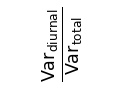

In [1261]:
fig, ax = plt.subplots(figsize=(2, 1))

ax.text(0.5, 0.5, r'$\frac{\text{Var}_{\text{diurnal}}}{\text{Var}_{\text{total}}}$', fontsize=25, ha='center', va='center', rotation=90)
ax.axis("off")

plt.savefig(fname+'figure 1 eq1', dpi=600, bbox_inches="tight", pad_inches=0.1)
plt.show()

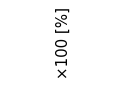

In [1262]:
fig, ax = plt.subplots(figsize=(2, 1))

ax.text(0.5, 0.5, '×100 [%]', fontsize=15, ha='center', va='center', rotation=90)
ax.axis("off")

plt.savefig(fname+'figure 1 eq2', dpi=300, bbox_inches="tight", pad_inches=0.1)
plt.show()

# Figure 2

## data

### (a)

In [232]:
ISMN_sm=sorted(glob.glob('/home/jnhan/python/power spectrum/data/final filter/sm/ISMN_filter/*.csv'))
ISMN_ts=sorted(glob.glob('/home/jnhan/python/power spectrum/data/final filter/ts/ISMN_filter/*.csv'))
ISMN2=sorted(glob.glob('/home/jnhan/python/power spectrum/data/ISMN/sm/global/0-10/*'))

In [233]:
ISMN1_st=[i.split('/')[-1][:-6] for i in ISMN_sm]
ISMN2=[item for item in ISMN2 if any(b in item for b in ISMN1_st)]

In [234]:
sensor=[]
for i in range(len(ISMN_sm)):
    print(i,end='\r')
    sensor.append(ISMN2[i].split('/')[-1].split('_')[6])

In [235]:
sensor_classify=sensor.copy()
sensor_classify=['Impedance' if any(word in item for word in ['Theta', 'Hydra']) else item for item in sensor_classify]
sensor_classify=['TDR' if any(word in item for word in ['D-LOG-','TDR','TRIME']) else item for item in sensor_classify]
sensor_classify=['TDT' if 'Time-Domain-Tran' in item else item for item in sensor_classify]
sensor_classify=['Capacitance' if any(word in item for word in ['5T','Decagon' ,'Delta','EC','GS','TEROS','WaterScout']) else item for item in sensor_classify]
sensor_classify=['FDR' if 'LVDSC' in item else item for item in sensor_classify]
sensor_classify=['TLO' if 'CS6' in item else item for item in sensor_classify]
sensor_classify=['WMP' if any(word in item for word in ['SMP','Water']) else item for item in sensor_classify]
sensor_classify=['etc' if item not in ['Impedance', 'TDR', 'TDT', 'Capacitance', 'FDR', 'TLO','WMP'] else item for item in sensor_classify]

In [236]:
Imp_idx=[i for i,j in enumerate(sensor_classify) if j == 'Impedance']
Cap_idx=[i for i,j in enumerate(sensor_classify) if j == 'Capacitance']
FDR_idx=[i for i,j in enumerate(sensor_classify) if j == 'FDR']

ISMN_sm_Imp=[ISMN_sm[i] for i in Imp_idx]
ISMN_sm_Cap=[ISMN_sm[i] for i in Cap_idx]
ISMN_sm_FDR=[ISMN_sm[i] for i in FDR_idx]

ISMN_ts_Imp=[ISMN_ts[i] for i in Imp_idx]
ISMN_ts_Cap=[ISMN_ts[i] for i in Cap_idx]
ISMN_ts_FDR=[ISMN_ts[i] for i in FDR_idx]

In [237]:
ISMN_sm_cos=glob.glob('/home/jnhan/python/power spectrum/data/ISMN/sm/cosmic/*.csv')
ISMN_ts_cos=glob.glob('/home/jnhan/python/power spectrum/data/ISMN/ts/cosmic_nearest/*.csv')

ISMN_sm_TDT=glob.glob('/home/jnhan/python/power spectrum/data/reference sensor/sm/TDT/*')
ISMN_ts_TDT=glob.glob('/home/jnhan/python/power spectrum/data/reference sensor/ts/TDT/*')

ISMN_sm_TDR=glob.glob('/home/jnhan/python/power spectrum/data/reference sensor/sm/TDR/*')
ISMN_ts_TDR=glob.glob('/home/jnhan/python/power spectrum/data/reference sensor/ts/TDR/*')

ISMN_sm_TLO=glob.glob('/home/jnhan/python/power spectrum/data/reference sensor/sm/TLO/*')
ISMN_ts_TLO=glob.glob('/home/jnhan/python/power spectrum/data/reference sensor/ts/TLO/*')

In [238]:
# Impedance
Imp_R=[]
for i in range(len(ISMN_sm_Imp)):
    print(i,end='\r')
    Imp_sm=pd.read_csv(ISMN_sm_Imp[i],index_col='date_time',usecols=['date_time','soil_moisture','anomaly'])
    Imp_ts=pd.read_csv(ISMN_ts_Imp[i],index_col='date_time',usecols=['date_time','soil_temperature','anomaly'])

    Imp_sm.index=pd.to_datetime(Imp_sm.index)
    Imp_ts.index=pd.to_datetime(Imp_ts.index)

    Imp_sm_h=Imp_sm.groupby(Imp_sm.index.hour).mean()
    Imp_ts_h=Imp_ts.groupby(Imp_ts.index.hour).mean()

    Imp_R.append(stats.pearsonr(Imp_sm_h['anomaly'],Imp_ts_h['anomaly'])[0])

In [239]:
# Capacitance
Cap_R=[]
for i in range(len(ISMN_sm_Cap)):
    print(i,end='\r')
    Cap_sm=pd.read_csv(ISMN_sm_Cap[i],index_col='date_time',usecols=['date_time','soil_moisture','anomaly'])
    Cap_ts=pd.read_csv(ISMN_ts_Cap[i],index_col='date_time',usecols=['date_time','soil_temperature','anomaly'])

    Cap_sm.index=pd.to_datetime(Cap_sm.index)
    Cap_ts.index=pd.to_datetime(Cap_ts.index)

    Cap_sm_h=Cap_sm.groupby(Cap_sm.index.hour).mean()
    Cap_ts_h=Cap_ts.groupby(Cap_ts.index.hour).mean()

    Cap_R.append(stats.pearsonr(Cap_sm_h['anomaly'],Cap_ts_h['anomaly'])[0])

In [240]:
# FDR
FDR_R=[]
for i in range(len(ISMN_sm_FDR)):
    print(i,end='\r')
    FDR_sm=pd.read_csv(ISMN_sm_FDR[i],index_col='date_time',usecols=['date_time','soil_moisture','anomaly'])
    FDR_ts=pd.read_csv(ISMN_ts_FDR[i],index_col='date_time',usecols=['date_time','soil_temperature','anomaly'])

    FDR_sm.index=pd.to_datetime(FDR_sm.index)
    FDR_ts.index=pd.to_datetime(FDR_ts.index)

    FDR_sm_h=FDR_sm.groupby(FDR_sm.index.hour).mean()
    FDR_ts_h=FDR_ts.groupby(FDR_ts.index.hour).mean()

    FDR_R.append(stats.pearsonr(FDR_sm_h['anomaly'],FDR_ts_h['anomaly'])[0])

In [241]:
# TLO
TLO_R=[]
for i in range(len(ISMN_sm_TLO)):
    print(i,end='\r')
    TLO_sm=pd.read_csv(ISMN_sm_TLO[i],index_col='date_time',usecols=['date_time','soil_moisture','anomaly'])
    TLO_ts=pd.read_csv(ISMN_ts_TLO[i],index_col='date_time',usecols=['date_time','soil_temperature','anomaly'])

    TLO_sm.index=pd.to_datetime(TLO_sm.index)
    TLO_ts.index=pd.to_datetime(TLO_ts.index)

    TLO_sm_h=TLO_sm.groupby(TLO_sm.index.hour).mean()
    TLO_ts_h=TLO_ts.groupby(TLO_ts.index.hour).mean()

    TLO_R.append(stats.pearsonr(TLO_sm_h['anomaly'],TLO_ts_h['anomaly'])[0])

In [242]:
# TDT
TDT_R=[]
for i in range(len(ISMN_sm_TDT)):
    print(i,end='\r')
    TDT_sm=pd.read_csv(ISMN_sm_TDT[i],index_col='date_time',usecols=['date_time','soil_moisture','anomaly'])
    TDT_ts=pd.read_csv(ISMN_ts_TDT[i],index_col='date_time',usecols=['date_time','soil_temperature','anomaly'])

    TDT_sm.index=pd.to_datetime(TDT_sm.index)
    TDT_ts.index=pd.to_datetime(TDT_ts.index)

    TDT_sm_h=TDT_sm.groupby(TDT_sm.index.hour).mean()
    TDT_ts_h=TDT_ts.groupby(TDT_ts.index.hour).mean()

    TDT_R.append(stats.pearsonr(TDT_sm_h['anomaly'],TDT_ts_h['anomaly'])[0])

In [243]:
# TDR
TDR_R=[]
for i in range(len(ISMN_sm_TDR)):
    print(i,end='\r')
    TDR_sm=pd.read_csv(ISMN_sm_TDR[i],index_col='date_time',usecols=['date_time','soil_moisture','anomaly'])
    TDR_ts=pd.read_csv(ISMN_ts_TDR[i],index_col='date_time',usecols=['date_time','soil_temperature','anomaly'])

    TDR_sm.index=pd.to_datetime(TDR_sm.index)
    TDR_ts.index=pd.to_datetime(TDR_ts.index)

    TDR_sm_h=TDR_sm.groupby(TDR_sm.index.hour).mean()
    TDR_ts_h=TDR_ts.groupby(TDR_ts.index.hour).mean()

    TDR_R.append(stats.pearsonr(TDR_sm_h['anomaly'],TDR_ts_h['anomaly'])[0])

In [244]:
# Cosmic
Cos_R=[]
for i in range(len(ISMN_sm_cos)):
    print(i,end='\r')
    Cos_sm=pd.read_csv(ISMN_sm_cos[i],index_col='date_time',usecols=['date_time','soil_moisture','anomaly'])
    Cos_ts=pd.read_csv(ISMN_ts_cos[i],index_col='date_time',usecols=['date_time','soil_temperature','anomaly'])

    Cos_sm.index=pd.to_datetime(Cos_sm.index)
    Cos_ts.index=pd.to_datetime(Cos_ts.index)

    Cos_sm_h=Cos_sm.groupby(Cos_sm.index.hour).mean()
    Cos_ts_h=Cos_ts.groupby(Cos_ts.index.hour).mean()

    Cos_R.append(stats.pearsonr(Cos_sm_h['anomaly'],Cos_ts_h['anomaly'])[0])

In [245]:
Cos_R2=[i for i in Cos_R if i<-0.41]

In [246]:
df_Imp=pd.DataFrame()
df_Imp['[-]']=Imp_R
df_Imp['sensor']='Impedance'

df_Cap=pd.DataFrame()
df_Cap['[-]']=Cap_R
df_Cap['sensor']='Capacitance'

df_TLO=pd.DataFrame()
df_TLO['[-]']=TLO_R
df_TLO['sensor']='TLO'

df_TDT=pd.DataFrame()
df_TDT['[-]']=TDT_R
df_TDT['sensor']='TDT'

df_FDR=pd.DataFrame()
df_FDR['[-]']=FDR_R
df_FDR['sensor']='FDR'

df_Cos=pd.DataFrame()
df_Cos['[-]']=Cos_R
df_Cos['sensor']='Cosmic-ray'

df_Cos2=pd.DataFrame()
df_Cos2['[-]']=Cos_R2
df_Cos2['sensor']='Cosmic-ray'

R_concat=pd.concat([df_Cap, df_Imp, df_FDR, df_TLO, df_TDT, df_Cos], axis=0, ignore_index=True)
R_concat['principle']=' '

R_concat2=pd.concat([df_Cap, df_Imp, df_FDR, df_TLO, df_TDT, df_Cos2], axis=0, ignore_index=True)
R_concat2['principle']=' '

In [247]:
Cap_m=round(np.median(R_concat[R_concat['sensor']=='Capacitance']['[-]']),2)
Imp_m=round(np.median(R_concat[R_concat['sensor']=='Impedance']['[-]']),2)
FDR_m=round(np.median(R_concat[R_concat['sensor']=='FDR']['[-]']),2)
TLO_m=round(np.median(R_concat[R_concat['sensor']=='TLO']['[-]']),2)
TDT_m=round(np.median(R_concat[R_concat['sensor']=='TDT']['[-]']),2)
Cos_m=round(np.median(R_concat[R_concat['sensor']=='Cosmic-ray']['[-]']),2)

### (b)

In [204]:
ISMN_sm=sorted(glob.glob('/home/jnhan/python/power spectrum/data/final filter/sm/ISMN_filter/*.csv'))
ISMN_ts=sorted(glob.glob('/home/jnhan/python/power spectrum/data/final filter/ts/ISMN_filter/*.csv'))

ERA_data=sorted(glob.glob('/home/jnhan/python/power spectrum/data/ERA5/p_remove_250608/*.csv'))
MERRA_data=sorted(glob.glob('/home/jnhan/python/power spectrum/data/MERRA2/p_remove_250608/*.csv'))

In [205]:
len(ISMN_sm),len(ISMN_ts),len(ERA_data),len(MERRA_data)

(1174, 1174, 1174, 1174)

In [82]:
# for cosmic sensor
MERRA_sm2=sorted(glob.glob('/home/jnhan/python/power spectrum/data/MERRA2/sm/global/0-10/*.csv'))
ERA_sm2=sorted(glob.glob('/home/jnhan/python/power spectrum/data/ERA5/sm/global/0-10/*.csv'))

In [59]:
TLO_sm=glob.glob('/home/jnhan/python/power spectrum/data/reference sensor/sm/TLO/*')
TLO_ts=glob.glob('/home/jnhan/python/power spectrum/data/reference sensor/ts/TLO/*')
TLO_n_sm=glob.glob('/home/jnhan/python/power spectrum/data/reference sensor/sm/TLO_nearest/*')
TLO_n_ts=glob.glob('/home/jnhan/python/power spectrum/data/reference sensor/ts/TLO_nearest/*')
TDT_sm=glob.glob('/home/jnhan/python/power spectrum/data/reference sensor/sm/TDT/*')
TDT_ts=glob.glob('/home/jnhan/python/power spectrum/data/reference sensor/ts/TDT/*')
TDT_n_sm=glob.glob('/home/jnhan/python/power spectrum/data/reference sensor/sm/TDT_nearest/*')
TDT_n_ts=glob.glob('/home/jnhan/python/power spectrum/data/reference sensor/ts/TDT_nearest/*')
TDR_sm=glob.glob('/home/jnhan/python/power spectrum/data/reference sensor/sm/TDR/*')
TDR_ts=glob.glob('/home/jnhan/python/power spectrum/data/reference sensor/ts/TDR/*')
TDR_n_sm=glob.glob('/home/jnhan/python/power spectrum/data/reference sensor/sm/TDR_nearest/*')
TDR_n_ts=glob.glob('/home/jnhan/python/power spectrum/data/reference sensor/ts/TDR_nearest/*')
COS_sm=glob.glob('/home/jnhan/python/power spectrum/data/reference sensor/sm/cosmic/*.csv')
COS_n_sm=glob.glob('/home/jnhan/python/power spectrum/data/reference sensor/sm/cosmic_nearest/*.csv')
COS_n_ts=glob.glob('/home/jnhan/python/power spectrum/data/reference sensor/ts/cosmic_nearest/*.csv')


In [114]:
ISMN_st=[i.split('/')[-1][:-7] for i in ISMN_sm]

In [116]:
# ISMN에 맞춰서 정렬
ERA_data = sorted(ERA_data, key=lambda path: ISMN_st.index(next(a for a in ISMN_st if a in path)))
MERRA_data = sorted(MERRA_data, key=lambda path: ISMN_st.index(next(a for a in ISMN_st if a in path)))

In [141]:
TLO_st=[i.split('/')[-1][:-7] for i in TLO_sm]
TDT_st=[i.split('/')[-1][:-7] for i in TDT_sm]
TDR_st=[i.split('/')[-1][:-7] for i in TDR_sm]
COS_st=[i.split('/')[-1][:-7] for i in COS_sm]

In [169]:
TLO_ERA=[b for b in ERA_data if any(a in b for a in TLO_st)]
TDT_ERA=[b for b in ERA_data if any(a in b for a in TDT_st)]
TDR_ERA=[b for b in ERA_data if any(a in b for a in TDR_st)]
COS_ERA=[b for b in ERA_sm2 if any(a in b for a in COS_st)]

TLO_MERRA=[b for b in MERRA_data if any(a in b for a in TLO_st)]
TDT_MERRA=[b for b in MERRA_data if any(a in b for a in TDT_st)]
TDR_MERRA=[b for b in MERRA_data if any(a in b for a in TDR_st)]
COS_MERRA=[b for b in MERRA_sm2 if any(a in b for a in COS_st)]

In [171]:
TLO_ERA=[TLO_ERA[i] for i in [0, 1, 2, 4, 3, 5, 6]]
TLO_MERRA=[TLO_MERRA[i] for i in [0, 1, 2, 4, 3, 5, 6]]

TDT_ERA=[TDT_ERA[i] for i in [4, 2, 5, 8, 3, 0, 1, 9, 6, 7]]
TDT_MERRA=[TDT_MERRA[i] for i in [4, 2, 5, 8, 3, 0, 1, 9, 6, 7]]

In [175]:
TLO_n_st=[i.split('/')[-1][:-7] for i in TLO_n_sm]
TDT_n_st=[i.split('/')[-1][:-7] for i in TDT_n_sm]
TDR_n_st=[i.split('/')[-1][:-7] for i in TDR_n_sm]
COS_n_st=[i.split('/')[-1][:-7] for i in COS_n_sm]

In [190]:
TLO_n_ERA=[b for b in ERA_data if any(a in b for a in TLO_n_st)]
TDT_n_ERA=[b for b in ERA_data if any(a in b for a in TDT_n_st)]
TDR_n_ERA=[b for b in ERA_data if any(a in b for a in TDR_n_st)]
COS_n_ERA=[b for b in ERA_data if any(a in b for a in COS_n_st)]

TLO_n_MERRA=[b for b in MERRA_data if any(a in b for a in TLO_n_st)]
TDT_n_MERRA=[b for b in MERRA_data if any(a in b for a in TDT_n_st)]
TDR_n_MERRA=[b for b in MERRA_data if any(a in b for a in TDR_n_st)]
COS_n_MERRA=[b for b in MERRA_data if any(a in b for a in COS_n_st)]

In [194]:
COS_n_ERA=[COS_n_ERA[i] for i in [7, 2, 4, 9, 3, 5, 6, 0, 1, 8]]
COS_n_MERRA=[COS_n_MERRA[i] for i in [7, 2, 4, 9, 3, 5, 6, 0, 1, 8]]

TLO_n_ERA=[TLO_n_ERA[i] for i in [5, 0, 1, 4, 3, 2, 6]]
TLO_n_MERRA=[TLO_n_MERRA[i] for i in [5, 0, 1, 4, 3, 2, 6]]

TDT_n_ERA=[TDT_n_ERA[i] for i in [0, 8, 6, 3, 5, 2, 4, 7, 1, 9]]
TDT_n_MERRA=[TDT_n_MERRA[i] for i in [0, 8, 6, 3, 5, 2, 4, 7, 1, 9]]

In [159]:
TLO_h=[]
TLO_R_IE=[]
TLO_R_IM=[]
TLO_R_Ib=[]
for i in range(len(TLO_ERA)):
    ISMN=pd.read_csv(TLO_sm[i],index_col='date_time',usecols=['date_time','soil_moisture','anomaly'],parse_dates=['date_time'])
    ERA=pd.read_csv(TLO_ERA[i],index_col='date_time',usecols=['date_time','sm','sm ano','ts','ts ano'],parse_dates=['date_time'])
    MERRA=pd.read_csv(TLO_MERRA[i],index_col='date_time',usecols=['date_time','sm','sm ano','ts','ts ano'],parse_dates=['date_time'])
    ISMN_ts=pd.read_csv(TLO_ts[i],index_col='date_time',usecols=['date_time','soil_temperature','anomaly'],parse_dates=['date_time'])
    
    ISMN.rename(columns={'soil_moisture':'ISMN sm','anomaly':'ISMN sm ano'},inplace=True)
    ERA.rename(columns={'sm':'ERA sm','sm ano':'ERA sm ano','ts':'ERA ts','ts ano':'ERA ts ano'},inplace=True)
    MERRA.rename(columns={'sm':'MERRA sm','sm ano':'MERRA sm ano','ts':'MERRA ts','ts ano':'MERRA ts ano'},inplace=True)
    ISMN_ts.rename(columns={'soil_temperature':'ISMN ts','anomaly':'ISMN ts ano'},inplace=True)

    merged = ISMN.merge(ERA, left_index=True, right_index=True, how='inner')
    merged = merged.merge(MERRA, left_index=True, right_index=True, how='inner')
    merged = merged.merge(ISMN_ts, left_index=True, right_index=True, how='inner')

    merged['LSMs_mean_sm']=[(0.5*i)+(0.5*j) for i,j in zip(merged['ERA sm ano'],merged['MERRA sm ano'])]
    merged['LSMs_mean_ts']=[(0.5*i)+(0.5*j) for i,j in zip(merged['ERA ts ano'],merged['MERRA ts ano'])]
    
    hourly = merged.groupby(merged.index.hour).mean()
    
    TLO_h.append(hourly)
    TLO_R_IE.append(stats.pearsonr(hourly['ISMN sm ano'],hourly['ERA sm ano'])[0])
    TLO_R_IM.append(stats.pearsonr(hourly['ISMN sm ano'],hourly['MERRA sm ano'])[0])
    TLO_R_Ib.append(stats.pearsonr(hourly['ISMN sm ano'],hourly['LSMs_mean_sm'])[0])
    
    del ISMN,ERA,MERRA,ISMN_ts,merged,hourly

In [160]:
TDT_h=[]
TDT_R_IE=[]
TDT_R_IM=[]
TDT_R_Ib=[]
for i in range(len(TDT_ERA)):
    ISMN=pd.read_csv(TDT_sm[i],index_col='date_time',usecols=['date_time','soil_moisture','anomaly'],parse_dates=['date_time'])
    ERA=pd.read_csv(TDT_ERA[i],index_col='date_time',usecols=['date_time','sm','sm ano','ts','ts ano'],parse_dates=['date_time'])
    MERRA=pd.read_csv(TDT_MERRA[i],index_col='date_time',usecols=['date_time','sm','sm ano','ts','ts ano'],parse_dates=['date_time'])
    ISMN_ts=pd.read_csv(TDT_ts[i],index_col='date_time',usecols=['date_time','soil_temperature','anomaly'],parse_dates=['date_time'])
    
    ISMN.rename(columns={'soil_moisture':'ISMN sm','anomaly':'ISMN sm ano'},inplace=True)
    ERA.rename(columns={'sm':'ERA sm','sm ano':'ERA sm ano','ts':'ERA ts','ts ano':'ERA ts ano'},inplace=True)
    MERRA.rename(columns={'sm':'MERRA sm','sm ano':'MERRA sm ano','ts':'MERRA ts','ts ano':'MERRA ts ano'},inplace=True)
    ISMN_ts.rename(columns={'soil_temperature':'ISMN ts','anomaly':'ISMN ts ano'},inplace=True)

    merged = ISMN.merge(ERA, left_index=True, right_index=True, how='inner')
    merged = merged.merge(MERRA, left_index=True, right_index=True, how='inner')
    merged = merged.merge(ISMN_ts, left_index=True, right_index=True, how='inner')

    merged['LSMs_mean_sm']=[(0.5*i)+(0.5*j) for i,j in zip(merged['ERA sm ano'],merged['MERRA sm ano'])]
    merged['LSMs_mean_ts']=[(0.5*i)+(0.5*j) for i,j in zip(merged['ERA ts ano'],merged['MERRA ts ano'])]
    
    hourly = merged.groupby(merged.index.hour).mean()
    
    TDT_h.append(hourly)
    TDT_R_IE.append(stats.pearsonr(hourly['ISMN sm ano'],hourly['ERA sm ano'])[0])
    TDT_R_IM.append(stats.pearsonr(hourly['ISMN sm ano'],hourly['MERRA sm ano'])[0])
    TDT_R_Ib.append(stats.pearsonr(hourly['ISMN sm ano'],hourly['LSMs_mean_sm'])[0])
    
    del ISMN,ERA,MERRA,ISMN_ts,merged,hourly

In [199]:
COS_h=[]
COS_R_IE=[]
COS_R_IM=[]
COS_R_Ib=[]
for i in range(len(COS_ERA)):
    ISMN=pd.read_csv(COS_sm[i],index_col='date_time',usecols=['date_time','soil_moisture','anomaly'],parse_dates=['date_time'])
    ERA=pd.read_csv(COS_ERA[i],index_col='date_time',usecols=['date_time','sm'],parse_dates=['date_time'])
    MERRA=pd.read_csv(COS_MERRA[i],index_col='date_time',usecols=['date_time','sm'],parse_dates=['date_time'])
    ISMN_ts=pd.read_csv(COS_n_ts[i],index_col='date_time',usecols=['date_time','soil_temperature','anomaly'],parse_dates=['date_time'])
    ERA_ts=pd.read_csv(COS_n_ERA[i],index_col='date_time',usecols=['date_time','ts','ts ano'],parse_dates=['date_time'])
    MERRA_ts=pd.read_csv(COS_n_MERRA[i],index_col='date_time',usecols=['date_time','ts','ts ano'],parse_dates=['date_time'])

    ERA['anomaly']=ERA-ERA.rolling(window=24,center=True,min_periods=1).mean()
    MERRA['anomaly']=MERRA-MERRA.rolling(window=24,center=True,min_periods=1).mean()
    
    ISMN.rename(columns={'soil_moisture':'ISMN sm','anomaly':'ISMN sm ano'},inplace=True)
    ERA.rename(columns={'sm':'ERA sm','anomaly':'ERA sm ano'},inplace=True)
    MERRA.rename(columns={'sm':'MERRA sm','anomaly':'MERRA sm ano'},inplace=True)
    ISMN_ts.rename(columns={'soil_temperature':'ISMN ts','anomaly':'ISMN ts ano'},inplace=True)
    ERA_ts.rename(columns={'ts':'ERA ts','ts ano':'ERA ts ano'},inplace=True)
    MERRA_ts.rename(columns={'ts':'MERRA ts','ts ano':'MERRA ts ano'},inplace=True)

    merged = ISMN.merge(ERA, left_index=True, right_index=True, how='inner')
    merged = merged.merge(MERRA, left_index=True, right_index=True, how='inner')
    merged = merged.merge(ISMN_ts, left_index=True, right_index=True, how='inner')
    merged = merged.merge(ERA_ts, left_index=True, right_index=True, how='inner')
    merged = merged.merge(MERRA_ts, left_index=True, right_index=True, how='inner')

    merged['LSMs_mean_sm']=[(0.5*i)+(0.5*j) for i,j in zip(merged['ERA sm ano'],merged['MERRA sm ano'])]
    merged['LSMs_mean_ts']=[(0.5*i)+(0.5*j) for i,j in zip(merged['ERA ts ano'],merged['MERRA ts ano'])]
    
    hourly = merged.groupby(merged.index.hour).mean()
    mean=[(i+j)/2 for i,j in zip(hourly['ERA sm ano'],hourly['MERRA sm ano'])]
    
    COS_h.append(hourly)
    COS_R_IE.append(stats.pearsonr(hourly['ISMN sm ano'],hourly['ERA sm ano'])[0])
    COS_R_IM.append(stats.pearsonr(hourly['ISMN sm ano'],hourly['MERRA sm ano'])[0])
    COS_R_Ib.append(stats.pearsonr(hourly['ISMN sm ano'],hourly['LSMs_mean_sm'])[0])
                    
    del ISMN,ERA,MERRA,ISMN_ts,ERA_ts,MERRA_ts,merged,hourly

In [200]:
cor_E_ref=COS_R_IE+TLO_R_IE+TDT_R_IE
cor_M_ref=COS_R_IM+TLO_R_IM+TDT_R_IM
cor_EM_ref=COS_R_Ib+TLO_R_Ib+TDT_R_Ib

cor_IE=pd.DataFrame()
cor_IE['R(ISMN,dataset)']=cor_E_ref
cor_IE['data']='ERA5-Land'
cor_IE['Dataset']=' '

cor_IM=pd.DataFrame()
cor_IM['R(ISMN,dataset)']=cor_M_ref
cor_IM['data']='MERRA-2'
cor_IM['Dataset']=' '

cor_Ib=pd.DataFrame()
cor_Ib['R(ISMN,dataset)']=cor_EM_ref
cor_Ib['data']='ERA5-Land + MERRA-2'
cor_Ib['Dataset']=' '

concat_R_ano=pd.concat([cor_IE,cor_IM,cor_Ib])
median=[f"{np.median(c):.2f}" for c in [cor_E_ref, cor_M_ref, cor_EM_ref]]

#### median2

In [206]:
h_ref=COS_h+TLO_h+TDT_h

In [208]:
'reference sensorㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡ'
h_lists_I_sm = [[] for _ in range(24)]  # h_0 ~ h_23에 해당하는 24개의 빈 리스트 생성

for i in range(len(h_ref)):
    for j in range(24):  # 0 ~ 23의 date_time에 대해 반복
        h_lists_I_sm[j].append(h_ref[i]['ISMN sm ano'].loc[j])

'ERA5-Land reference gridㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡ'
h_lists_E_sm = [[] for _ in range(24)]  # h_0 ~ h_23에 해당하는 24개의 빈 리스트 생성

for i in range(len(h_ref)):
    for j in range(24):  # 0 ~ 23의 date_time에 대해 반복
        h_lists_E_sm[j].append(h_ref[i]['ERA sm ano'].loc[j])

'MERRA2 reference gridㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡ'
h_lists_M_sm = [[] for _ in range(24)]  # h_0 ~ h_23에 해당하는 24개의 빈 리스트 생성

for i in range(len(h_ref)):
    for j in range(24):  # 0 ~ 23의 date_time에 대해 반복
        h_lists_M_sm[j].append(h_ref[i]['MERRA sm ano'].loc[j])

'LSMs reference gridㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡ'
h_lists_LSM_sm = [[] for _ in range(24)]  # h_0 ~ h_23에 해당하는 24개의 빈 리스트 생성

for i in range(len(h_ref)):
    for j in range(24):  # 0 ~ 23의 date_time에 대해 반복
        h_lists_LSM_sm[j].append(h_ref[i]['LSMs_mean_sm'].loc[j])

In [209]:
'reference sensorㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡ'
df_h_I = pd.DataFrame()

for hour in range(24):
    temp_df = pd.DataFrame({
        'sm ano': h_lists_I_sm[hour],
        'hour': str(hour)           
    })
    df_h_I = pd.concat([df_h_I, temp_df], ignore_index=True)

df_h_I['value']='ref sm'

'ERA5-Land reference gridㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡ'
df_h_E = pd.DataFrame()

for hour in range(24):
    temp_df = pd.DataFrame({
        'sm ano': h_lists_E_sm[hour],
        'hour': str(hour)           
    })
    df_h_E = pd.concat([df_h_E, temp_df], ignore_index=True)

df_h_E['value']='ERA sm'

'MERRA2 reference gridㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡ'
df_h_M = pd.DataFrame()

for hour in range(24):
    temp_df = pd.DataFrame({
        'sm ano': h_lists_M_sm[hour],
        'hour': str(hour)           
    })
    df_h_M = pd.concat([df_h_M, temp_df], ignore_index=True)

df_h_M['value']='MERRA sm'

'LSMs reference gridㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡ'
df_h_LSM = pd.DataFrame()

for hour in range(24):
    temp_df = pd.DataFrame({
        'sm ano': h_lists_LSM_sm[hour],
        'hour': str(hour)           
    })
    df_h_LSM = pd.concat([df_h_LSM, temp_df], ignore_index=True)

df_h_LSM['value']='LSM sm'

'ㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡ'
df_h=pd.concat([df_h_E,df_h_M,df_h_LSM])

In [210]:
df_h_I['hour'] = df_h_I['hour'].astype(int)
median_values = df_h_I.groupby('hour')['sm ano'].median()#.sort_index()

In [212]:
df_h_I['hour'] = df_h_I['hour'].astype(int)
median_ref = df_h_I.groupby('hour')['sm ano'].median().sort_index()

df_h_E['hour'] = df_h_E['hour'].astype(int)
median_E = df_h_E.groupby('hour')['sm ano'].median().sort_index()

df_h_M['hour'] = df_h_M['hour'].astype(int)
median_M = df_h_M.groupby('hour')['sm ano'].median().sort_index()

df_h_LSM['hour'] = df_h_LSM['hour'].astype(int)
median_LSM = df_h_LSM.groupby('hour')['sm ano'].median().sort_index()

In [216]:
R_rE=np.corrcoef(median_ref,median_E)[0,1]
R_rM=np.corrcoef(median_ref,median_M)[0,1]
R_rL=np.corrcoef(median_ref,median_LSM)[0,1]

median2=[f"{np.median(c):.2f}" for c in [R_rE, R_rM, R_rL]]

## plot

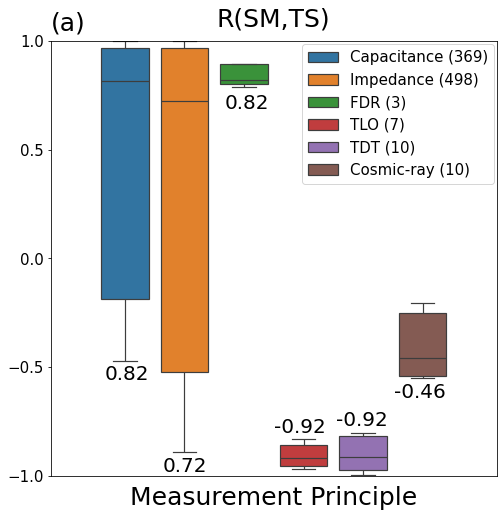

In [252]:
fig, axs = plt.subplots(1, 1, figsize=(8, 8))
fig.set_facecolor('white')

sns.boxplot(x='principle',y='[-]',hue='sensor',data=R_concat,whis=0.25,gap=0.2,linewidth=1.2,showfliers=False)
axs.set_title('R(SM,TS)',fontsize=25,pad=15)
axs.set_xlabel('Measurement Principle', fontsize=25,labelpad=10)
axs.set_ylim(-1.,1.)
# axs.axhline(-0.41,c='r',linestyle='--',linewidth=1)
axs.set_xticks([])
axs.set_yticks([-1.0,-0.5,0,0.5,1])
axs.tick_params(axis='y', labelsize=15)
axs.yaxis.label.set_visible(False)

handles_ax, labels_ax = axs.get_legend_handles_labels()
labels_inset=[f'Capacitance ({len(Cap_R)})',f'Impedance ({len(Imp_R)})', f'FDR ({len(FDR_R)})', f'TLO ({len(TLO_R)})',  f'TDT ({len(TDT_R)})', f'Cosmic-ray ({len(Cos_R)})']
legend_ax = axs.legend(handles_ax, labels_inset, bbox_to_anchor=(1.01,1.01), fontsize=15)

axs.text(-.5,1.05,'(a)',fontsize=25)
axs.text(-.38,-.56,Cap_m,fontsize=20)
axs.text(-.25,-.98,Imp_m,fontsize=20)
axs.text(-.11,.69,FDR_m,fontsize=20)
axs.text(0.,-.8,TLO_m,fontsize=20)
axs.text(.14,-.77,TDT_m,fontsize=20)
axs.text(.27,-.64,Cos_m,fontsize=20)
# plt.savefig(fname+'figure 2 R(sm,ts) by principle', dpi=300, bbox_inches = 'tight', pad_inches = 0.02)
plt.show()

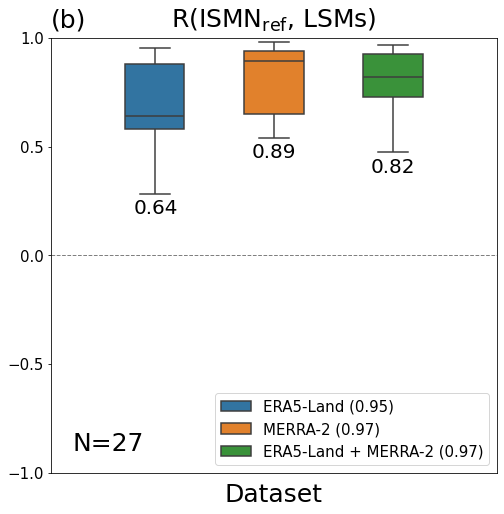

In [226]:
# 보정 전에 그냥 sm cycle이 reference와 모델간의 얼마나 일치하는지를 비율로 
fig, axs = plt.subplots(1, 1, figsize=(8, 8))
fig.set_facecolor('white')

sns.boxplot(x='Dataset', y='R(ISMN,dataset)', hue='data', data=concat_R_ano, linewidth=1.5, gap=0.5, whis=1.5, showfliers=False)
axs.set_title(r'R(ISMN$_{\text{ref}}$, LSMs)',fontsize=25,pad=10)
axs.set_xlabel('Dataset',fontsize=25, labelpad=10)
axs.set_ylim(-1.,1.)
axs.axhline(0., linestyle='--', c='gray', linewidth=1)
axs.set_xticks([])
axs.set_yticks([-1.0,-0.5,0,0.5,1])
axs.tick_params(axis='y', labelsize=15)
axs.text(-.5,1.05,'(b)',fontsize=25)
axs.yaxis.label.set_visible(False)
# axs.set_ylim(0,1)


handles, labels = axs.get_legend_handles_labels()
new_labels = [f"{label} ({med})" for label, med in zip(labels, median2)]
plt.legend(handles, new_labels, fontsize=15, loc='lower right')# bbox_to_anchor=(1.02, 1))
plt.text(-.45,-.9,'N=27',fontsize=25)
plt.text(-0.313,0.19,median[0],fontsize=20)
plt.text(-0.05,0.45,median[1],fontsize=20)
plt.text(0.217,0.38,median[2],fontsize=20)
# plt.savefig(fname+'figure 2 R(ISMN_ref,model)', dpi=300, bbox_inches = 'tight', pad_inches = 0.02)
plt.show()


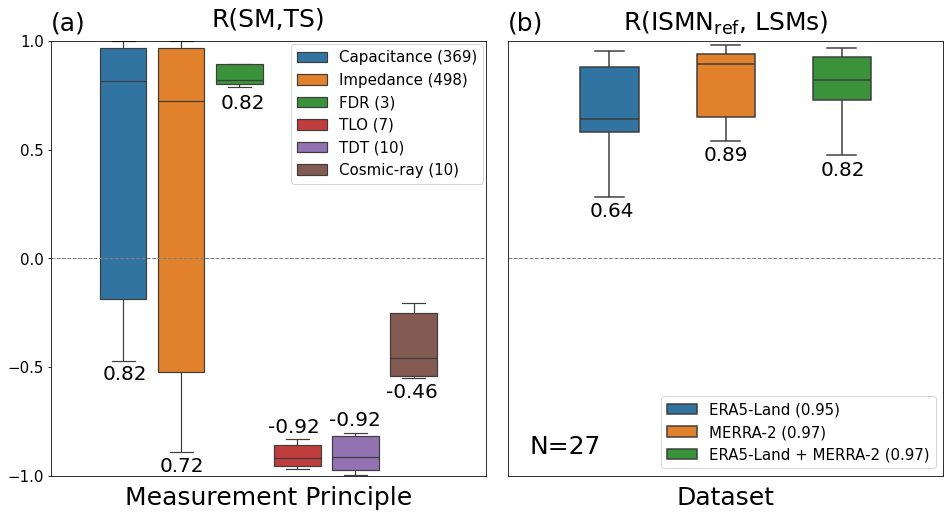

In [1263]:
fig, axs = plt.subplots(1, 2, figsize=(16, 8),gridspec_kw={'wspace': 0.05})
fig.set_facecolor('white')

'(a)ㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡ'
sns.boxplot(x='principle',y='[-]',hue='sensor',data=R_concat,whis=0.25,gap=0.2,linewidth=1.2,showfliers=False, ax=axs[0])
axs[0].set_title('R(SM,TS)',fontsize=25,pad=15)
axs[0].set_xlabel('Measurement Principle', fontsize=25,labelpad=10)
axs[0].set_ylim(-1.,1.)
# axs[0].axhline(-0.41,c='r',linestyle='--',linewidth=1)
axs[0].axhline(0.0,c='gray',linestyle='--',linewidth=1)
axs[0].set_xticks([])
axs[0].set_yticks([-1.0,-0.5,0,0.5,1])
axs[0].tick_params(axis='y', labelsize=15)
axs[0].yaxis.label.set_visible(False)

handles_ax, labels_ax = axs[0].get_legend_handles_labels()
labels_inset=[f'Capacitance ({len(Cap_R)})',f'Impedance ({len(Imp_R)})', f'FDR ({len(FDR_R)})', f'TLO ({len(TLO_R)})',  f'TDT ({len(TDT_R)})', f'Cosmic-ray ({len(Cos_R)})']
legend_ax = axs[0].legend(handles_ax, labels_inset, bbox_to_anchor=(1.01,1.01), fontsize=15)

axs[0].text(-.5,1.05,'(a)',fontsize=25)
'(b)ㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡ'
sns.boxplot(x='Dataset', y='R(ISMN,dataset)', hue='data', data=concat_R_ano, linewidth=1.5, gap=0.5, whis=1.5, showfliers=False,ax=axs[1])
axs[1].set_title(r'R(ISMN$_{\text{ref}}$, LSMs)',fontsize=25,pad=10)
axs[1].set_xlabel('Dataset',fontsize=25, labelpad=10)
axs[1].set_ylim(-1.,1.)
# axs[1].axhline(0.41, linestyle='--', c='r', linewidth=1)
axs[1].axhline(0.0,c='gray',linestyle='--',linewidth=1)
axs[1].set_xticks([])
axs[1].set_yticks([-1.0,-0.5,0,0.5,1])
axs[1].tick_params(axis='y', labelsize=15)
axs[1].text(-.5,1.05,'(b)',fontsize=25)
axs[1].yaxis.label.set_visible(False)
axs[1].yaxis.set_visible(False)
# axs[1].set_ylim(0,1)


handles, labels = axs[1].get_legend_handles_labels()
new_labels = [f"{label} ({med})" for label, med in zip(labels, median2)]
axs[1].legend(handles, new_labels, fontsize=15, loc='lower right')# bbox_to_anchor=(1.02, 1))
axs[1].text(-.45,-.9,'N=27',fontsize=25)
axs[1].text(-0.313,0.19,median[0],fontsize=20)
axs[1].text(-0.05,0.45,median[1],fontsize=20)
axs[1].text(0.217,0.38,median[2],fontsize=20)

axs[0].text(-.38,-.56,Cap_m,fontsize=20)
axs[0].text(-.25,-.98,Imp_m,fontsize=20)
axs[0].text(-.11,.69,FDR_m,fontsize=20)
axs[0].text(0.,-.8,TLO_m,fontsize=20)
axs[0].text(.14,-.77,TDT_m,fontsize=20)
axs[0].text(.27,-.64,Cos_m,fontsize=20)
plt.savefig(fname+'figure 2 combine', dpi=600, bbox_inches = 'tight', pad_inches = 0.02)
plt.show()

# Figure 3

## data

In [1409]:
ISMN_sm=sorted(glob.glob('/home/jnhan/python/power spectrum/data/final filter/sm/ISMN_filter/*.csv'))
ISMN_ts=sorted(glob.glob('/home/jnhan/python/power spectrum/data/final filter/ts/ISMN_filter/*.csv'))

ERA_data=sorted(glob.glob('/home/jnhan/python/power spectrum/data/ERA5/p_remove_250608/*.csv'))
MERRA_data=sorted(glob.glob('/home/jnhan/python/power spectrum/data/MERRA2/p_remove_250608/*.csv'))

In [1413]:
file_len=[]
for i in range(len(ISMN_sm)):
    print(i,end='\r')
    ISMN=pd.read_csv(ISMN_sm[i],usecols={'date_time','soil_moisture','anomaly'},index_col='date_time',parse_dates=['date_time'])
    ERA=pd.read_csv(ERA_data[i],usecols={'date_time','sm','sm ano'},index_col='date_time',parse_dates=['date_time'])
    MERRA=pd.read_csv(MERRA_data[i],usecols={'date_time','sm','sm ano'},index_col='date_time',parse_dates=['date_time'])
    ts_ISMN=pd.read_csv(ISMN_ts[i],usecols={'date_time','soil_temperature','anomaly'},index_col='date_time',parse_dates=['date_time'])
    
    merged =ISMN.merge(ERA, left_index=True, right_index=True, how='inner')
    merged =merged.merge(MERRA, left_index=True, right_index=True, how='inner')
    merged =merged.merge(ts_ISMN, left_index=True, right_index=True, how='inner')
    merged =merged.dropna()
    file_len.append(len(merged))

In [1499]:
idx=[i for i,j in enumerate(file_len) if j >=50000]

In [1500]:
len(idx)

31

In [1599]:
i=idx[13]

In [1914]:
ISMN2

date_time   network    station           instrument climate  \
0       2005-03-23 00:00:00  REMEDHUS  LasArenas  Stevens-Hydra-Probe     BSk   
1       2005-03-23 01:00:00  REMEDHUS  LasArenas  Stevens-Hydra-Probe     BSk   
2       2005-03-23 02:00:00  REMEDHUS  LasArenas  Stevens-Hydra-Probe     BSk   
3       2005-03-23 03:00:00  REMEDHUS  LasArenas  Stevens-Hydra-Probe     BSk   
4       2005-03-23 04:00:00  REMEDHUS  LasArenas  Stevens-Hydra-Probe     BSk   
...                     ...       ...        ...                  ...     ...   
126811  2022-12-31 19:00:00  REMEDHUS  LasArenas  Stevens-Hydra-Probe     BSk   
126812  2022-12-31 20:00:00  REMEDHUS  LasArenas  Stevens-Hydra-Probe     BSk   
126813  2022-12-31 21:00:00  REMEDHUS  LasArenas  Stevens-Hydra-Probe     BSk   
126814  2022-12-31 22:00:00  REMEDHUS  LasArenas  Stevens-Hydra-Probe     BSk   
126815  2022-12-31 23:00:00  REMEDHUS  LasArenas  Stevens-Hydra-Probe     BSk   

        lc2010  sand  silt  clay  elevation  latitude  longitude  \
0         10.0  19.0  32.0  49.0      -99.9  41.37338    -5.5485   
1         10.0  19.0  32.0  49.0      -99.9  41.37338    -5.5485   
2         10.0  19.0  32.0  49.0      -99.9  41.37338    -5.5485   
3         10.0  19.0  32.0  49.0      -99.9  41.37338    -5.5485   
4         10.0  19.0  32.0  49.0      -99.9  41.37338    -5.5485   
...        ...   ...   ...   ...        ...       ...        ...   
126811    10.0  19.0  32.0  49.0      -99.9  41.37338    -5.5485   
126812    10.0  19.0  32.0  49.0      -99.9  41.37338    -5.5485   
126813    10.0  19.0  32.0  49.0      -99.9  41.37338    -5.5485   
126814    10.0  19.0  32.0  49.0      -99.9  41.37338    -5.5485   
126815    10.0  19.0  32.0  49.0      -99.9  41.37338    -5.5485   

        soil_moisture flag        rm   anomaly  
0               0.070    G  0.071500 -0.001500  
1               0.069    G  0.072154 -0.003154  
2               0.069    G  0.072786 -0.003786  
3               0.070    G  0.073333 -0.003333  
4               0.070    G  0.073750 -0.003750  
...               ...  ...       ...       ...  
126811          0.280    G  0.281235 -0.001235  
126812          0.279    G  0.281062 -0.002062  
126813          0.278    G  0.280933 -0.002933  
126814          0.278    G  0.280857 -0.002857  
126815          0.277    G  0.280769 -0.003769  

[126816 rows x 16 columns]

In [1906]:
ISMN=pd.read_csv(ISMN_sm[524],usecols={'date_time','soil_moisture','anomaly'},index_col='date_time',parse_dates=['date_time'])
ERA=pd.read_csv(ERA_data[524],usecols={'date_time','sm','sm ano'},index_col='date_time',parse_dates=['date_time'])
MERRA=pd.read_csv(MERRA_data[524],usecols={'date_time','sm','sm ano'},index_col='date_time',parse_dates=['date_time'])
ts_ISMN=pd.read_csv(ISMN_ts[524],usecols={'date_time','soil_temperature','anomaly'},index_col='date_time',parse_dates=['date_time'])
ISMN2=pd.read_csv(ISMN_sm[524])

net_ex=ISMN2.network[0]
st_ex=ISMN2.station[0]
lat_ex=ISMN2.latitude[0]
lon_ex=ISMN2.longitude[0]

ISMN.rename(columns={'soil_moisture':'ISMN sm','anomaly':'ISMN sm ano'},inplace=True)
ERA.rename(columns={'sm':'ERA sm','sm ano':'ERA sm ano'},inplace=True)
MERRA.rename(columns={'sm':'MERRA sm','sm ano':'MERRA sm ano'},inplace=True)
ts_ISMN.rename(columns={'soil_temperature':'ISMN ts','anomaly':'ISMN ts ano'},inplace=True)

merged =ISMN.merge(ERA, left_index=True, right_index=True, how='inner')
merged =merged.merge(MERRA, left_index=True, right_index=True, how='inner')
merged =merged.merge(ts_ISMN, left_index=True, right_index=True, how='inner')
merged =merged.dropna()

'ㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡ'
'anomaly'
fft_ISMN_ano=np.fft.fft(merged['ISMN sm ano'])
ps_ISMN_ano=np.abs(fft_ISMN_ano)
freq_ISMN_ano=np.fft.fftfreq(len(merged),1)

fft_ERA_ano=np.fft.fft(merged['ERA sm ano'])
ps_ERA_ano=np.abs(fft_ERA_ano)
freq_ERA_ano=np.fft.fftfreq(len(merged),1)

fft_MERRA_ano=np.fft.fft(merged['MERRA sm ano'])
ps_MERRA_ano=np.abs(fft_MERRA_ano)
freq_MERRA_ano=np.fft.fftfreq(len(merged),1)

freq_24=int(len(freq_ISMN_ano)/24)
freq_36=int(len(freq_ISMN_ano)/36)
freq_12=int(len(freq_ISMN_ano)/12)

df_ano=pd.DataFrame()
df_ano['fft_ISMN_r']=fft_ISMN_ano.real
df_ano['fft_ERA_r']=fft_ERA_ano.real
df_ano['fft_MERRA_r']=fft_MERRA_ano.real
df_ano['fft_m_r']=((0.5*df_ano['fft_ERA_r'])+(0.5*df_ano['fft_MERRA_r']))
df_ano['fft_ISMN_i']=fft_ISMN_ano.imag
df_ano['fft_ERA_i']=fft_ERA_ano.imag
df_ano['fft_MERRA_i']=fft_MERRA_ano.imag
df_ano['fft_m_i']=((0.5*df_ano['fft_ERA_i'])+(0.5*df_ano['fft_MERRA_i']))
df_ano['ps_ISMN']=ps_ISMN_ano
df_ano['ps_ERA']=ps_ERA_ano
df_ano['ps_MERRA']=ps_MERRA_ano
df_ano['ps_m']=((0.5*df_ano['ps_ERA'])+(0.5*df_ano['ps_MERRA']))

mv_ano=df_ano.rolling(window=24,center=True).mean()

sf_ano_E=mv_ano['ps_ISMN']/mv_ano['ps_ERA']
sf_ano_M=mv_ano['ps_ISMN']/mv_ano['ps_MERRA']
sf_ano_all=mv_ano['ps_ISMN']/mv_ano['ps_m']

fft_ano_r_E=sf_ano_E*df_ano['fft_ERA_r']
fft_ano_i_E=sf_ano_E*df_ano['fft_ERA_i']
fft_ano_r_M=sf_ano_M*df_ano['fft_MERRA_r']
fft_ano_i_M=sf_ano_M*df_ano['fft_MERRA_i']
fft_ano_r_all=sf_ano_all*df_ano['fft_m_r']
fft_ano_i_all=sf_ano_all*df_ano['fft_m_i']

fft_ano_resc_E=fft_ano_r_E+fft_ano_i_E*1j
fft_ano_resc_M=fft_ano_r_M+fft_ano_i_M*1j
fft_ano_resc_all=fft_ano_r_all+fft_ano_i_all*1j

fft_ISMN_adj_ano_E=fft_ISMN_ano.copy()
fft_ISMN_adj_ano_M=fft_ISMN_ano.copy()
fft_ISMN_adj_ano_all=fft_ISMN_ano.copy()

fft_ISMN_adj_ano_E[freq_36:freq_12]=fft_ano_resc_E[freq_36:freq_12]
fft_ISMN_adj_ano_E[-freq_12:-freq_36]=fft_ano_resc_E[-freq_12:-freq_36]
fft_ISMN_adj_ano_M[freq_36:freq_12]=fft_ano_resc_M[freq_36:freq_12]
fft_ISMN_adj_ano_M[-freq_12:-freq_36]=fft_ano_resc_M[-freq_12:-freq_36]
fft_ISMN_adj_ano_all[freq_36:freq_12]=fft_ano_resc_all[freq_36:freq_12]
fft_ISMN_adj_ano_all[-freq_12:-freq_36]=fft_ano_resc_all[-freq_12:-freq_36]

ps_ano_adj_E=np.abs(fft_ISMN_adj_ano_E)
ps_ano_adj_M=np.abs(fft_ISMN_adj_ano_M)
ps_ano_adj_all=np.abs(fft_ISMN_adj_ano_all)

ifft_ISMN_ano_E=np.fft.ifft(fft_ISMN_adj_ano_E)
ifft_ISMN_ano_real_E=ifft_ISMN_ano_E.real
ifft_ISMN_ano_M=np.fft.ifft(fft_ISMN_adj_ano_M)
ifft_ISMN_ano_real_M=ifft_ISMN_ano_M.real
ifft_ISMN_ano_all=np.fft.ifft(fft_ISMN_adj_ano_all)
ifft_ISMN_ano_real_all=ifft_ISMN_ano_all.real

merged['ano_adj_E']=ifft_ISMN_ano_real_E
merged['ano_adj_M']=ifft_ISMN_ano_real_M
merged['ano_adj_all']=ifft_ISMN_ano_real_all

hourly=merged.groupby(merged.index.hour).mean()

ps_t=np.full_like(ps_ISMN_ano, np.nan)
ps_t[freq_36:freq_12]=ps_ISMN_ano[freq_36:freq_12]

bbox_props = dict(boxstyle="round,pad=0.3", edgecolor="dimgray", facecolor="white", alpha=1.0)
bbox_props2 = dict(boxstyle="round,pad=0.3", edgecolor="k", facecolor="white", alpha=1.0)

## plot

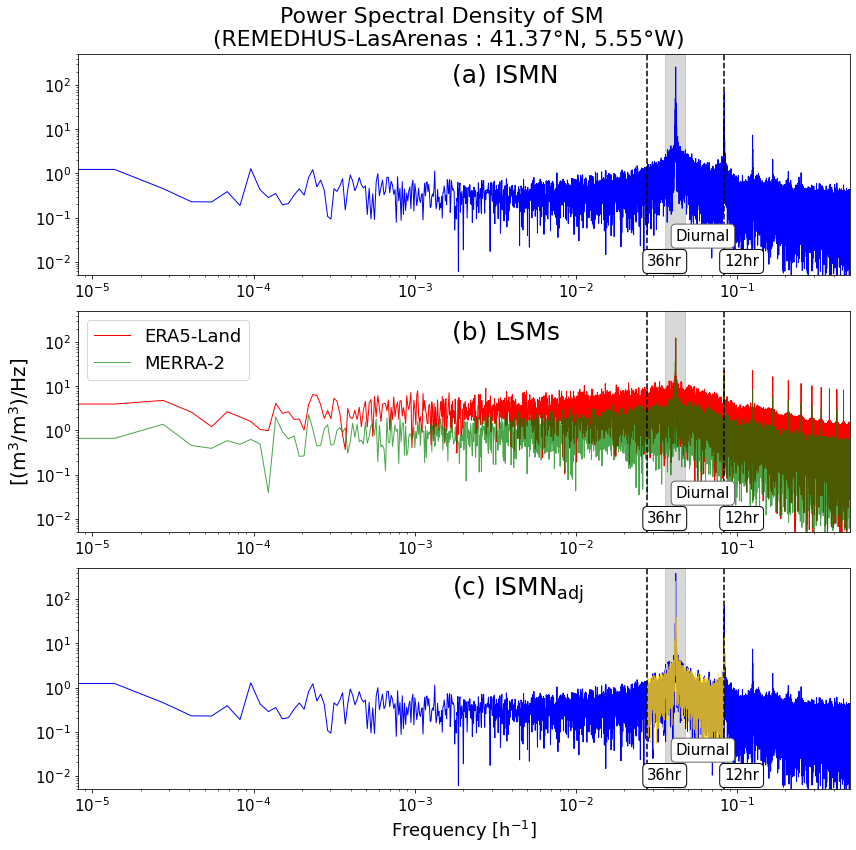

In [1915]:
fig,axs=plt.subplots(3,1,figsize=(12,12))
fig.set_facecolor('white')
axs[0].plot(freq_ISMN_ano[:len(freq_ISMN_ano)//2], ps_ISMN_ano[:len(freq_ISMN_ano)//2],c='b',linewidth=1)
# axs[0].axvline(1/24, color='gray', linestyle='--',linewidth=1.5,alpha=1) 
axs[0].axvspan(1/21,1/28, color='gray', alpha=0.3)
axs[0].axvline(1/12, color='k', linestyle='--',linewidth=1.5,alpha=1) 
axs[0].axvline(1/36, color='k', linestyle='--',linewidth=1.5,alpha=1) 
axs[0].text(1/24,0.03,'Diurnal',bbox=bbox_props, fontsize=15)
axs[0].text(1/36,0.008,'36hr',bbox=bbox_props2, fontsize=15)
axs[0].text(1/12,0.008,'12hr',bbox=bbox_props2, fontsize=15)
axs[0].set_yscale('log')
axs[0].set_xscale('log')
# axs[0].set_title('(a) ISMN',fontsize=24,pad=10)
# axs[0].set_xlabel('Frequency [Hz]')
# axs[0].set_ylabel('[(m$^3$/m$^3$)/Hz]',fontsize=20)
axs[0].set_ylim(0.005,500)
axs[0].set_xlim(0,np.max(freq_ISMN_ano))
axs[0].tick_params(axis='both', labelsize=15)
axs[0].text(0.0017,120,'(a) ISMN',fontsize=25)

axs[1].plot(freq_ERA_ano[:len(freq_ERA_ano)//2], ps_ERA_ano[:len(freq_ERA_ano)//2],c='r',linewidth=1,label='ERA5-Land')
axs[1].plot(freq_MERRA_ano[:len(freq_MERRA_ano)//2], ps_MERRA_ano[:len(freq_MERRA_ano)//2],c='g',linewidth=1,alpha=0.7,label='MERRA-2')
# axs[1].axvline(1/24, color='gray', linestyle='--',linewidth=1.5,alpha=1) 
axs[1].axvspan(1/21,1/28, color='gray', alpha=0.3)
axs[1].axvline(1/12, color='k', linestyle='--',linewidth=1.5,alpha=1) 
axs[1].axvline(1/36, color='k', linestyle='--',linewidth=1.5,alpha=1) 
axs[1].text(1/24,0.03,'Diurnal',bbox=bbox_props, fontsize=15)
axs[1].text(1/36,0.008,'36hr',bbox=bbox_props2, fontsize=15)
axs[1].text(1/12,0.008,'12hr',bbox=bbox_props2, fontsize=15)
axs[1].set_yscale('log')
axs[1].set_xscale('log')
# axs[1].set_title('(b) LSMs',fontsize=24,pad=10)
# axs[1].set_xlabel('Frequency [h$^{-1}$]',fontsize=18)
axs[1].set_ylabel('[(m$^3$/m$^3$)/Hz]',fontsize=20)
axs[1].legend(loc='upper left', fontsize=18)
# axs[1].yaxis.set_visible(False)
axs[1].set_ylim(0.005,500)
axs[1].set_xlim(0,np.max(freq_ISMN_ano))
axs[1].tick_params(axis='both', labelsize=15)
axs[1].text(0.0017,120,'(b) LSMs',fontsize=25)

axs[2].plot(freq_ISMN_ano[:len(freq_ISMN_ano)//2], ps_ano_adj_all[:len(freq_ISMN_ano)//2],c='b',linewidth=1)
axs[2].plot(freq_ISMN_ano[:len(freq_ISMN_ano)//2], ps_t[:len(freq_ISMN_ano)//2],c='gold',linewidth=0.5,alpha=0.8)
# axs[2].axvline(1/24, color='gray', linestyle='--',linewidth=1.5,alpha=1) 
axs[2].axvspan(1/21,1/28, color='gray', alpha=0.3)
axs[2].axvline(1/12, color='k', linestyle='--',linewidth=1.5,alpha=1) 
axs[2].axvline(1/36, color='k', linestyle='--',linewidth=1.5,alpha=1) 
axs[2].text(1/24,0.03,'Diurnal',bbox=bbox_props, fontsize=15)
axs[2].text(1/36,0.008,'36hr',bbox=bbox_props2, fontsize=15)
axs[2].text(1/12,0.008,'12hr',bbox=bbox_props2, fontsize=15)
axs[2].set_yscale('log')
axs[2].set_xscale('log')
# axs[2].set_title(r'(c) ISMN$_{\text{adj}}$', fontsize=24,pad=5)
axs[2].set_xlabel('Frequency [h$^{-1}$]',fontsize=18)
# axs[2].set_ylabel('[(m$^3$/m$^3$)/Hz]',fontsize=20)
# axs[2].yaxis.set_visible(False)
axs[2].set_ylim(0.005,500)
axs[2].set_xlim(0,np.max(freq_ISMN_ano))
axs[2].tick_params(axis='both', labelsize=15)
axs[2].text(0.0017,120,r'(c) ISMN$_{\text{adj}}$',fontsize=25)

plt.suptitle(f'Power Spectral Density of SM \n ({net_ex}-{st_ex} : {round(lat_ex,2)}°N, {-round(lon_ex,2)}°W)',fontsize=22,x=0.52,y=.98)
plt.tight_layout()
plt.savefig(fname+'figure 3 power spectrum example 31', dpi=600, bbox_inches = 'tight', pad_inches = 0.02)
plt.show()

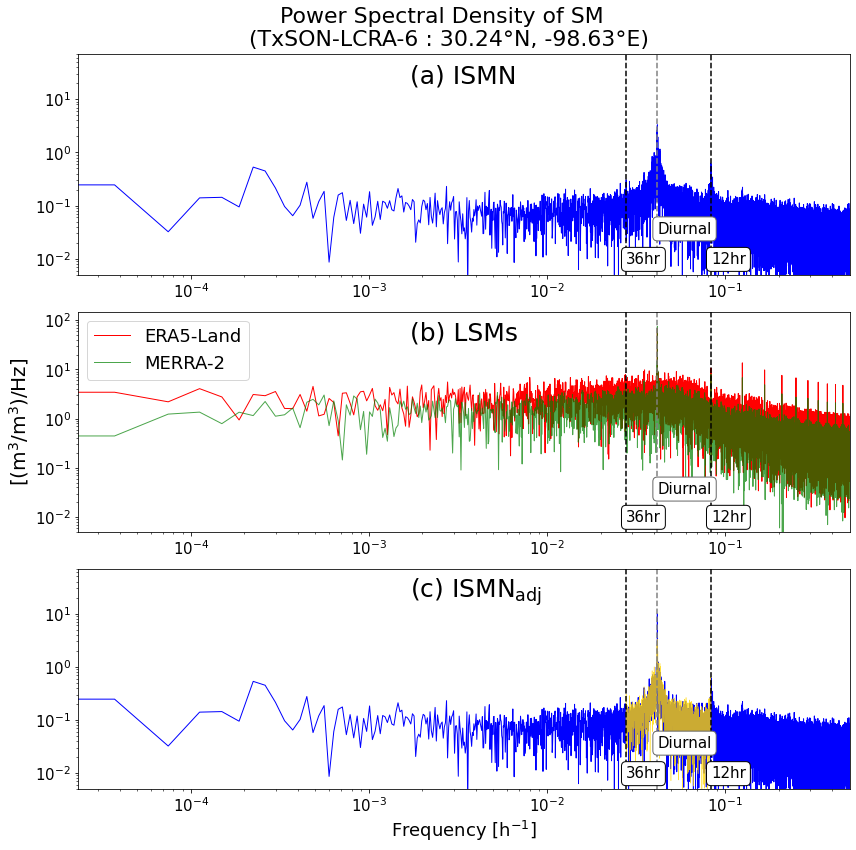

In [1407]:
fig,axs=plt.subplots(3,1,figsize=(12,12))
fig.set_facecolor('white')
axs[0].plot(freq_ISMN_ano[:len(freq_ISMN_ano)//2], ps_ISMN_ano[:len(freq_ISMN_ano)//2],c='b',linewidth=1)
axs[0].axvline(1/24, color='gray', linestyle='--',linewidth=1.5,alpha=1) 
axs[0].axvline(1/12, color='k', linestyle='--',linewidth=1.5,alpha=1) 
axs[0].axvline(1/36, color='k', linestyle='--',linewidth=1.5,alpha=1) 
axs[0].text(1/24,0.03,'Diurnal',bbox=bbox_props, fontsize=15)
axs[0].text(1/36,0.008,'36hr',bbox=bbox_props2, fontsize=15)
axs[0].text(1/12,0.008,'12hr',bbox=bbox_props2, fontsize=15)
axs[0].set_yscale('log')
axs[0].set_xscale('log')
# axs[0].set_title('(a) ISMN',fontsize=24,pad=10)
# axs[0].set_xlabel('Frequency [Hz]')
# axs[0].set_ylabel('[(m$^3$/m$^3$)/Hz]',fontsize=20)
axs[0].set_ylim(0.005,70)
axs[0].set_xlim(0,np.max(freq_ISMN_ano))
axs[0].tick_params(axis='both', labelsize=15)
axs[0].text(0.0017,20,'(a) ISMN',fontsize=25)

axs[1].plot(freq_ERA_ano[:len(freq_ERA_ano)//2], ps_ERA_ano[:len(freq_ERA_ano)//2],c='r',linewidth=1,label='ERA5-Land')
axs[1].plot(freq_MERRA_ano[:len(freq_MERRA_ano)//2], ps_MERRA_ano[:len(freq_MERRA_ano)//2],c='g',linewidth=1,alpha=0.7,label='MERRA-2')
axs[1].axvline(1/24, color='gray', linestyle='--',linewidth=1.5,alpha=1) 
axs[1].axvline(1/12, color='k', linestyle='--',linewidth=1.5,alpha=1) 
axs[1].axvline(1/36, color='k', linestyle='--',linewidth=1.5,alpha=1) 
axs[1].text(1/24,0.03,'Diurnal',bbox=bbox_props, fontsize=15)
axs[1].text(1/36,0.008,'36hr',bbox=bbox_props2, fontsize=15)
axs[1].text(1/12,0.008,'12hr',bbox=bbox_props2, fontsize=15)
axs[1].set_yscale('log')
axs[1].set_xscale('log')
# axs[1].set_title('(b) LSMs',fontsize=24,pad=10)
# axs[1].set_xlabel('Frequency [h$^{-1}$]',fontsize=18)
axs[1].set_ylabel('[(m$^3$/m$^3$)/Hz]',fontsize=20)
axs[1].legend(loc='upper left', fontsize=18)
# axs[1].yaxis.set_visible(False)
axs[1].set_ylim(0.005,150)
axs[1].set_xlim(0,np.max(freq_ISMN_ano))
axs[1].tick_params(axis='both', labelsize=15)
axs[1].text(0.0017,40,'(b) LSMs',fontsize=25)

axs[2].plot(freq_ISMN_ano[:len(freq_ISMN_ano)//2], ps_ano_adj_all[:len(freq_ISMN_ano)//2],c='b',linewidth=1)
axs[2].plot(freq_ISMN_ano[:len(freq_ISMN_ano)//2], ps_t[:len(freq_ISMN_ano)//2],c='gold',linewidth=0.5,alpha=0.8)
axs[2].axvline(1/24, color='gray', linestyle='--',linewidth=1.5,alpha=1) 
axs[2].axvline(1/12, color='k', linestyle='--',linewidth=1.5,alpha=1) 
axs[2].axvline(1/36, color='k', linestyle='--',linewidth=1.5,alpha=1) 
axs[2].text(1/24,0.03,'Diurnal',bbox=bbox_props, fontsize=15)
axs[2].text(1/36,0.008,'36hr',bbox=bbox_props2, fontsize=15)
axs[2].text(1/12,0.008,'12hr',bbox=bbox_props2, fontsize=15)
axs[2].set_yscale('log')
axs[2].set_xscale('log')
# axs[2].set_title(r'(c) ISMN$_{\text{adj}}$', fontsize=24,pad=5)
axs[2].set_xlabel('Frequency [h$^{-1}$]',fontsize=18)
# axs[2].set_ylabel('[(m$^3$/m$^3$)/Hz]',fontsize=20)
# axs[2].yaxis.set_visible(False)
axs[2].set_ylim(0.005,70)
axs[2].set_xlim(0,np.max(freq_ISMN_ano))
axs[2].tick_params(axis='both', labelsize=15)
axs[2].text(0.0017,20,r'(c) ISMN$_{\text{adj}}$',fontsize=25)

plt.suptitle(f'Power Spectral Density of SM \n ({net_ex}-{st_ex} : {round(lat_ex,2)}°N, {round(lon_ex,2)}°E)',fontsize=22,x=0.52,y=.98)
plt.tight_layout()
plt.savefig(fname+'figure 3 power spectrum example 31', dpi=600, bbox_inches = 'tight', pad_inches = 0.02)
plt.show()

# Figure 4

## data

In [1347]:
ISMN_sm=sorted(glob.glob('/home/jnhan/python/power spectrum/data/final filter/sm/ISMN_filter/*.csv'))
data_path = "/home/jnhan/ISMN/Data_separate_files_header_19500101_20231108_10201_8KK1_20231108.zip"
ismn_data = ISMN_Interface(data_path)

Found existing ismn metadata in /home/jnhan/ISMN/python_metadata/Data_separate_files_header_19500101_20231108_10201_8KK1_20231108.csv.


WARNING - 2025-06-12 21:34:15,334: Sensor already exists: Hydraprobe-Digital-Sdi-12-Thermistor-(linear)_soil_temperature_1.524000_1.524000
WARNING - 2025-06-12 21:34:15,334: Sensor already exists: Hydraprobe-Digital-Sdi-12-(2.5-Volt)_soil_temperature_1.524000_1.524000


In [1613]:
ISMN_sm[524]

'/home/jnhan/python/power spectrum/data/final filter/sm/ISMN_filter/REMEDHUS_LasArenas_sm.csv'

In [1624]:
t=ismn_data.get_dataset_ids('soil_moisture', min_depth=0.0, max_depth=0.1,groupby='station')

In [1625]:
t['LasArenas']

[7974]

In [1917]:
ISMN_sm_f=pd.read_csv(ISMN_sm[524],index_col='date_time',parse_dates=['date_time'])
ISMN_net=ISMN_sm_f.network[0]
ISMN_st=ISMN_sm_f.station[0]
ISMN_lat=ISMN_sm_f.latitude[0]
ISMN_lon=ISMN_sm_f.longitude[0]

ISMN_sm_ori=ismn_data.read(7974)
ISMN_sm_ori=ISMN_sm_ori[ISMN_sm_ori['soil_moisture_flag']=='G']
ISMN_sm_ori=LST(ISMN_sm_ori,ISMN_sm_f.longitude[0])
ISMN_sm_ori=ISMN_sm_ori[['soil_moisture']]
ISMN_sm_ori['running mean']=ISMN_sm_ori['soil_moisture'].rolling(window=24,center=True,min_periods=1).mean()
ISMN_sm_ori['anomaly']=ISMN_sm_ori['soil_moisture']-ISMN_sm_ori['soil_moisture'].rolling(window=24,center=True,min_periods=1).mean()

# remove precipitation
ISMN_D=ISMN_sm_ori.resample('D').mean()

dS=[]
for j in range(len(ISMN_D)-1):
    dS.append(ISMN_D['soil_moisture'][j+1]-ISMN_D['soil_moisture'][j])

drop_idx=np.append(np.where(dS>=(0.5*np.nanstd(dS)))[0],np.where(dS>=(0.5*np.nanstd(dS)))[0]+1)

ISMN_sm_premove=ISMN_sm_ori.copy()
ISMN_sm_premove=ISMN_sm_premove.drop(ISMN_sm_premove.index[ISMN_sm_premove.index.isin(pd.DatetimeIndex([date for i in ISMN_D.index[drop_idx] for date in pd.date_range(f'{i}',periods=24,freq='H')]))])

In [1918]:
ISMN=pd.read_csv(ISMN_sm[524],usecols={'date_time','soil_moisture','anomaly','rm'},index_col='date_time',parse_dates=['date_time'])
# ISMN=ISMN_sm_premove
ERA=pd.read_csv(ERA_data[524],usecols={'date_time','sm','sm ano'},index_col='date_time',parse_dates=['date_time'])
MERRA=pd.read_csv(MERRA_data[524],usecols={'date_time','sm','sm ano'},index_col='date_time',parse_dates=['date_time'])
ts_ISMN=pd.read_csv(ISMN_ts[524],usecols={'date_time','soil_temperature','anomaly'},index_col='date_time',parse_dates=['date_time'])

ISMN.rename(columns={'soil_moisture':'ISMN sm','anomaly':'ISMN sm ano'},inplace=True)
ERA.rename(columns={'sm':'ERA sm','sm ano':'ERA sm ano'},inplace=True)
MERRA.rename(columns={'sm':'MERRA sm','sm ano':'MERRA sm ano'},inplace=True)
ts_ISMN.rename(columns={'soil_temperature':'ISMN ts','anomaly':'ISMN ts ano'},inplace=True)

merged =ISMN.merge(ERA, left_index=True, right_index=True, how='inner')
merged =merged.merge(MERRA, left_index=True, right_index=True, how='inner')
merged =merged.merge(ts_ISMN, left_index=True, right_index=True, how='inner')
merged =merged.dropna()

fft_ISMN_ano=np.fft.fft(merged['ISMN sm ano'])
ps_ISMN_ano=np.abs(fft_ISMN_ano)
freq_ISMN_ano=np.fft.fftfreq(len(merged),d=1.0/len(fft_ISMN_ano))

fft_ERA_ano=np.fft.fft(merged['ERA sm ano'])
ps_ERA_ano=np.abs(fft_ERA_ano)
freq_ERA_ano=np.fft.fftfreq(len(merged),d=1.0/len(fft_ERA_ano))

fft_MERRA_ano=np.fft.fft(merged['MERRA sm ano'])
ps_MERRA_ano=np.abs(fft_MERRA_ano)
freq_MERRA_ano=np.fft.fftfreq(len(merged),d=1.0/len(fft_MERRA_ano))

ISMN_freq_24=int(len(freq_ISMN_ano)/24)
ERA_freq_24=int(len(freq_ERA_ano)/24)
MERRA_freq_24=int(len(freq_MERRA_ano)/24)

ISMN_freq_36=int(len(freq_ISMN_ano)/36)
ERA_freq_36=int(len(freq_ERA_ano)/36)
MERRA_freq_36=int(len(freq_MERRA_ano)/36)

ISMN_freq_12=int(len(freq_ISMN_ano)/12)
ERA_freq_12=int(len(freq_ERA_ano)/12)
MERRA_freq_12=int(len(freq_MERRA_ano)/12)

df=pd.DataFrame()
df['fft_ISMN_r']=fft_ISMN_ano.real
df['fft_ERA_r']=fft_ERA_ano.real
df['fft_MERRA_r']=fft_MERRA_ano.real
df['fft_m_r']=((0.5*df['fft_ERA_r'])+(0.5*df['fft_MERRA_r']))
df['fft_ISMN_i']=fft_ISMN_ano.imag
df['fft_ERA_i']=fft_ERA_ano.imag
df['fft_MERRA_i']=fft_MERRA_ano.imag
df['fft_m_i']=((0.5*df['fft_ERA_i'])+(0.5*df['fft_MERRA_i']))
df['ps_ISMN']=ps_ISMN_ano
df['ps_ERA']=ps_ERA_ano
df['ps_MERRA']=ps_MERRA_ano
df['ps_m']=((0.5*df['ps_ERA'])+(0.5*df['ps_MERRA']))

# mv=df.rolling(window=100,center=True,min_periods=1).mean()

sf_E=df['ps_ISMN']/df['ps_ERA']
sf_M=df['ps_ISMN']/df['ps_MERRA']
sf_all=df['ps_ISMN']/df['ps_m']

fft_r_E=sf_E*df['fft_ERA_r']
fft_i_E=sf_E*df['fft_ERA_i']
fft_r_M=sf_M*df['fft_MERRA_r']
fft_i_M=sf_M*df['fft_MERRA_i']
fft_r_all=sf_all*df['fft_m_r']
fft_i_all=sf_all*df['fft_m_i']

fft_resc_E=fft_r_E+fft_i_E*1j
fft_resc_M=fft_r_M+fft_i_M*1j
fft_resc_all=fft_r_all+fft_i_all*1j

fft_ISMN_adj_E=fft_ISMN_ano.copy()
fft_ISMN_adj_M=fft_ISMN_ano.copy()
fft_ISMN_adj_all=fft_ISMN_ano.copy()

fft_ISMN_adj_E[ISMN_freq_36:ISMN_freq_12]=fft_resc_E[ISMN_freq_36:ISMN_freq_12]
fft_ISMN_adj_E[-ISMN_freq_12:-ISMN_freq_36]=fft_resc_E[-ISMN_freq_12:-ISMN_freq_36]
fft_ISMN_adj_M[ISMN_freq_36:ISMN_freq_12]=fft_resc_M[ISMN_freq_36:ISMN_freq_12]
fft_ISMN_adj_M[-ISMN_freq_12:-ISMN_freq_36]=fft_resc_M[-ISMN_freq_12:-ISMN_freq_36]
fft_ISMN_adj_all[ISMN_freq_36:ISMN_freq_12]=fft_resc_all[ISMN_freq_36:ISMN_freq_12]
fft_ISMN_adj_all[-ISMN_freq_12:-ISMN_freq_36]=fft_resc_all[-ISMN_freq_12:-ISMN_freq_36]

ifft_ISMN_E=np.fft.ifft(fft_ISMN_adj_E)
ifft_ISMN_real_E=ifft_ISMN_E.real
ifft_ISMN_M=np.fft.ifft(fft_ISMN_adj_M)
ifft_ISMN_real_M=ifft_ISMN_M.real
ifft_ISMN_all=np.fft.ifft(fft_ISMN_adj_all)
ifft_ISMN_real_all=ifft_ISMN_all.real

merged['adj_E']=ifft_ISMN_real_E
merged['adj_M']=ifft_ISMN_real_M
merged['adj_all']=ifft_ISMN_real_all

hourly=merged.groupby(merged.index.hour).mean()
night=hourly.loc[list(range(7))+list(range(20,24))]
hourly['night_adj']=hourly[['adj_all']]-(night['adj_all'].mean()-night['ISMN sm ano'].mean())

In [1919]:
date=pd.date_range(start='2006-05-01',end='2006-05-16',freq='1H')
date=pd.DataFrame(index=date)

ISMN_sm_ori=date.join(ISMN_sm_ori)
ISMN_sm_premove=date.join(ISMN_sm_premove)
merged=date.join(merged)

In [1824]:
hourly['LSMs'] = (
    hourly['ERA sm ano'].values * 0.5 +
    hourly['MERRA sm ano'].values * 0.5
)

In [1825]:
hourly_reindex=pd.concat([hourly[20:],hourly[:20]])

In [1826]:
hourly_t=hourly.copy()

In [1827]:
hourly_t['hour']=hourly_t.index
new_order = list(range(20, 24)) + list(range(0, 20))
hourly_reindex = hourly_t.set_index('hour').loc[new_order]

In [1828]:
x = list(range(24))
xtick_labels = [str(h) for h in list(range(20, 24)) + list(range(0, 20))]

In [1829]:
ISMN_mean_n = night['ISMN sm ano'].mean()

In [1281]:
ERA_v,MERRA_v=(0.5, 0.5)
lat=[]
lon=[]
mean_corrected_ratio=[]
bn_lat=[]
bn_lon=[]
bn_mean_corrected_ratio=[]
before_noon=[]
error=[]
low_len=[]
idx=[]
bn_idx=[]
m_len=[]
bn_m_len=[]
for i in range(len(ISMN_sm)):
    print(i,end='\r')
    try:
        ISMN=pd.read_csv(ISMN_sm[i],usecols={'date_time','soil_moisture','flag','anomaly','rm'},index_col='date_time',parse_dates=['date_time'])
        ERA=pd.read_csv(ERA_data[i],usecols={'date_time','sm','sm ano','ts','ts ano'},index_col='date_time',parse_dates=['date_time'])
        MERRA=pd.read_csv(MERRA_data[i],usecols={'date_time','sm','sm ano','ts','ts ano'},index_col='date_time',parse_dates=['date_time'])
        ts_ISMN=pd.read_csv(ISMN_ts[i],usecols={'date_time','soil_temperature','flag','anomaly'},index_col='date_time',parse_dates=['date_time'])
        ISMN2=pd.read_csv(ISMN_sm[i])
        
        ISMN=ISMN[ISMN['flag']=='G']
        ts_ISMN=ts_ISMN[ts_ISMN['flag']=='G']
        ISMN=ISMN[['soil_moisture','anomaly','rm']]
        ts_ISMN=ts_ISMN[['soil_temperature','anomaly']]
        
        ISMN.rename(columns={'soil_moisture':'ISMN sm','anomaly':'ISMN sm ano','rm':'ISMN rm'},inplace=True)
        ERA.rename(columns={'sm':'ERA sm','sm ano':'ERA sm ano','ts':'ERA ts','ts ano':'ERA ts ano'},inplace=True)
        MERRA.rename(columns={'sm':'MERRA sm','sm ano':'MERRA sm ano','ts':'MERRA ts','ts ano':'MERRA ts ano'},inplace=True)
        ts_ISMN.rename(columns={'soil_temperature':'ISMN ts','anomaly':'ISMN ts ano'},inplace=True)
        
        merged = ISMN.merge(ERA, left_index=True, right_index=True, how='inner')
        merged = merged.merge(MERRA, left_index=True, right_index=True, how='inner')
        merged = merged.merge(ts_ISMN, left_index=True, right_index=True, how='inner')
        merged = merged.dropna()

        if len(merged) > 2200:
            'ㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡ'
            'anomaly'
            fft_ISMN_ano=np.fft.fft(merged['ISMN sm ano'])
            ps_ISMN_ano=np.abs(fft_ISMN_ano)
            freq_ISMN_ano=np.fft.fftfreq(len(merged),d=1.0/len(fft_ISMN_ano))
            
            fft_ERA_ano=np.fft.fft(merged['ERA sm ano'])
            ps_ERA_ano=np.abs(fft_ERA_ano)
            freq_ERA_ano=np.fft.fftfreq(len(merged),d=1.0/len(fft_ERA_ano))
            
            fft_MERRA_ano=np.fft.fft(merged['MERRA sm ano'])
            ps_MERRA_ano=np.abs(fft_MERRA_ano)
            freq_MERRA_ano=np.fft.fftfreq(len(merged),d=1.0/len(fft_MERRA_ano))
            
            freq_24=int(len(freq_ISMN_ano)/24)
            freq_36=int(len(freq_ISMN_ano)/36)
            freq_12=int(len(freq_ISMN_ano)/12)
            
            # ISMN_freq_24=int(len(freq_ISMN_ano)/24)
            # ERA_freq_24=int(len(freq_ERA_ano)/24)
            # MERRA_freq_24=int(len(freq_MERRA_ano)/24)
            
            # ISMN_freq_36=int(len(freq_ISMN_ano)/36)
            # ERA_freq_36=int(len(freq_ERA_ano)/36)
            # MERRA_freq_36=int(len(freq_MERRA_ano)/36)
            
            # ISMN_freq_10=int(len(freq_ISMN_ano)/12)
            # ERA_freq_10=int(len(freq_ERA_ano)/12)
            # MERRA_freq_10=int(len(freq_MERRA_ano)/12)
            
            df_ano=pd.DataFrame()
            df_ano['fft_ISMN_r']=fft_ISMN_ano.real
            df_ano['fft_ERA_r']=fft_ERA_ano.real
            df_ano['fft_MERRA_r']=fft_MERRA_ano.real
            df_ano['fft_m_r']=((ERA_v*df_ano['fft_ERA_r'])+(MERRA_v*df_ano['fft_MERRA_r']))
            df_ano['fft_ISMN_i']=fft_ISMN_ano.imag
            df_ano['fft_ERA_i']=fft_ERA_ano.imag
            df_ano['fft_MERRA_i']=fft_MERRA_ano.imag
            df_ano['fft_m_i']=((ERA_v*df_ano['fft_ERA_i'])+(MERRA_v*df_ano['fft_MERRA_i']))
            df_ano['ps_ISMN']=ps_ISMN_ano
            df_ano['ps_ERA']=ps_ERA_ano
            df_ano['ps_MERRA']=ps_MERRA_ano
            df_ano['ps_m']=((ERA_v*df_ano['ps_ERA'])+(MERRA_v*df_ano['ps_MERRA']))

            mv=df_ano.rolling(window=24,center=True).mean()
            sf_ano_E=mv['ps_ISMN']/mv['ps_ERA']
            sf_ano_M=mv['ps_ISMN']/mv['ps_MERRA']
            sf_ano_all=mv['ps_ISMN']/mv['ps_m']
            
            fft_ano_r_E=sf_ano_E*df_ano['fft_ERA_r']
            fft_ano_i_E=sf_ano_E*df_ano['fft_ERA_i']
            fft_ano_r_M=sf_ano_M*df_ano['fft_MERRA_r']
            fft_ano_i_M=sf_ano_M*df_ano['fft_MERRA_i']
            fft_ano_r_all=sf_ano_all*df_ano['fft_m_r']
            fft_ano_i_all=sf_ano_all*df_ano['fft_m_i']
            
            fft_ano_resc_E=fft_ano_r_E+fft_ano_i_E*1j
            fft_ano_resc_M=fft_ano_r_M+fft_ano_i_M*1j
            fft_ano_resc_all=fft_ano_r_all+fft_ano_i_all*1j
            
            fft_ISMN_adj_ano_E=fft_ISMN_ano.copy()
            fft_ISMN_adj_ano_M=fft_ISMN_ano.copy()
            fft_ISMN_adj_ano_all=fft_ISMN_ano.copy()
            
            fft_ISMN_adj_ano_E[freq_36:freq_12]=fft_ano_resc_E[freq_36:freq_12]
            fft_ISMN_adj_ano_E[-freq_12:-freq_36]=fft_ano_resc_E[-freq_12:-freq_36]
            fft_ISMN_adj_ano_M[freq_36:freq_12]=fft_ano_resc_M[freq_36:freq_12]
            fft_ISMN_adj_ano_M[-freq_12:-freq_36]=fft_ano_resc_M[-freq_12:-freq_36]
            fft_ISMN_adj_ano_all[freq_36:freq_12]=fft_ano_resc_all[freq_36:freq_12]
            fft_ISMN_adj_ano_all[-freq_12:-freq_36]=fft_ano_resc_all[-freq_12:-freq_36]
            
            ps_ano_adj_E=np.abs(fft_ISMN_adj_ano_E)
            ps_ano_adj_M=np.abs(fft_ISMN_adj_ano_M)
            ps_ano_adj_all=np.abs(fft_ISMN_adj_ano_all)
            
            ifft_ISMN_ano_E=np.fft.ifft(fft_ISMN_adj_ano_E)
            ifft_ISMN_ano_real_E=ifft_ISMN_ano_E.real
            ifft_ISMN_ano_M=np.fft.ifft(fft_ISMN_adj_ano_M)
            ifft_ISMN_ano_real_M=ifft_ISMN_ano_M.real
            ifft_ISMN_ano_all=np.fft.ifft(fft_ISMN_adj_ano_all)
            ifft_ISMN_ano_real_all=ifft_ISMN_ano_all.real
            
            merged['ano_adj_E']=ifft_ISMN_ano_real_E
            merged['ano_adj_M']=ifft_ISMN_ano_real_M
            merged['ano_adj_all']=ifft_ISMN_ano_real_all
            
            hourly=merged.groupby(merged.index.hour).mean()
            
            night=hourly.loc[list(range(7))+list(range(20,24))]

            mean_correction_ERA=night['ano_adj_E'].mean()-night['ISMN sm ano'].mean()
            mean_correction_MERRA=night['ano_adj_M'].mean()-night['ISMN sm ano'].mean()
            mean_correction_all=night['ano_adj_all'].mean()-night['ISMN sm ano'].mean()
            hourly['night_adj_E']=hourly[['ano_adj_E']]-(night['ano_adj_E'].mean()-night['ISMN sm ano'].mean())
            hourly['night_adj_M']=hourly[['ano_adj_M']]-(night['ano_adj_M'].mean()-night['ISMN sm ano'].mean())
            hourly['night_adj']=hourly[['ano_adj_all']]-(night['ano_adj_all'].mean()-night['ISMN sm ano'].mean())
        
            tt=pd.DataFrame()
            tt['reconst_E']=merged['ano_adj_E']+merged['ISMN rm']-mean_correction_ERA
            tt['reconst_M']=merged['ano_adj_M']+merged['ISMN rm']-mean_correction_MERRA
            tt['reconst_all']=merged['ano_adj_all']+merged['ISMN rm']-mean_correction_all
            if (np.argmax(hourly['ISMN sm ano']) >= 12):
                lat.append(ISMN2.latitude[0])
                lon.append(ISMN2.longitude[0])
                mean_corrected_ratio.append((hourly['night_adj'].mean()-hourly['ano_adj_all'].mean())/hourly['ISMN sm'].mean())   # night_adj 
                idx.append(i)
                m_len.append(len(merged))
            else : 
                bn_lat.append(ISMN2.latitude[0])
                bn_lon.append(ISMN2.longitude[0])
                bn_mean_corrected_ratio.append((hourly['night_adj'].mean()-hourly['ano_adj_all'].mean())/hourly['ISMN sm'].mean())   # night_adj 
                bn_idx.append(i)
                bn_m_len.append(len(merged))
            del night,hourly
        else:
            low_len.append(i)
    except Exception as e:
        error.append((i,e))

In [1282]:
lat_all=lat+bn_lat
lon_all=lon+bn_lon
mean_corrected_ratio_all=mean_corrected_ratio+bn_mean_corrected_ratio
mean_corrected_ratio_all=[i*100 for i in mean_corrected_ratio_all]

## plot

In [1860]:
P_idx[-25]

Timestamp('2006-05-05 23:00:00')

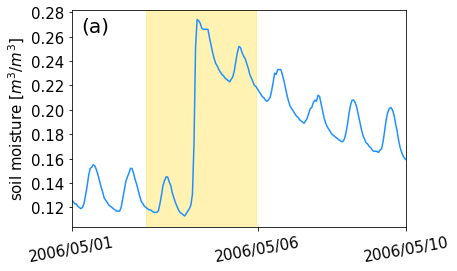

In [1883]:
fig=plt.figure(figsize=(6,4))
fig.set_facecolor('white')

plt.plot(ISMN_sm_ori.index,ISMN_sm_ori['soil_moisture'],c='dodgerblue')#,label='ori')

P_idx=ISMN_sm_ori.index[~ISMN_sm_ori.index.isin(ISMN_sm_premove.dropna().index)]

plt.axvspan(P_idx[0], P_idx[-25], color='gold', alpha=0.3, label='Precipitation Period')
plt.ylabel('soil moisture [$m^3$/$m^3$]',fontsize=15)
ax = plt.gca()  
xticks = [datetime(2006, 5, 1), 
          datetime(2006, 5, 6), 
          datetime(2006, 5, 10)]
ax.set_xticks(xticks)
ax.set_xticklabels(ax.get_xticklabels(), rotation=10)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y/%m/%d'))
ax.set_xlim([xticks[0],xticks[-1]])
ax.text(0.03, 0.9, '(a)', fontsize=20, transform=ax.transAxes)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.savefig(fname+'figure 4 p_remove2', dpi=600, bbox_inches = 'tight', pad_inches = 0.02)
plt.show()

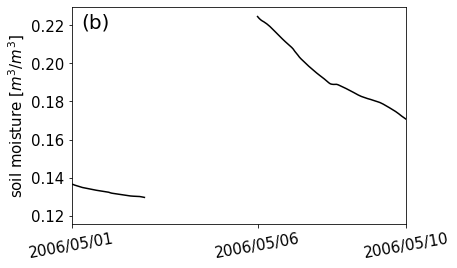

In [1888]:
fig=plt.figure(figsize=(6,4))
fig.set_facecolor('white')

plt.plot(ISMN_sm_premove.index,ISMN_sm_premove['running mean'],c='k',linestyle='-')#,label='running mean')
plt.ylabel('soil moisture [$m^3$/$m^3$]',fontsize=15)
ax = plt.gca()  
ax.set_xticks(xticks)
ax.set_xticklabels(ax.get_xticklabels(), rotation=10)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y/%m/%d'))
ax.set_xlim([xticks[0],xticks[-1]])
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
# plt.ylim(.17,.28)
# ax.set_yticks([0.18,0.23,0.28])
ax.text(0.03, 0.9, '(b)', fontsize=20, transform=ax.transAxes)
plt.savefig(fname+'figure 4 rm2', dpi=600, bbox_inches = 'tight', pad_inches = 0.02)
plt.show()

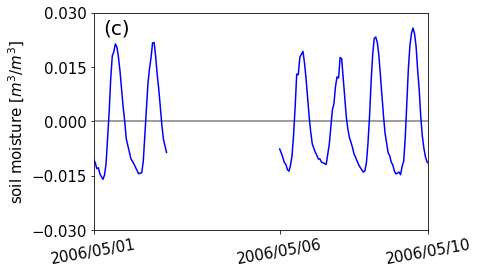

In [1889]:
fig=plt.figure(figsize=(6,4))
fig.set_facecolor('white')

plt.axhline(0, linewidth=1.5, c='gray')
plt.plot(ISMN_sm_premove.index,ISMN_sm_premove['anomaly'],c='b')
plt.ylabel('soil moisture [$m^3$/$m^3$]',fontsize=15)
ax = plt.gca()  
ax.set_xticks(xticks)
ax.set_xticklabels(ax.get_xticklabels(), rotation=10)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y/%m/%d'))
ax.set_xlim([xticks[0],xticks[-1]])
plt.xticks(fontsize=15)
plt.yticks([-0.03,-0.015,0,0.015,0.03],fontsize=15)
plt.ylim(-0.03,0.03)
ax.text(0.03, 0.9, '(c)', fontsize=20, transform=ax.transAxes)
plt.savefig(fname+'figure 4 anomaly2', dpi=600, bbox_inches = 'tight', pad_inches = 0.02)
plt.show()

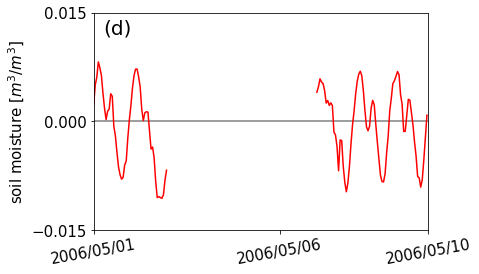

In [1894]:
fig=plt.figure(figsize=(6,4))
fig.set_facecolor('white')

plt.axhline(0, linewidth=1.5, c='gray')
plt.plot(merged.index,merged['adj_all'],c='r')
plt.ylabel('soil moisture [$m^3$/$m^3$]',fontsize=15)
ax = plt.gca()  
ax.set_xticks(xticks)
ax.set_xticklabels(ax.get_xticklabels(), rotation=10)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y/%m/%d'))
plt.xticks(fontsize=15)
ax.set_xlim([xticks[0],xticks[-1]])
plt.yticks([-0.03,-0.015,0,0.015,0.03],fontsize=15)
plt.ylim(-0.015,0.015)
ax.text(0.03, 0.9, '(d)', fontsize=20, transform=ax.transAxes)
plt.savefig(fname+'figure 4 adj anomaly2', dpi=600, bbox_inches = 'tight', pad_inches = 0.02)
plt.show()

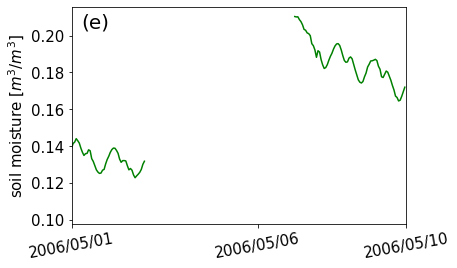

In [1920]:
fig=plt.figure(figsize=(6,4))
fig.set_facecolor('white')

plt.plot(merged.index,merged['adj_all']+merged['rm'],c='g')
plt.ylabel('soil moisture [$m^3$/$m^3$]',fontsize=15)
ax = plt.gca()  
ax.set_xticks(xticks)
ax.set_xticklabels(ax.get_xticklabels(), rotation=10)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y/%m/%d'))
ax.set_xlim([xticks[0],xticks[-1]])
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
# plt.ylim(.17,.28)
ax.text(0.03, 0.9, '(e)', fontsize=20, transform=ax.transAxes)
plt.savefig(fname+'figure 4 reconstruct2', dpi=600, bbox_inches = 'tight', pad_inches = 0.02)
plt.show()

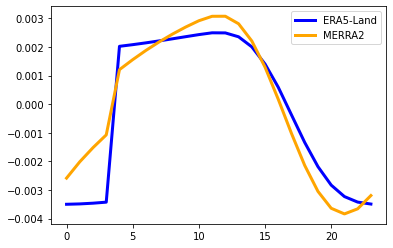

In [1904]:
plt.plot(x,hourly_reindex['ERA sm ano'],label='ERA5-Land',c='b',linewidth=3)
plt.plot(x,hourly_reindex['MERRA sm ano'],label='MERRA2',c='orange',linewidth=3)
plt.legend()

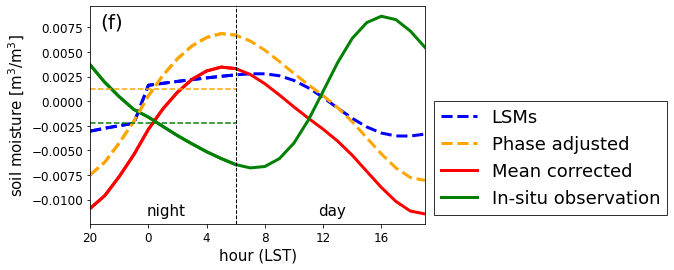

In [1896]:
fig = plt.figure(figsize=(6,4))
fig.set_facecolor('white')
plt.plot(x,hourly_reindex['LSMs'],label='LSMs',c='b',linewidth=3,linestyle='--')
plt.plot(x,hourly_reindex['adj_all'],label='Phase adjusted',c='orange',linewidth=3,linestyle='--')
plt.plot(x,hourly_reindex['night_adj'],label='Mean corrected',c='r',linewidth=3)
plt.plot(x,hourly_reindex['ISMN sm ano'],label='In-situ observation',c='g',linewidth=3)

plt.plot(x[:11],hourly_reindex['LSMs'][:11],c='b',linewidth=3,linestyle='--')
plt.plot(x[:11],hourly_reindex['night_adj'][:11],c='r',linewidth=3)
plt.plot(x[:11],hourly_reindex['ISMN sm ano'][:11],c='g',linewidth=3)
plt.plot(x[:11],hourly_reindex['adj_all'][:11],c='orange',linewidth=3,linestyle='--')

ISMN_mean_n = night['ISMN sm ano'].mean()
adj_mean_n = night['adj_all'].mean()
plt.axvline(x=10,linestyle='--',c='k',linewidth=1.)
plt.plot([0, 10], [ISMN_mean_n, ISMN_mean_n], linestyle='--', c='g') 
plt.plot([0, 10], [adj_mean_n, adj_mean_n], linestyle='--', c='orange') 

plt.ylabel('soil moisture [m$^3$/m$^3$]',fontsize=15)
plt.xlabel('hour (LST)',fontsize=15)
plt.xticks(ticks=x[::4], labels=xtick_labels[::4], fontsize=12)
plt.yticks(fontsize=12)
plt.xlim(0,23)

ax = plt.gca()  
ax.text(0.03, 0.9, '(f)', fontsize=20, transform=ax.transAxes)
ax.text(0.17,0.04, 'night', fontsize=15, transform=ax.transAxes)
ax.text(0.68,0.04, 'day', fontsize=15, transform=ax.transAxes)
plt.legend(bbox_to_anchor=(1.,0.), edgecolor='k', fontsize=18, fancybox=False, loc='lower left')
# plt.savefig(fname+'figure 4 diurnal2', dpi=600, bbox_inches = 'tight', pad_inches = 0.02)
plt.show()

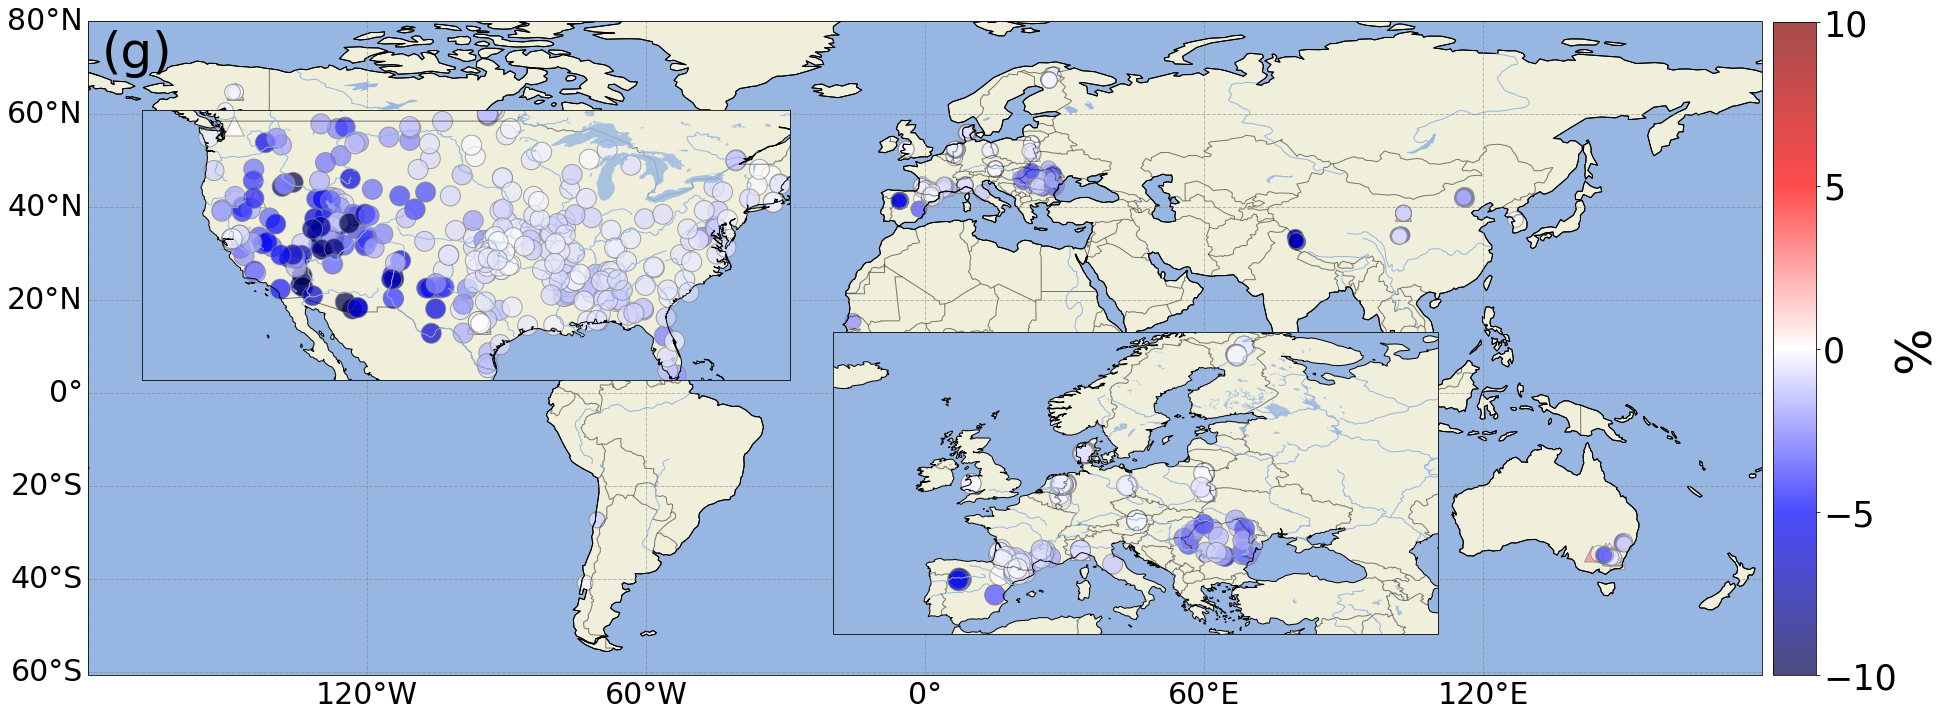

In [1305]:
fig ,axs= plt.subplots(figsize=(30, 30), subplot_kw={'projection': ccrs.PlateCarree()})
fig.set_facecolor('white')

# sc1=axs.scatter(ISMN_US['lon'].drop(index=before_noon2+error_idx).values, ISMN_US['lat_all'].drop(index=before_noon2+error_idx).values, c=ISMN_cor, cmap='seismic',transform=ccrs.PlateCarree(),s=100, edgecolor='gray',vmin=-1,vmax=1)#,norm=Normalize(vmin=0, vmax=23))

cor_p1 = np.array([value > 0 for value in mean_corrected_ratio_all])
cor_n1 = np.array([value <= 0 for value in mean_corrected_ratio_all])

axs.scatter(np.array(lon_all)[cor_p1], np.array(lat_all)[cor_p1], c=np.array(mean_corrected_ratio_all)[cor_p1], cmap='seismic', transform=ccrs.PlateCarree(),s=250, edgecolor='gray',norm=Normalize(-10,10),marker='^',alpha=0.7)
axs.scatter(np.array(lon_all)[cor_n1], np.array(lat_all)[cor_n1], c=np.array(mean_corrected_ratio_all)[cor_n1], cmap='seismic', transform=ccrs.PlateCarree(),s=250, edgecolor='gray',norm=Normalize(-10,10),marker='o',alpha=0.7)

axs.coastlines()
axs.add_feature(cfeature.LAND)
axs.add_feature(cfeature.OCEAN)
axs.add_feature(cfeature.COASTLINE)
axs.add_feature(cfeature.BORDERS, linestyle='-', alpha=.5)
axs.add_feature(cfeature.LAKES, alpha=0.95)
axs.add_feature(cfeature.RIVERS)
axs.set_extent([-180, 150, -60, 80])

gl = axs.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
gl.xlabel_style = {'size': 30}
gl.ylabel_style = {'size': 30}
# plt.colorbar(sc1, orientation='horizontal', fraction=0.05, pad=0.05,ax=axs)
axs.text(-177.,70., '(g)', fontsize=50)
# axs.text(0.02,0.05,'mean corrected ratio',transform=axs.transAxes,fontsize=50,bbox={'boxstyle': 'round,pad=0.3', 'facecolor': (1, 1, 1, 0.7), 'edgecolor': 'black'})

'ㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡ'
'CONUS'
ax_inset = fig.add_axes([0.15, 0.40, 0.3, 0.3], projection=ccrs.PlateCarree())
ax_inset.set_extent([-130, -70, 25, 50], crs=ccrs.PlateCarree())  # CONUS 지역

ax_inset.coastlines()
ax_inset.add_feature(cfeature.LAND)
ax_inset.add_feature(cfeature.OCEAN)
ax_inset.add_feature(cfeature.BORDERS, linestyle='-', alpha=0.5)
ax_inset.add_feature(cfeature.LAKES, alpha=0.8)
ax_inset.add_feature(cfeature.RIVERS)

ax_inset.scatter(np.array(lon_all)[cor_p1], np.array(lat_all)[cor_p1], c=np.array(mean_corrected_ratio_all)[cor_p1], cmap='seismic', transform=ccrs.PlateCarree(),s=400, edgecolor='gray',norm=Normalize(-10,10),marker='^',alpha=0.7)
ax_inset.scatter(np.array(lon_all)[cor_n1], np.array(lat_all)[cor_n1], c=np.array(mean_corrected_ratio_all)[cor_n1], cmap='seismic', transform=ccrs.PlateCarree(),s=400, edgecolor='gray',norm=Normalize(-10,10),marker='o',alpha=0.7)

'ㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡ'
'EU'
ax_inset2 = fig.add_axes([0.47, 0.35, 0.28, 0.18], projection=ccrs.PlateCarree())
ax_inset2.set_extent([-20, 50, 35, 70], crs=ccrs.PlateCarree())  # 유럽 지역 범위 설정

ax_inset2.coastlines()
ax_inset2.add_feature(cfeature.LAND)
ax_inset2.add_feature(cfeature.OCEAN)
ax_inset2.add_feature(cfeature.BORDERS, linestyle='-', alpha=0.5)
ax_inset2.add_feature(cfeature.LAKES, alpha=0.8)
ax_inset2.add_feature(cfeature.RIVERS)

ax_inset2.scatter(np.array(lon_all)[cor_p1], np.array(lat_all)[cor_p1], c=np.array(mean_corrected_ratio_all)[cor_p1], cmap='seismic', transform=ccrs.PlateCarree(),s=400, edgecolor='gray',norm=Normalize(-10,10),marker='^',alpha=0.7)
ax_inset2.scatter(np.array(lon_all)[cor_n1], np.array(lat_all)[cor_n1], c=np.array(mean_corrected_ratio_all)[cor_n1], cmap='seismic', transform=ccrs.PlateCarree(),s=400, edgecolor='gray',norm=Normalize(-10,10),marker='o',alpha=0.7)

'ㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡ'
'colorbar'
axpos = axs.get_position()
cbar_ax = fig.add_axes([axpos.x0+0.78, axpos.y0-0.0, 0.02, 0.302])
cbar = fig.colorbar(axs.collections[0], cax=cbar_ax, ticks=np.arange(-10,10.1,5),orientation='vertical')
cbar.ax.tick_params(labelsize=35)
cbar.set_label('%', fontsize=50,labelpad=-5)
plt.savefig(fname+'figure 4 mean corrected ratio', dpi=600, bbox_inches = 'tight', pad_inches = 0.02)
plt.show()

## title

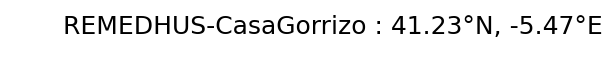

In [838]:
fig, ax = plt.subplots(figsize=(2, 1))

ax.text(0.5, 0.5, f'{ISMN_net}-{ISMN_st} : {round(ISMN_lat,2)}°N, {round(ISMN_lon,2)}°E',fontsize=25)
ax.axis("off")

# plt.savefig(fname+'figure 4 station info', dpi=300, bbox_inches="tight", pad_inches=0.1)
plt.show()

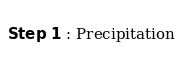

In [563]:
fig, ax = plt.subplots(figsize=(2, 1))

ax.text(0.5, 0.5, r'$\bf{Step~ 1}$ : Precipitation', fontsize=15, fontfamily='serif', ha='center', va='center')
ax.axis("off")

plt.savefig(fname+'figure 4 step 1', dpi=300, bbox_inches="tight", pad_inches=0.1)
plt.show()

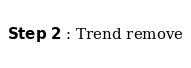

In [565]:
fig, ax = plt.subplots(figsize=(2, 1))

ax.text(0.5, 0.5, r'$\bf{Step~ 2}$ : Trend remove', fontsize=15, fontfamily='serif', ha='center', va='center')
ax.axis("off")

plt.savefig(fname+'figure 4 step 2', dpi=300, bbox_inches="tight", pad_inches=0.1)
plt.show()

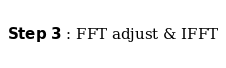

In [566]:
fig, ax = plt.subplots(figsize=(2, 1))

ax.text(0.5, 0.5, r'$\bf{Step~ 3}$ : FFT adjust & IFFT', fontsize=15, fontfamily='serif', ha='center', va='center', color='black')
ax.axis("off")

plt.savefig(fname+'figure 4 step 3', dpi=300, bbox_inches="tight", pad_inches=0.1)
plt.show()

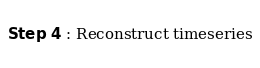

In [567]:
fig, ax = plt.subplots(figsize=(2, 1))

ax.text(0.5, 0.5, r'$\bf{Step~ 4}$ : Reconstruct timeseries', fontsize=15, fontfamily='serif', ha='center', va='center')
ax.axis("off")

plt.savefig(fname+'figure 4 step 4', dpi=300, bbox_inches="tight", pad_inches=0.1)
plt.show()

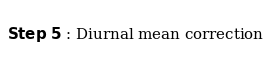

In [1898]:
fig, ax = plt.subplots(figsize=(2, 1))

ax.text(0.5, 0.5, r'$\bf{Step~ 5}$ : Diurnal mean correction', fontsize=15, fontfamily='serif', ha='center', va='center')
ax.axis("off")

plt.savefig(fname+'figure 4 step 5', dpi=300, bbox_inches="tight", pad_inches=0.1)
plt.show()

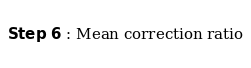

In [833]:
fig, ax = plt.subplots(figsize=(2, 1))

ax.text(0.5, 0.5, r'$\bf{Step~ 6}$ : Mean correction ratio', fontsize=15, fontfamily='serif', ha='center', va='center')
ax.axis("off")

# plt.savefig(fname+'figure 4 step 6', dpi=300, bbox_inches="tight", pad_inches=0.1)
plt.show()

# Figure 5

## data

### (a)

In [ ]:
ISMN_sm=sorted(glob.glob('/home/jnhan/python/power spectrum/data/final filter/sm/ISMN_filter/*.csv'))
ISMN_ts=sorted(glob.glob('/home/jnhan/python/power spectrum/data/final filter/ts/ISMN_filter/*.csv'))

ERA_data=sorted(glob.glob('/home/jnhan/python/power spectrum/data/ERA5/p_remove_250608/*.csv'))
MERRA_data=sorted(glob.glob('/home/jnhan/python/power spectrum/data/MERRA2/p_remove_250608/*.csv'))

TLO_sm=glob.glob('/home/jnhan/python/power spectrum/data/reference sensor/sm/TLO/*')
TLO_ts=glob.glob('/home/jnhan/python/power spectrum/data/reference sensor/ts/TLO/*')
TLO_n_sm=glob.glob('/home/jnhan/python/power spectrum/data/reference sensor/sm/TLO_nearest/*')
TLO_n_ts=glob.glob('/home/jnhan/python/power spectrum/data/reference sensor/ts/TLO_nearest/*')
TDT_sm=glob.glob('/home/jnhan/python/power spectrum/data/reference sensor/sm/TDT/*')
TDT_ts=glob.glob('/home/jnhan/python/power spectrum/data/reference sensor/ts/TDT/*')
TDT_n_sm=glob.glob('/home/jnhan/python/power spectrum/data/reference sensor/sm/TDT_nearest/*')
TDT_n_ts=glob.glob('/home/jnhan/python/power spectrum/data/reference sensor/ts/TDT_nearest/*')
TDR_sm=glob.glob('/home/jnhan/python/power spectrum/data/reference sensor/sm/TDR/*')
TDR_ts=glob.glob('/home/jnhan/python/power spectrum/data/reference sensor/ts/TDR/*')
TDR_n_sm=glob.glob('/home/jnhan/python/power spectrum/data/reference sensor/sm/TDR_nearest/*')
TDR_n_ts=glob.glob('/home/jnhan/python/power spectrum/data/reference sensor/ts/TDR_nearest/*')
COS_sm=glob.glob('/home/jnhan/python/power spectrum/data/reference sensor/sm/cosmic thres/*.csv')
COS_n_sm=glob.glob('/home/jnhan/python/power spectrum/data/reference sensor/sm/cosmic_nearest/*.csv')
COS_n_ts=glob.glob('/home/jnhan/python/power spectrum/data/reference sensor/ts/cosmic_nearest/*.csv')

In [880]:
ISMN_st=[i.split('/')[-1][:-7] for i in ISMN_sm]

# ISMN에 맞춰서 정렬
ERA_data = sorted(ERA_data, key=lambda path: ISMN_st.index(next(a for a in ISMN_st if a in path)))
MERRA_data = sorted(MERRA_data, key=lambda path: ISMN_st.index(next(a for a in ISMN_st if a in path)))

In [ ]:
TLO_st=[i.split('/')[-1][:-7] for i in TLO_sm]
TDT_st=[i.split('/')[-1][:-7] for i in TDT_sm]
TDR_st=[i.split('/')[-1][:-7] for i in TDR_sm]
COS_st=[i.split('/')[-1][:-7] for i in COS_sm]

TLO_ERA=[b for b in ERA_data if any(a in b for a in TLO_st)]
TDT_ERA=[b for b in ERA_data if any(a in b for a in TDT_st)]
TDR_ERA=[b for b in ERA_data if any(a in b for a in TDR_st)]
COS_ERA=[b for b in ERA_sm2 if any(a in b for a in COS_st)]

TLO_MERRA=[b for b in MERRA_data if any(a in b for a in TLO_st)]
TDT_MERRA=[b for b in MERRA_data if any(a in b for a in TDT_st)]
TDR_MERRA=[b for b in MERRA_data if any(a in b for a in TDR_st)]
COS_MERRA=[b for b in MERRA_sm2 if any(a in b for a in COS_st)]

TLO_ERA=[TLO_ERA[i] for i in [0, 1, 2, 4, 3, 5, 6]]
TLO_MERRA=[TLO_MERRA[i] for i in [0, 1, 2, 4, 3, 5, 6]]

TDT_ERA=[TDT_ERA[i] for i in [4, 2, 5, 8, 3, 0, 1, 9, 6, 7]]
TDT_MERRA=[TDT_MERRA[i] for i in [4, 2, 5, 8, 3, 0, 1, 9, 6, 7]]

In [ ]:
TLO_n_st=[i.split('/')[-1][:-7] for i in TLO_n_sm]
TDT_n_st=[i.split('/')[-1][:-7] for i in TDT_n_sm]
TDR_n_st=[i.split('/')[-1][:-7] for i in TDR_n_sm]
COS_n_st=[i.split('/')[-1][:-7] for i in COS_n_sm]

TLO_n_ERA=[b for b in ERA_data if any(a in b for a in TLO_n_st)]
TDT_n_ERA=[b for b in ERA_data if any(a in b for a in TDT_n_st)]
TDR_n_ERA=[b for b in ERA_data if any(a in b for a in TDR_n_st)]
COS_n_ERA=[b for b in ERA_data if any(a in b for a in COS_n_st)]

TLO_n_MERRA=[b for b in MERRA_data if any(a in b for a in TLO_n_st)]
TDT_n_MERRA=[b for b in MERRA_data if any(a in b for a in TDT_n_st)]
TDR_n_MERRA=[b for b in MERRA_data if any(a in b for a in TDR_n_st)]
COS_n_MERRA=[b for b in MERRA_data if any(a in b for a in COS_n_st)]

COS_n_ERA=[COS_n_ERA[i] for i in [7, 2, 4, 9, 3, 5, 6, 0, 1, 8]]
COS_n_MERRA=[COS_n_MERRA[i] for i in [7, 2, 4, 9, 3, 5, 6, 0, 1, 8]]

TLO_n_ERA=[TLO_n_ERA[i] for i in [5, 0, 1, 4, 3, 2, 6]]
TLO_n_MERRA=[TLO_n_MERRA[i] for i in [5, 0, 1, 4, 3, 2, 6]]

TDT_n_ERA=[TDT_n_ERA[i] for i in [0, 8, 6, 3, 5, 2, 4, 7, 1, 9]]
TDT_n_MERRA=[TDT_n_MERRA[i] for i in [0, 8, 6, 3, 5, 2, 4, 7, 1, 9]]

In [911]:
TLO_lat=[]
TLO_lon=[]
for i in TLO_sm:
    a=pd.read_csv(i)
    TLO_lat.append(a.latitude[0])
    TLO_lon.append(a.longitude[0])

TLO_n_lat=[]
TLO_n_lon=[]
for i in TLO_n_sm:
    a=pd.read_csv(i)
    TLO_n_lat.append(a.latitude[0])
    TLO_n_lon.append(a.longitude[0])

COS_lat=[]
COS_lon=[]
for i in COS_sm:
    a=pd.read_csv(i)
    COS_lat.append(a.latitude[0])
    COS_lon.append(a.longitude[0])

COS_n_lat=[]
COS_n_lon=[]
for i in COS_n_sm:
    a=pd.read_csv(i)
    COS_n_lat.append(a.latitude[0])
    COS_n_lon.append(a.longitude[0])

TDT_lat=[]
TDT_lon=[]
for i in TDT_sm:
    a=pd.read_csv(i)
    TDT_lat.append(a.latitude[0])
    TDT_lon.append(a.longitude[0])

TDT_n_lat=[]
TDT_n_lon=[]
for i in TDT_n_sm:
    a=pd.read_csv(i)
    TDT_n_lat.append(a.latitude[0])
    TDT_n_lon.append(a.longitude[0])

In [889]:
ISMN_sm=[item for item in ISMN_sm if not any(tlo in item for tlo in TLO_st)]
ISMN_sm=[item for item in ISMN_sm if not any(tlo in item for tlo in TDT_st)]
ISMN_ts=[item for item in ISMN_ts if not any(tlo in item for tlo in TLO_st)]
ISMN_ts=[item for item in ISMN_ts if not any(tlo in item for tlo in TDT_st)]

ERA_data=[item for item in ERA_data if not any(tlo in item for tlo in TLO_st)]
ERA_data=[item for item in ERA_data if not any(tlo in item for tlo in TDT_st)]

MERRA_data=[item for item in MERRA_data if not any(tlo in item for tlo in TDT_st)]
MERRA_data=[item for item in MERRA_data if not any(tlo in item for tlo in TLO_st)]

In [895]:
ERA_v,MERRA_v=(0.5, 0.5)
lat=[]
lon=[]
hourly_data=[]
bn_lat=[]
bn_lon=[]
bn_hourly_data=[]
error=[]
low_len=[]
idx=[]
bn_idx=[]
for i in range(len(ISMN_sm)):
    print(i,end='\r')
    try:
        ISMN=pd.read_csv(ISMN_sm[i],usecols={'date_time','soil_moisture','flag','anomaly','rm'},index_col='date_time',parse_dates=['date_time'])
        ERA=pd.read_csv(ERA_data[i],usecols={'date_time','sm','sm ano','ts','ts ano'},index_col='date_time',parse_dates=['date_time'])
        MERRA=pd.read_csv(MERRA_data[i],usecols={'date_time','sm','sm ano','ts','ts ano'},index_col='date_time',parse_dates=['date_time'])
        ts_ISMN=pd.read_csv(ISMN_ts[i],usecols={'date_time','soil_temperature','flag','anomaly'},index_col='date_time',parse_dates=['date_time'])
        ISMN2=pd.read_csv(ISMN_sm[i])
        
        ISMN=ISMN[ISMN['flag']=='G']
        ts_ISMN=ts_ISMN[ts_ISMN['flag']=='G']
        ISMN=ISMN[['soil_moisture','anomaly','rm']]
        ts_ISMN=ts_ISMN[['soil_temperature','anomaly']]
        
        ISMN.rename(columns={'soil_moisture':'ISMN sm','anomaly':'ISMN sm ano','rm':'ISMN rm'},inplace=True)
        ERA.rename(columns={'sm':'ERA sm','sm ano':'ERA sm ano','ts':'ERA ts','ts ano':'ERA ts ano'},inplace=True)
        MERRA.rename(columns={'sm':'MERRA sm','sm ano':'MERRA sm ano','ts':'MERRA ts','ts ano':'MERRA ts ano'},inplace=True)
        ts_ISMN.rename(columns={'soil_temperature':'ISMN ts','anomaly':'ISMN ts ano'},inplace=True)
        
        merged = ISMN.merge(ERA, left_index=True, right_index=True, how='inner')
        merged = merged.merge(MERRA, left_index=True, right_index=True, how='inner')
        merged = merged.merge(ts_ISMN, left_index=True, right_index=True, how='inner')
        merged = merged.dropna()

        if len(merged) > 2200:
            'ㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡ'
            'anomaly'
            fft_ISMN_ano=np.fft.fft(merged['ISMN sm ano'])
            ps_ISMN_ano=np.abs(fft_ISMN_ano)
            freq_ISMN_ano=np.fft.fftfreq(len(merged),d=1.0/len(fft_ISMN_ano))
            
            fft_ERA_ano=np.fft.fft(merged['ERA sm ano'])
            ps_ERA_ano=np.abs(fft_ERA_ano)
            freq_ERA_ano=np.fft.fftfreq(len(merged),d=1.0/len(fft_ERA_ano))
            
            fft_MERRA_ano=np.fft.fft(merged['MERRA sm ano'])
            ps_MERRA_ano=np.abs(fft_MERRA_ano)
            freq_MERRA_ano=np.fft.fftfreq(len(merged),d=1.0/len(fft_MERRA_ano))
            
            freq_24=int(len(freq_ISMN_ano)/24)
            freq_36=int(len(freq_ISMN_ano)/36)
            freq_12=int(len(freq_ISMN_ano)/12)
            
            df_ano=pd.DataFrame()
            df_ano['fft_ISMN_r']=fft_ISMN_ano.real
            df_ano['fft_ERA_r']=fft_ERA_ano.real
            df_ano['fft_MERRA_r']=fft_MERRA_ano.real
            df_ano['fft_m_r']=((ERA_v*df_ano['fft_ERA_r'])+(MERRA_v*df_ano['fft_MERRA_r']))
            df_ano['fft_ISMN_i']=fft_ISMN_ano.imag
            df_ano['fft_ERA_i']=fft_ERA_ano.imag
            df_ano['fft_MERRA_i']=fft_MERRA_ano.imag
            df_ano['fft_m_i']=((ERA_v*df_ano['fft_ERA_i'])+(MERRA_v*df_ano['fft_MERRA_i']))
            df_ano['ps_ISMN']=ps_ISMN_ano
            df_ano['ps_ERA']=ps_ERA_ano
            df_ano['ps_MERRA']=ps_MERRA_ano
            df_ano['ps_m']=((ERA_v*df_ano['ps_ERA'])+(MERRA_v*df_ano['ps_MERRA']))
            
            sf_ano_E=df_ano['ps_ISMN']/df_ano['ps_ERA']
            sf_ano_M=df_ano['ps_ISMN']/df_ano['ps_MERRA']
            sf_ano_all=df_ano['ps_ISMN']/df_ano['ps_m']
            
            fft_ano_r_E=sf_ano_E*df_ano['fft_ERA_r']
            fft_ano_i_E=sf_ano_E*df_ano['fft_ERA_i']
            fft_ano_r_M=sf_ano_M*df_ano['fft_MERRA_r']
            fft_ano_i_M=sf_ano_M*df_ano['fft_MERRA_i']
            fft_ano_r_all=sf_ano_all*df_ano['fft_m_r']
            fft_ano_i_all=sf_ano_all*df_ano['fft_m_i']
            
            fft_ano_resc_E=fft_ano_r_E+fft_ano_i_E*1j
            fft_ano_resc_M=fft_ano_r_M+fft_ano_i_M*1j
            fft_ano_resc_all=fft_ano_r_all+fft_ano_i_all*1j
            
            fft_ISMN_adj_ano_E=fft_ISMN_ano.copy()
            fft_ISMN_adj_ano_M=fft_ISMN_ano.copy()
            fft_ISMN_adj_ano_all=fft_ISMN_ano.copy()
            
            fft_ISMN_adj_ano_E[freq_36:freq_12]=fft_ano_resc_E[freq_36:freq_12]
            fft_ISMN_adj_ano_E[-freq_12:-freq_36]=fft_ano_resc_E[-freq_12:-freq_36]
            fft_ISMN_adj_ano_M[freq_36:freq_12]=fft_ano_resc_M[freq_36:freq_12]
            fft_ISMN_adj_ano_M[-freq_12:-freq_36]=fft_ano_resc_M[-freq_12:-freq_36]
            fft_ISMN_adj_ano_all[freq_36:freq_12]=fft_ano_resc_all[freq_36:freq_12]
            fft_ISMN_adj_ano_all[-freq_12:-freq_36]=fft_ano_resc_all[-freq_12:-freq_36]
            
            ps_ano_adj_E=np.abs(fft_ISMN_adj_ano_E)
            ps_ano_adj_M=np.abs(fft_ISMN_adj_ano_M)
            ps_ano_adj_all=np.abs(fft_ISMN_adj_ano_all)
            
            ifft_ISMN_ano_E=np.fft.ifft(fft_ISMN_adj_ano_E)
            ifft_ISMN_ano_real_E=ifft_ISMN_ano_E.real
            ifft_ISMN_ano_M=np.fft.ifft(fft_ISMN_adj_ano_M)
            ifft_ISMN_ano_real_M=ifft_ISMN_ano_M.real
            ifft_ISMN_ano_all=np.fft.ifft(fft_ISMN_adj_ano_all)
            ifft_ISMN_ano_real_all=ifft_ISMN_ano_all.real
            
            merged['ano_adj_E']=ifft_ISMN_ano_real_E
            merged['ano_adj_M']=ifft_ISMN_ano_real_M
            merged['ano_adj_all']=ifft_ISMN_ano_real_all
            
            hourly=merged.groupby(merged.index.hour).mean()

            if (np.argmax(hourly['ISMN sm ano']) >= 12):
                lat.append(ISMN2.latitude[0])
                lon.append(ISMN2.longitude[0])
                hourly_data.append(hourly)
                idx.append(i)
            else : 
                bn_lat.append(ISMN2.latitude[0])
                bn_lon.append(ISMN2.longitude[0])
                bn_hourly_data.append(hourly)
                bn_idx.append(i)
            del night,hourly
        else:
            low_len.append(i)
    except Exception as e:
        error.append((i,e))

In [904]:
lat_all=lat+bn_lat
lon_all=lon+bn_lon
hourly_data_all=hourly_data+bn_hourly_data

In [912]:
COS_ref_idx=[i for i,(j,k) in enumerate(zip(lat_all,lon_all)) if (any(str(b) in str(j) for b in COS_n_lat) & any(str(a) in str(k) for a in COS_n_lon))]
TDT_ref_idx=[i for i,(j,k) in enumerate(zip(lat_all,lon_all)) if (any(str(b) in str(j) for b in TDT_n_lat) & any(str(a) in str(k) for a in TDT_n_lon))]
TLO_ref_idx=[i for i,(j,k) in enumerate(zip(lat_all,lon_all)) if (any(str(b) in str(j) for b in TLO_n_lat) & any(str(a) in str(k) for a in TLO_n_lon))]

In [925]:
COS_comp=[COS_sm[i] for i in [7, 7, 8, 1, 2, 5, 0, 9, 6, 3]]
TLO_comp=[TLO_sm[i] for i in [1, 5, 5, 3, 3, 0, 6]]

In [ ]:
cor_COS_adj=[]
cor_COS_adj_E=[]
cor_COS_adj_M=[]
cor_COS_ori=[]
hourly_COS=[]
for i in range(len(COS_ref_idx)):
    a=hourly_data_all[COS_ref_idx[i]]
    b=pd.read_csv(COS_comp[i],index_col='date_time',usecols=['date_time','soil_moisture','anomaly'])
    b.index=pd.to_datetime(b.index)
    b_h=b.groupby(b.index.hour).mean()
    hourly_COS.append(b_h)
    cor_COS_adj.append(stats.pearsonr(a['ano_adj_all'],b_h['anomaly'])[0])
    cor_COS_adj_E.append(stats.pearsonr(a['ano_adj_E'],b_h['anomaly'])[0])
    cor_COS_adj_M.append(stats.pearsonr(a['ano_adj_M'],b_h['anomaly'])[0])
    cor_COS_ori.append(stats.pearsonr(a['ISMN sm ano'],b_h['anomaly'])[0])
    del a,b,b_h

cor_TLO_adj=[]
cor_TLO_adj_E=[]
cor_TLO_adj_M=[]
cor_TLO_ori=[]
hourly_TLO=[]
for i in range(len(TLO_ref_idx)):
    a=hourly_data_all[TLO_ref_idx[i]]
    b=pd.read_csv(TLO_comp[i],index_col='date_time',usecols=['date_time','soil_moisture','anomaly'])
    b.index=pd.to_datetime(b.index)
    b_h=b.groupby(b.index.hour).mean()
    hourly_TLO.append(b_h)
    cor_TLO_adj.append(stats.pearsonr(a['ano_adj_all'],b_h['anomaly'])[0])
    cor_TLO_adj_E.append(stats.pearsonr(a['ano_adj_E'],b_h['anomaly'])[0])
    cor_TLO_adj_M.append(stats.pearsonr(a['ano_adj_M'],b_h['anomaly'])[0])
    cor_TLO_ori.append(stats.pearsonr(a['ISMN sm ano'],b_h['anomaly'])[0])
    del a,b,b_h

In [933]:
hourly_n_COS=[]
for i in range(len(COS_ref_idx)):
    hourly_n_COS.append(hourly_data_all[COS_ref_idx[i]])

hourly_n_TLO=[]
for i in range(len(TLO_ref_idx)):
    hourly_n_TLO.append(hourly_data_all[TLO_ref_idx[i]])

In [934]:
hourly_n=(hourly_n_COS+hourly_n_TLO)
hourly_ref=(hourly_COS+hourly_TLO)

In [935]:
lat_n_COS=[]
for i in range(len(COS_ref_idx)):
    lat_n_COS.append(lat_all[COS_ref_idx[i]])

lon_n_COS=[]
for i in range(len(COS_ref_idx)):
    lon_n_COS.append(lon_all[COS_ref_idx[i]])

lat_n_TLO=[]
for i in range(len(TLO_ref_idx)):
    lat_n_TLO.append(lat_all[TLO_ref_idx[i]])

lon_n_TLO=[]
for i in range(len(TLO_ref_idx)):
    lon_n_TLO.append(lon_all[TLO_ref_idx[i]])

In [936]:
lat_n=(lat_n_COS+lat_n_TLO)
lon_n=(lon_n_COS+lon_n_TLO)

In [941]:
h_lists_ano = [[] for _ in range(24)]  # h_0 ~ h_23에 해당하는 24개의 빈 리스트 생성

for i in range(len(hourly_n)):
    for j in range(24):  # 0 ~ 23의 date_time에 대해 반복
        h_lists_ano[j].append(hourly_n[i]['ISMN sm ano'].loc[j])

'ㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡ'
h_lists_adj = [[] for _ in range(24)]  # h_0 ~ h_23에 해당하는 24개의 빈 리스트 생성

for i in range(len(hourly_n)):
    for j in range(24):  # 0 ~ 23의 date_time에 대해 반복
        h_lists_adj[j].append(hourly_n[i]['ano_adj_all'].loc[j])

        
'ㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡ'

df_ano_h = pd.DataFrame()

for hour in range(24):
    temp_df = pd.DataFrame({
        'sm ano': h_lists_ano[hour],
        'hour': str(hour)           
    })
    df_ano_h = pd.concat([df_ano_h, temp_df], ignore_index=True)

df_ano_h['value']='sm ano'

'ㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡ'
df_adj_h = pd.DataFrame()

for hour in range(24):
    temp_df = pd.DataFrame({
        'sm adj': h_lists_adj[hour],
        'hour': str(hour)           
    })
    df_adj_h = pd.concat([df_adj_h, temp_df], ignore_index=True)

df_adj_h['value']='sm adj'

df_h=pd.concat([df_ano_h,df_adj_h])

In [948]:
h_lists_ano = [[] for _ in range(24)]  # h_0 ~ h_23에 해당하는 24개의 빈 리스트 생성

for i in range(len(hourly_n)):
    for j in range(24):  # 0 ~ 23의 date_time에 대해 반복
        h_lists_ano[j].append(hourly_n[i]['ISMN sm ano'].loc[j])

'ㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡ'
h_lists_adj = [[] for _ in range(24)]  # h_0 ~ h_23에 해당하는 24개의 빈 리스트 생성

for i in range(len(hourly_n)):
    for j in range(24):  # 0 ~ 23의 date_time에 대해 반복
        h_lists_adj[j].append(hourly_n[i]['ano_adj_all'].loc[j])

        
'ㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡ'

df_ano_h = pd.DataFrame()

for hour in range(24):
    temp_df = pd.DataFrame({
        'value': h_lists_ano[hour],
        'hour': str(hour)           
    })
    df_ano_h = pd.concat([df_ano_h, temp_df], ignore_index=True)

df_ano_h['data']='sm ano'

'ㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡ'
df_adj_h = pd.DataFrame()

for hour in range(24):
    temp_df = pd.DataFrame({
        'value': h_lists_adj[hour],
        'hour': str(hour)           
    })
    df_adj_h = pd.concat([df_adj_h, temp_df], ignore_index=True)

df_adj_h['data']='sm adj'

df_h=pd.concat([df_ano_h,df_adj_h])

In [943]:
df_ref_h = pd.DataFrame()

for hour in range(24):
    temp_df = pd.DataFrame({
        'sm ref': h_lists_ref[hour],
        'hour': str(hour)           
    })
    df_ref_h = pd.concat([df_ref_h, temp_df], ignore_index=True)

df_ref_h['value']='sm ref'

df_ref_h['hour'] = df_ref_h['hour'].astype(int)

# Groupby와 정렬
median_values = df_ref_h.groupby('hour')['sm ref'].median().sort_index()

### (b)

In [964]:
df_COS=pd.DataFrame()
df_COS['R']=cor_COS_adj
df_COS['t']='adj'
df_COS[' ']='$\mathrm{ISMN_{adj}}$'

df_TLO=pd.DataFrame()
df_TLO['R']=cor_TLO_adj
df_TLO['t']='adj'
df_TLO[' ']='$\mathrm{ISMN_{adj}}$'

df_COS_ori=pd.DataFrame()
df_COS_ori['R']=cor_COS_ori
df_COS_ori['t']='ori'
df_COS_ori[' ']='ISMN'

df_TLO_ori=pd.DataFrame()
df_TLO_ori['R']=cor_TLO_ori
df_TLO_ori['t']='ori'
df_TLO_ori[' ']='ISMN'

df_cor=pd.concat([df_COS_ori,df_TLO_ori,df_COS,df_TLO],axis=0,ignore_index=True)

In [975]:
median_diff=np.median(cor_COS_adj+cor_TLO_adj)-np.median(cor_COS_ori+cor_TLO_ori)

## plot

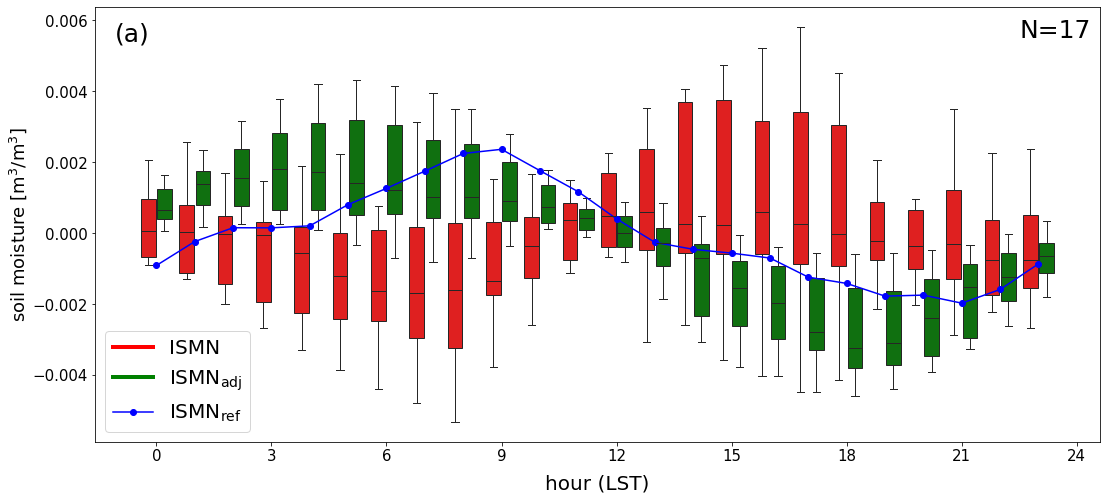

In [1307]:
# n=17 median
fig, axs = plt.subplots(1, 1, figsize=(18, 8))
fig.set_facecolor('white')

sns.boxplot(x='hour',y='value',hue='data',data=df_h,width=.85, palette=['r','g'], whis=1., showfliers=False, gap=.1)
med,=plt.plot(median_values.index, median_values.values, marker='o', color='b', label=r'$\text{ISMN_{ref}}$')
plt.xlabel('hour (LST)',fontsize=20,labelpad=10)
plt.ylabel('soil moisture [m$^3$/m$^3$]',fontsize=18)
plt.yticks(fontsize=15)
plt.xticks([0, 3, 6, 9, 12, 15, 18, 21, 24], ['0', '3', '6', '9', '12', '15', '18', '21', '24'], fontsize=15)
plt.legend(fontsize=12,loc='upper left')

ax = plt.gca()  
ax.text(0.02, 0.92, '(a)', fontsize=25, transform=ax.transAxes)

handles = [plt.Line2D([0], [0], color='r', lw=4), plt.Line2D([0], [0], color='g', lw=4), med]
labels = ['ISMN', r'ISMN$_{\text{adj}}$', r'ISMN$_{\text{ref}}$']
plt.legend(handles=handles, labels=labels, fontsize=20, loc='lower left')
plt.text(22.5,0.0055,'N=17',fontsize=25)
plt.savefig(fname+'figure 5 boxplot timeseries(median)', dpi=300, bbox_inches = 'tight', pad_inches = 0.02)
plt.show()

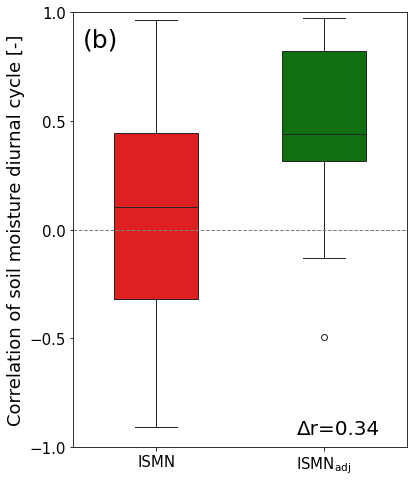

In [1309]:
# n=17
fig, axs = plt.subplots(1, 1, figsize=(6, 8))
fig.set_facecolor('white')

sns.boxplot(x=' ', y='R', hue='t', data=df_cor, width=0.5, legend=False, palette=['r','g'])
plt.ylabel('Correlation of soil moisture diurnal cycle [-]',fontsize=18)
plt.xticks(fontsize=15)
plt.yticks([-1.0, -0.5, 0, 0.5, 1.0],fontsize=15)
plt.ylim(-1.,1.)
plt.axhline(0.0,c='gray',linestyle='--',linewidth=1)
ax = plt.gca()  
ax.text(0.03, 0.92, '(b)', fontsize=25, transform=ax.transAxes)
ax.text(.67, 0.03, f'Δr={round(median_diff,2)}', fontsize=20, transform=ax.transAxes)

plt.savefig(fname+'figure 5 R(ori,adj) boxplot2', dpi=300, bbox_inches = 'tight', pad_inches = 0.02)
plt.show()

# Figure 6

## data

In [1311]:
ISMN_sm=sorted(glob.glob('/home/jnhan/python/power spectrum/data/final filter/sm/ISMN_filter/*.csv'))
ISMN_ts=sorted(glob.glob('/home/jnhan/python/power spectrum/data/final filter/ts/ISMN_filter/*.csv'))

ERA_data=sorted(glob.glob('/home/jnhan/python/power spectrum/data/ERA5/p_remove_250608/*.csv'))
MERRA_data=sorted(glob.glob('/home/jnhan/python/power spectrum/data/MERRA2/p_remove_250608/*.csv'))

TLO_sm=glob.glob('/home/jnhan/python/power spectrum/data/reference sensor/sm/TLO/*')
TDT_sm=glob.glob('/home/jnhan/python/power spectrum/data/reference sensor/sm/TDT/*')

TLO_st=[i.split('/')[-1][:-7] for i in TLO_sm]
TDT_st=[i.split('/')[-1][:-7] for i in TDT_sm]

In [1312]:
ISMN_sm=[item for item in ISMN_sm if not any(tlo in item for tlo in TLO_st)]
ISMN_sm=[item for item in ISMN_sm if not any(tlo in item for tlo in TDT_st)]

ISMN_ts=[item for item in ISMN_ts if not any(tlo in item for tlo in TLO_st)]
ISMN_ts=[item for item in ISMN_ts if not any(tlo in item for tlo in TDT_st)]

ERA_data=[item for item in ERA_data if not any(tlo in item for tlo in TDT_st)]
ERA_data=[item for item in ERA_data if not any(tlo in item for tlo in TLO_st)]

MERRA_data=[item for item in MERRA_data if not any(tlo in item for tlo in TDT_st)]
MERRA_data=[item for item in MERRA_data if not any(tlo in item for tlo in TLO_st)]

In [1313]:
ISMN_order=[i.split('/')[-1][:-7] for i in ISMN_sm]

ERA_data = sorted(ERA_data, key=lambda path: ISMN_order.index(next(a for a in ISMN_order if a in path)))
MERRA_data = sorted(MERRA_data, key=lambda path: ISMN_order.index(next(a for a in ISMN_order if a in path)))

In [1314]:
def adjust_night(group):
    night = group[(group['hour'] < 7) | (group['hour'] >= 20)]
    
    if not night.empty:
        bias = night['ano_adj_all'].mean() - night['ISMN sm ano'].mean()
        group['night_adj'] = group['ano_adj_all'] - bias + group['ISMN rm']
    else:
        group['night_adj'] = np.nan  # 혹은 group['ano_adj_all'] 그대로 남겨도 됨

    return group

In [1315]:
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [1316]:
ERA_v,MERRA_v=(0.5, 0.5)
lat=[]
lon=[]
ISMN_cor_ano=[]
MERRA_cor_ano=[]
ERA_cor_ano=[]
ISMN_cor_adj=[]
max_hr_ISMN=[]
max_hr_ERA=[]
max_hr_MERRA=[]
max_hr_adj=[]
bn_lat=[]
bn_lon=[]
bn_ISMN_cor_ano=[]
bn_MERRA_cor_ano=[]
bn_ERA_cor_ano=[]
bn_ISMN_cor_adj=[]
bn_max_hr_ISMN=[]
bn_max_hr_ERA=[]
bn_max_hr_MERRA=[]
bn_max_hr_adj=[]
before_noon=[]
error=[]
low_len=[]
idx=[]
bn_idx=[]
for i in range(len(ISMN_sm)):
    print(i,end='\r')
    try:
        ISMN=pd.read_csv(ISMN_sm[i],usecols={'date_time','soil_moisture','flag','anomaly','rm'},index_col='date_time',parse_dates=['date_time'])
        ERA=pd.read_csv(ERA_data[i],usecols={'date_time','sm','sm ano','ts','ts ano'},index_col='date_time',parse_dates=['date_time'])
        MERRA=pd.read_csv(MERRA_data[i],usecols={'date_time','sm','sm ano','ts','ts ano'},index_col='date_time',parse_dates=['date_time'])
        ts_ISMN=pd.read_csv(ISMN_ts[i],usecols={'date_time','soil_temperature','flag','anomaly'},index_col='date_time',parse_dates=['date_time'])
        ISMN2=pd.read_csv(ISMN_sm[i])
        
        ISMN=ISMN[ISMN['flag']=='G']
        ts_ISMN=ts_ISMN[ts_ISMN['flag']=='G']
        ISMN=ISMN[['soil_moisture','anomaly','rm']]
        ts_ISMN=ts_ISMN[['soil_temperature','anomaly']]
        
        ISMN.rename(columns={'soil_moisture':'ISMN sm','anomaly':'ISMN sm ano','rm':'ISMN rm'},inplace=True)
        ERA.rename(columns={'sm':'ERA sm','sm ano':'ERA sm ano','ts':'ERA ts','ts ano':'ERA ts ano'},inplace=True)
        MERRA.rename(columns={'sm':'MERRA sm','sm ano':'MERRA sm ano','ts':'MERRA ts','ts ano':'MERRA ts ano'},inplace=True)
        ts_ISMN.rename(columns={'soil_temperature':'ISMN ts','anomaly':'ISMN ts ano'},inplace=True)
        
        merged = ISMN.merge(ERA, left_index=True, right_index=True, how='inner')
        merged = merged.merge(MERRA, left_index=True, right_index=True, how='inner')
        merged = merged.merge(ts_ISMN, left_index=True, right_index=True, how='inner')
        merged = merged.dropna()

        if len(merged) > 2200:
            'ㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡ'
            'anomaly'
            fft_ISMN_ano=np.fft.fft(merged['ISMN sm ano'])
            ps_ISMN_ano=np.abs(fft_ISMN_ano)
            freq_ISMN_ano=np.fft.fftfreq(len(merged),d=1.0/len(fft_ISMN_ano))
            
            fft_ERA_ano=np.fft.fft(merged['ERA sm ano'])
            ps_ERA_ano=np.abs(fft_ERA_ano)
            freq_ERA_ano=np.fft.fftfreq(len(merged),d=1.0/len(fft_ERA_ano))
            
            fft_MERRA_ano=np.fft.fft(merged['MERRA sm ano'])
            ps_MERRA_ano=np.abs(fft_MERRA_ano)
            freq_MERRA_ano=np.fft.fftfreq(len(merged),d=1.0/len(fft_MERRA_ano))
            
            freq_24=int(len(freq_ISMN_ano)/24)
            freq_36=int(len(freq_ISMN_ano)/36)
            freq_12=int(len(freq_ISMN_ano)/12)
            
            df_ano=pd.DataFrame()
            df_ano['fft_ISMN_r']=fft_ISMN_ano.real
            df_ano['fft_ERA_r']=fft_ERA_ano.real
            df_ano['fft_MERRA_r']=fft_MERRA_ano.real
            df_ano['fft_m_r']=((ERA_v*df_ano['fft_ERA_r'])+(MERRA_v*df_ano['fft_MERRA_r']))
            df_ano['fft_ISMN_i']=fft_ISMN_ano.imag
            df_ano['fft_ERA_i']=fft_ERA_ano.imag
            df_ano['fft_MERRA_i']=fft_MERRA_ano.imag
            df_ano['fft_m_i']=((ERA_v*df_ano['fft_ERA_i'])+(MERRA_v*df_ano['fft_MERRA_i']))
            df_ano['ps_ISMN']=ps_ISMN_ano
            df_ano['ps_ERA']=ps_ERA_ano
            df_ano['ps_MERRA']=ps_MERRA_ano
            df_ano['ps_m']=((ERA_v*df_ano['ps_ERA'])+(MERRA_v*df_ano['ps_MERRA']))
            
            mv_ano=df_ano.rolling(window=24,center=True).mean()
            
            sf_ano_E=mv_ano['ps_ISMN']/mv_ano['ps_ERA']
            sf_ano_M=mv_ano['ps_ISMN']/mv_ano['ps_MERRA']
            sf_ano_all=mv_ano['ps_ISMN']/mv_ano['ps_m']
            
            fft_ano_r_E=sf_ano_E*df_ano['fft_ERA_r']
            fft_ano_i_E=sf_ano_E*df_ano['fft_ERA_i']
            fft_ano_r_M=sf_ano_M*df_ano['fft_MERRA_r']
            fft_ano_i_M=sf_ano_M*df_ano['fft_MERRA_i']
            fft_ano_r_all=sf_ano_all*df_ano['fft_m_r']
            fft_ano_i_all=sf_ano_all*df_ano['fft_m_i']
            
            fft_ano_resc_E=fft_ano_r_E+fft_ano_i_E*1j
            fft_ano_resc_M=fft_ano_r_M+fft_ano_i_M*1j
            fft_ano_resc_all=fft_ano_r_all+fft_ano_i_all*1j
            
            fft_ISMN_adj_ano_E=fft_ISMN_ano.copy()
            fft_ISMN_adj_ano_M=fft_ISMN_ano.copy()
            fft_ISMN_adj_ano_all=fft_ISMN_ano.copy()
            
            fft_ISMN_adj_ano_E[freq_36:freq_12]=fft_ano_resc_E[freq_36:freq_12]
            fft_ISMN_adj_ano_E[-freq_12:-freq_36]=fft_ano_resc_E[-freq_12:-freq_36]
            fft_ISMN_adj_ano_M[freq_36:freq_12]=fft_ano_resc_M[freq_36:freq_12]
            fft_ISMN_adj_ano_M[-freq_12:-freq_36]=fft_ano_resc_M[-freq_12:-freq_36]
            fft_ISMN_adj_ano_all[freq_36:freq_12]=fft_ano_resc_all[freq_36:freq_12]
            fft_ISMN_adj_ano_all[-freq_12:-freq_36]=fft_ano_resc_all[-freq_12:-freq_36]
            
            ps_ano_adj_E=np.abs(fft_ISMN_adj_ano_E)
            ps_ano_adj_M=np.abs(fft_ISMN_adj_ano_M)
            ps_ano_adj_all=np.abs(fft_ISMN_adj_ano_all)
            
            ifft_ISMN_ano_E=np.fft.ifft(fft_ISMN_adj_ano_E)
            ifft_ISMN_ano_real_E=ifft_ISMN_ano_E.real
            ifft_ISMN_ano_M=np.fft.ifft(fft_ISMN_adj_ano_M)
            ifft_ISMN_ano_real_M=ifft_ISMN_ano_M.real
            ifft_ISMN_ano_all=np.fft.ifft(fft_ISMN_adj_ano_all)
            ifft_ISMN_ano_real_all=ifft_ISMN_ano_all.real
            
            merged['ano_adj_E']=ifft_ISMN_ano_real_E
            merged['ano_adj_M']=ifft_ISMN_ano_real_M
            merged['ano_adj_all']=ifft_ISMN_ano_real_all
            
            hourly=merged.groupby(merged.index.hour).mean()
            
            
            night=hourly.loc[list(range(7))+list(range(20,24))]

            merged_copy=merged.copy()
            merged_copy['date']=merged_copy.index.date
            merged_copy['hour']=merged_copy.index.hour
            merged_copy=merged_copy.groupby('date', group_keys=False).apply(adjust_night)
            filter_date=merged_copy.loc[merged_copy['night_adj'] < 0, 'date'].unique()
            merged_copy['night_adj2']=merged_copy['night_adj']
        
            for j in filter_date:
                filter_start=merged_copy[merged_copy['date'] == j][['night_adj']].copy()
                night_mean=np.mean(filter_start['night_adj'])
                filter_start['step1']=filter_start['night_adj']-night_mean
                filter_min=np.min(filter_start['step1'])
                if night_mean > 0 : 
                    if abs(filter_min) < 1:
                        filter_start['step2']=filter_start['step1']*abs(filter_min)
                        filter_start['step3']=filter_start['step2']+night_mean
                        merged_copy.loc[filter_start.index, 'night_adj2'] = filter_start['step3']
                    elif abs(filter_min) > 1:
                        filter_start['step2']=filter_start['step1']/abs(filter_min)
                        filter_start['step3']=filter_start['step2']+night_mean
                        merged_copy.loc[filter_start.index, 'night_adj2'] = filter_start['step3']
                elif night_mean < 0 :
                    if abs(filter_min) < 1:
                        filter_start['step2']=filter_start['step1']*abs(filter_min)
                        filter_start['step3']=filter_start['step2']+abs(np.min(filter_start['step2']))
                        merged_copy.loc[filter_start.index, 'night_adj2'] = filter_start['step3']
                    elif abs(filter_min) > 1:
                        filter_start['step2']=filter_start['step1']/abs(filter_min)
                        filter_start['step3']=filter_start['step2']+abs(np.min(filter_start['step2']))
                        merged_copy.loc[filter_start.index, 'night_adj2'] = filter_start['step3']

            merged_copy=merged_copy.drop(columns=['date','hour'])
            hourly=merged_copy.groupby(merged_copy.index.hour).mean()            
            
            if (np.argmax(hourly['ISMN sm ano']) >= 12):
                lat.append(ISMN2.latitude[0])
                lon.append(ISMN2.longitude[0])
                ISMN_cor_ano.append(np.corrcoef(hourly['ISMN sm ano'],hourly['ISMN ts ano'])[0,1])       # ISMN ano R(sm,ts)
                MERRA_cor_ano.append(np.corrcoef(hourly['MERRA sm ano'],hourly['MERRA ts ano'])[0,1])          # MERRA ano R(sm,ts)
                ERA_cor_ano.append(np.corrcoef(hourly['ERA sm ano'],hourly['ERA ts ano'])[0,1])       # ERA ano R(sm,ts)
                ISMN_cor_adj.append(np.corrcoef(hourly['night_adj'],hourly['ISMN ts ano'])[0,1])             # ISMN R(sm_adj,ts)
                max_hr_ISMN.append(np.argmax(hourly['ISMN sm ano']))
                max_hr_ERA.append(np.argmax(hourly['ERA sm ano']))
                max_hr_MERRA.append(np.argmax(hourly['MERRA sm ano']))
                max_hr_adj.append(np.argmax(hourly['ano_adj_all']))
                idx.append(i)
            else : 
                bn_lat.append(ISMN2.latitude[0])
                bn_lon.append(ISMN2.longitude[0])
                bn_ISMN_cor_ano.append(np.corrcoef(hourly['ISMN sm ano'],hourly['ISMN ts ano'])[0,1])       # ISMN ano R(sm,ts)
                bn_MERRA_cor_ano.append(np.corrcoef(hourly['MERRA sm ano'],hourly['MERRA ts ano'])[0,1])          # MERRA ano R(sm,ts)
                bn_ERA_cor_ano.append(np.corrcoef(hourly['ERA sm ano'],hourly['ERA ts ano'])[0,1])       # ERA ano R(sm,ts)
                bn_ISMN_cor_adj.append(np.corrcoef(hourly['night_adj'],hourly['ISMN ts ano'])[0,1])             # ISMN R(sm_adj,ts)
                bn_max_hr_ISMN.append(np.argmax(hourly['ISMN sm ano']))
                bn_max_hr_ERA.append(np.argmax(hourly['ERA sm ano']))
                bn_max_hr_MERRA.append(np.argmax(hourly['MERRA sm ano']))
                bn_max_hr_adj.append(np.argmax(hourly['ano_adj_all']))
                bn_idx.append(i)
            del night,hourly
        else:
            low_len.append(i)
    except Exception as e:
        error.append((i,e))

In [1317]:
lat_all=lat+bn_lat
lon_all=lon+bn_lon
R_ISMN_all=ISMN_cor_ano+bn_ISMN_cor_ano
R_ERA_all=ERA_cor_ano+bn_ERA_cor_ano
R_MERRA_all=MERRA_cor_ano+bn_MERRA_cor_ano
R_adj_all=ISMN_cor_adj+bn_ISMN_cor_adj
R_LSM_all=[(i+j)/2 for i,j in zip(R_ERA_all,R_MERRA_all)]
max_hr_ISMN_all=max_hr_ISMN+bn_max_hr_ISMN
max_hr_ERA_all=max_hr_ERA+bn_max_hr_ERA
max_hr_MERRA_all=max_hr_MERRA+bn_max_hr_MERRA
max_hr_adj_all=max_hr_adj+bn_max_hr_adj
max_hr_LSM_all=[(i+j)/2 for i,j in zip(max_hr_ERA_all,max_hr_MERRA_all)]

## plot

### R(sm,ts) -(a), (b), (c)

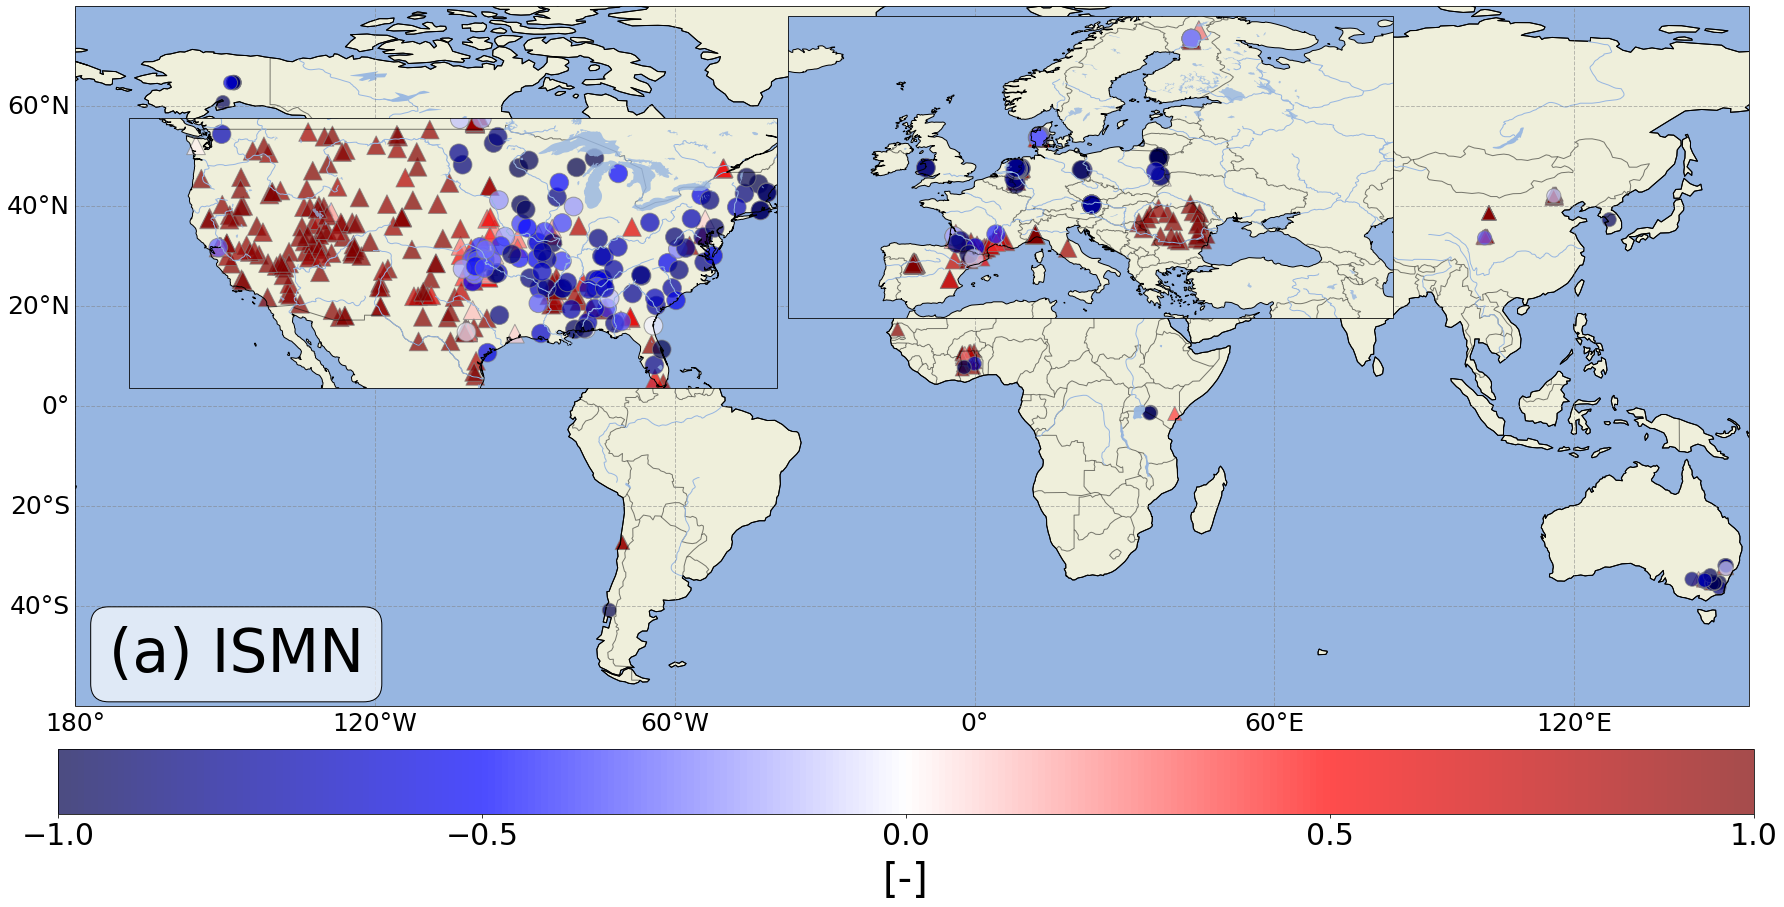

In [1320]:
fig ,axs= plt.subplots(figsize=(30, 30), subplot_kw={'projection': ccrs.PlateCarree()})
fig.set_facecolor('white')

cor_p1 = np.array([value > 0 for value in R_ISMN_all])
cor_n1 = np.array([value <= 0 for value in R_ISMN_all])

axs.scatter(np.array(lon_all)[cor_p1], np.array(lat_all)[cor_p1], c=np.array(R_ISMN_all)[cor_p1], cmap='seismic', transform=ccrs.PlateCarree(),s=200, edgecolor='gray',norm=Normalize(-1,1),marker='^',alpha=0.7)
axs.scatter(np.array(lon_all)[cor_n1], np.array(lat_all)[cor_n1], c=np.array(R_ISMN_all)[cor_n1], cmap='seismic', transform=ccrs.PlateCarree(),s=200, edgecolor='gray',norm=Normalize(-1,1),marker='o',alpha=0.7)

axs.coastlines()
axs.add_feature(cfeature.LAND)
axs.add_feature(cfeature.OCEAN)
axs.add_feature(cfeature.COASTLINE)
axs.add_feature(cfeature.BORDERS, linestyle='-', alpha=.5)
axs.add_feature(cfeature.LAKES, alpha=0.95)
axs.add_feature(cfeature.RIVERS)
axs.set_extent([-180, 160, -60, 80], crs=ccrs.PlateCarree())
axs.set_xlim(-180, 155)
axs.set_ylim(-60, 80)

gl = axs.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
gl.xlabel_style = {'size': 25}
gl.ylabel_style = {'size': 25}
axs.text(0.02,0.05,'(a) ISMN',transform=axs.transAxes,fontsize=60,bbox={'boxstyle': 'round,pad=0.3', 'facecolor': (1, 1, 1, 0.7), 'edgecolor': 'black'})

'ㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡ'
'CONUS'
ax_inset = fig.add_axes([0.15, 0.40, 0.3, 0.3], projection=ccrs.PlateCarree())
ax_inset.set_extent([-130, -70, 25, 50], crs=ccrs.PlateCarree())  # CONUS 지역

ax_inset.coastlines()
ax_inset.add_feature(cfeature.LAND)
ax_inset.add_feature(cfeature.OCEAN)
ax_inset.add_feature(cfeature.BORDERS, linestyle='-', alpha=0.5)
ax_inset.add_feature(cfeature.LAKES, alpha=0.8)
ax_inset.add_feature(cfeature.RIVERS)

ax_inset.scatter(np.array(lon_all)[cor_p1], np.array(lat_all)[cor_p1], c=np.array(R_ISMN_all)[cor_p1], cmap='seismic', transform=ccrs.PlateCarree(),s=350, edgecolor='gray',norm=Normalize(-1,1),marker='^',alpha=0.7)
ax_inset.scatter(np.array(lon_all)[cor_n1], np.array(lat_all)[cor_n1], c=np.array(R_ISMN_all)[cor_n1], cmap='seismic', transform=ccrs.PlateCarree(),s=350, edgecolor='gray',norm=Normalize(-1,1),marker='o',alpha=0.7)

'ㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡ'
'EU'
ax_inset2 = fig.add_axes([0.455, 0.5, 0.28, 0.18], projection=ccrs.PlateCarree())
ax_inset2.set_extent([-20, 50, 35, 70], crs=ccrs.PlateCarree())  # 유럽 지역 범위 설정

ax_inset2.coastlines()
ax_inset2.add_feature(cfeature.LAND)
ax_inset2.add_feature(cfeature.OCEAN)
ax_inset2.add_feature(cfeature.BORDERS, linestyle='-', alpha=0.5)
ax_inset2.add_feature(cfeature.LAKES, alpha=0.8)
ax_inset2.add_feature(cfeature.RIVERS)

ax_inset2.scatter(np.array(lon_all)[cor_p1], np.array(lat_all)[cor_p1], c=np.array(R_ISMN_all)[cor_p1], cmap='seismic', transform=ccrs.PlateCarree(),s=350, edgecolor='gray',norm=Normalize(-1,1),marker='^',alpha=0.7)
ax_inset2.scatter(np.array(lon_all)[cor_n1], np.array(lat_all)[cor_n1], c=np.array(R_ISMN_all)[cor_n1], cmap='seismic', transform=ccrs.PlateCarree(),s=350, edgecolor='gray',norm=Normalize(-1,1),marker='o',alpha=0.7)

'ㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡ'
'colorbar'
axpos = axs.get_position()
cbar_ax = fig.add_axes([axpos.x0-0.008, axpos.y0-0.05, 0.785, 0.03])
cbar = fig.colorbar(axs.collections[0], cax=cbar_ax, ticks=np.arange(-1,1.1,0.5),orientation='horizontal')
cbar.ax.tick_params(labelsize=30)
cbar.set_label('[-]', fontsize=40,labelpad=10)
plt.savefig(fname+'figure 6 R(smm,ts) ISMN all station', dpi=600, bbox_inches = 'tight', pad_inches = 0.02)
plt.show()

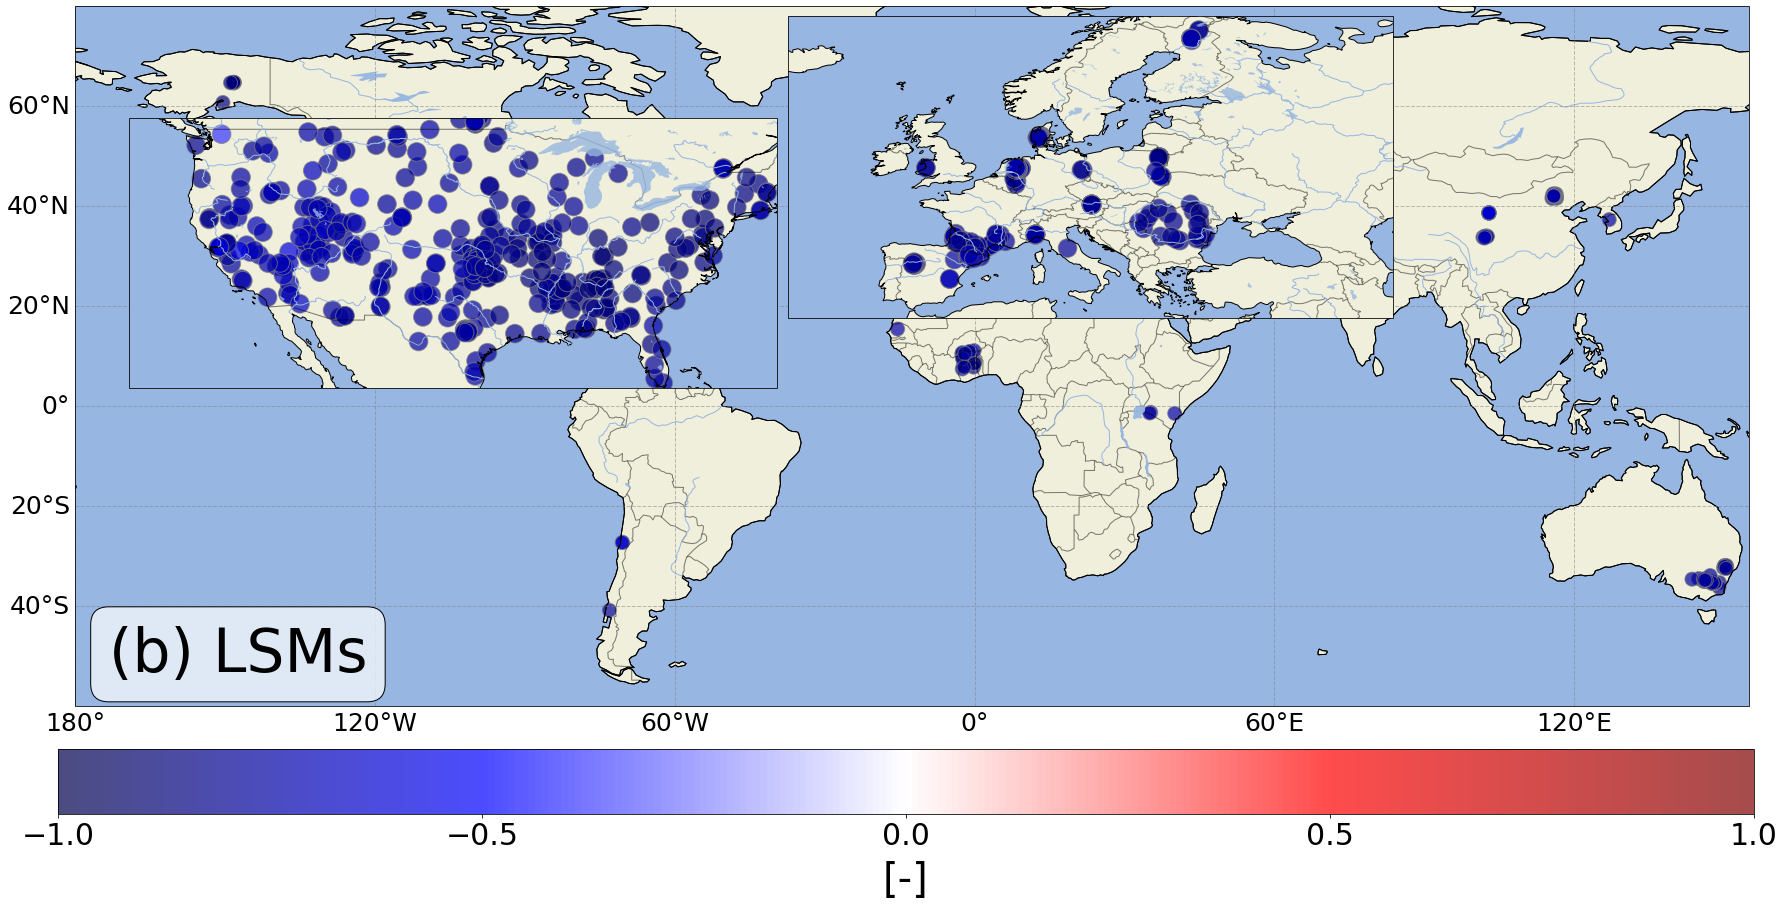

In [1321]:
fig ,axs= plt.subplots(figsize=(30, 30), subplot_kw={'projection': ccrs.PlateCarree()})
fig.set_facecolor('white')

cor_p1 = np.array([value > 0 for value in R_LSM_all])
cor_n1 = np.array([value <= 0 for value in R_LSM_all])

axs.scatter(np.array(lon_all)[cor_p1], np.array(lat_all)[cor_p1], c=np.array(R_LSM_all)[cor_p1], cmap='seismic', transform=ccrs.PlateCarree(),s=200, edgecolor='gray',norm=Normalize(-1,1),marker='^',alpha=0.7)
axs.scatter(np.array(lon_all)[cor_n1], np.array(lat_all)[cor_n1], c=np.array(R_LSM_all)[cor_n1], cmap='seismic', transform=ccrs.PlateCarree(),s=200, edgecolor='gray',norm=Normalize(-1,1),marker='o',alpha=0.7)

axs.coastlines()
axs.add_feature(cfeature.LAND)
axs.add_feature(cfeature.OCEAN)
axs.add_feature(cfeature.COASTLINE)
axs.add_feature(cfeature.BORDERS, linestyle='-', alpha=.5)
axs.add_feature(cfeature.LAKES, alpha=0.95)
axs.add_feature(cfeature.RIVERS)
axs.set_extent([-180, 160, -60, 80], crs=ccrs.PlateCarree())
axs.set_xlim(-180, 155)
axs.set_ylim(-60, 80)

gl = axs.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
gl.xlabel_style = {'size': 25}
gl.ylabel_style = {'size': 25}
axs.text(0.02,0.05,'(b) LSMs',transform=axs.transAxes,fontsize=60,bbox={'boxstyle': 'round,pad=0.3', 'facecolor': (1, 1, 1, 0.7), 'edgecolor': 'black'})

'ㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡ'
'CONUS'
ax_inset = fig.add_axes([0.15, 0.40, 0.3, 0.3], projection=ccrs.PlateCarree())
ax_inset.set_extent([-130, -70, 25, 50], crs=ccrs.PlateCarree())  # CONUS 지역

ax_inset.coastlines()
ax_inset.add_feature(cfeature.LAND)
ax_inset.add_feature(cfeature.OCEAN)
ax_inset.add_feature(cfeature.BORDERS, linestyle='-', alpha=0.5)
ax_inset.add_feature(cfeature.LAKES, alpha=0.8)
ax_inset.add_feature(cfeature.RIVERS)

ax_inset.scatter(np.array(lon_all)[cor_p1], np.array(lat_all)[cor_p1], c=np.array(R_LSM_all)[cor_p1], cmap='seismic', transform=ccrs.PlateCarree(),s=350, edgecolor='gray',norm=Normalize(-1,1),marker='^',alpha=0.7)
ax_inset.scatter(np.array(lon_all)[cor_n1], np.array(lat_all)[cor_n1], c=np.array(R_LSM_all)[cor_n1], cmap='seismic', transform=ccrs.PlateCarree(),s=350, edgecolor='gray',norm=Normalize(-1,1),marker='o',alpha=0.7)

'ㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡ'
'EU'
ax_inset2 = fig.add_axes([0.455, 0.5, 0.28, 0.18], projection=ccrs.PlateCarree())
ax_inset2.set_extent([-20, 50, 35, 70], crs=ccrs.PlateCarree())  # 유럽 지역 범위 설정

ax_inset2.coastlines()
ax_inset2.add_feature(cfeature.LAND)
ax_inset2.add_feature(cfeature.OCEAN)
ax_inset2.add_feature(cfeature.BORDERS, linestyle='-', alpha=0.5)
ax_inset2.add_feature(cfeature.LAKES, alpha=0.8)
ax_inset2.add_feature(cfeature.RIVERS)

ax_inset2.scatter(np.array(lon_all)[cor_p1], np.array(lat_all)[cor_p1], c=np.array(R_LSM_all)[cor_p1], cmap='seismic', transform=ccrs.PlateCarree(),s=350, edgecolor='gray',norm=Normalize(-1,1),marker='^',alpha=0.7)
ax_inset2.scatter(np.array(lon_all)[cor_n1], np.array(lat_all)[cor_n1], c=np.array(R_LSM_all)[cor_n1], cmap='seismic', transform=ccrs.PlateCarree(),s=350, edgecolor='gray',norm=Normalize(-1,1),marker='o',alpha=0.7)

'ㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡ'
'colorbar'
axpos = axs.get_position()
cbar_ax = fig.add_axes([axpos.x0-0.008, axpos.y0-0.05, 0.785, 0.03])
cbar = fig.colorbar(axs.collections[0], cax=cbar_ax, ticks=np.arange(-1,1.1,0.5),orientation='horizontal')
cbar.ax.tick_params(labelsize=30)
cbar.set_label('[-]', fontsize=40,labelpad=10)
plt.savefig(fname+'figure 6 R(smm,ts) model all station', dpi=600, bbox_inches = 'tight', pad_inches = 0.02)
plt.show()

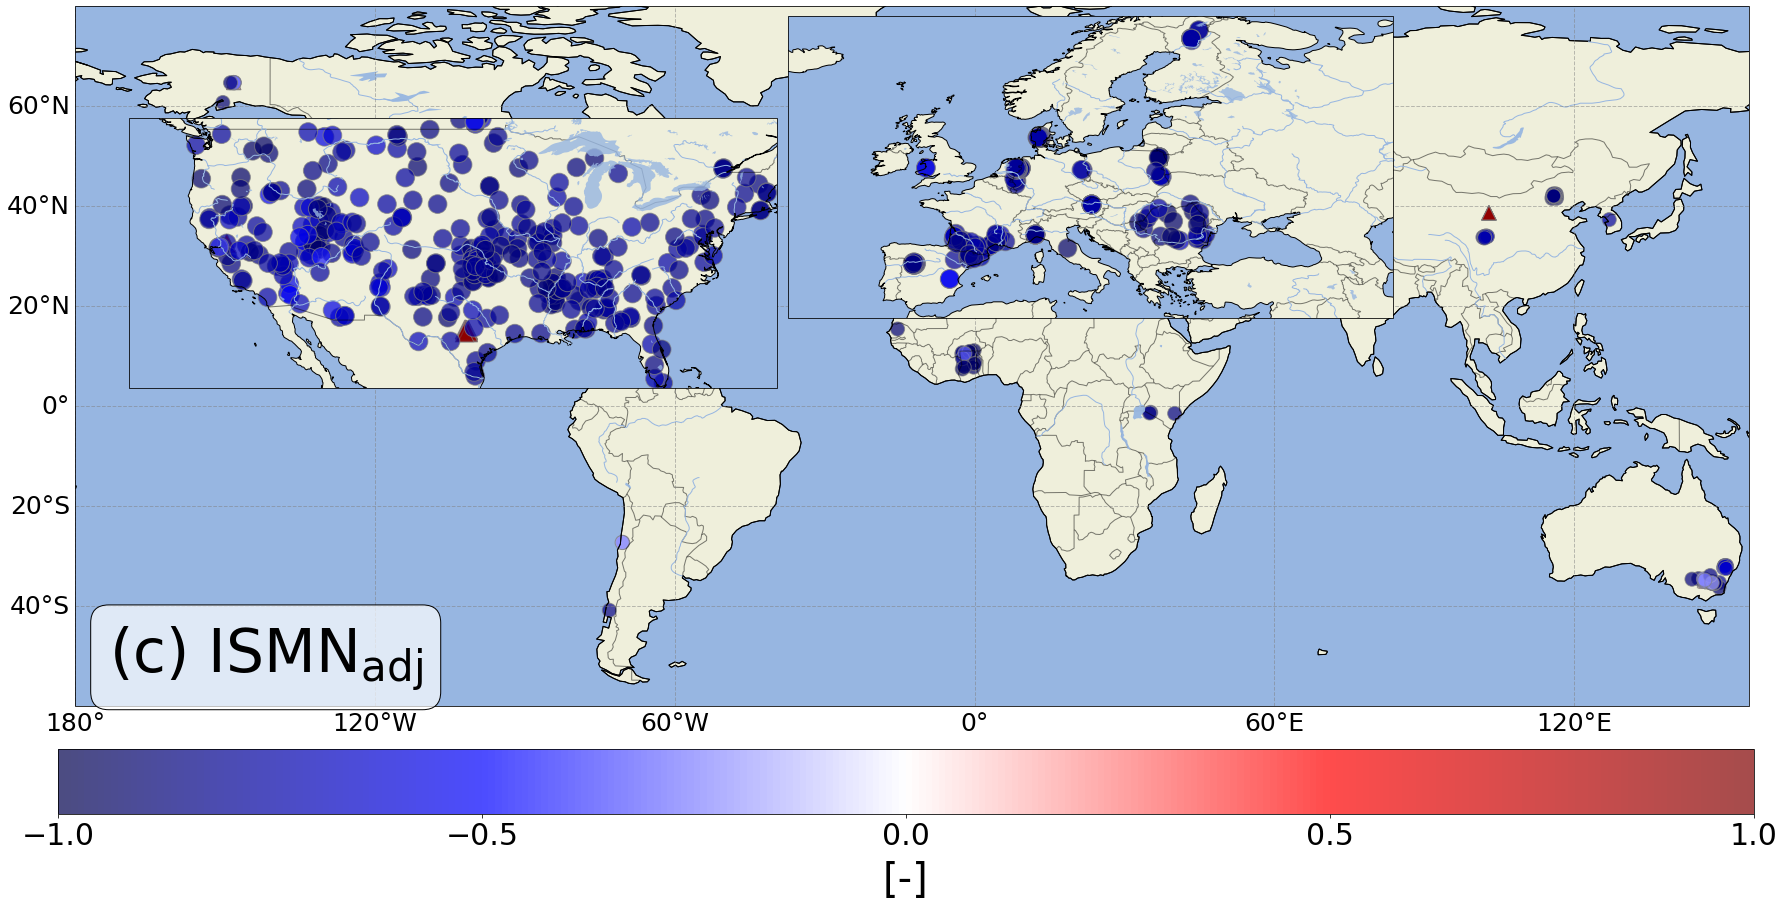

In [1322]:
fig ,axs= plt.subplots(figsize=(30, 30), subplot_kw={'projection': ccrs.PlateCarree()})
fig.set_facecolor('white')

cor_p1 = np.array([value > 0 for value in R_adj_all])
cor_n1 = np.array([value <= 0 for value in R_adj_all])

axs.scatter(np.array(lon_all)[cor_p1], np.array(lat_all)[cor_p1], c=np.array(R_adj_all)[cor_p1], cmap='seismic', transform=ccrs.PlateCarree(),s=200, edgecolor='gray',norm=Normalize(-1,1),marker='^',alpha=0.7)
axs.scatter(np.array(lon_all)[cor_n1], np.array(lat_all)[cor_n1], c=np.array(R_adj_all)[cor_n1], cmap='seismic', transform=ccrs.PlateCarree(),s=200, edgecolor='gray',norm=Normalize(-1,1),marker='o',alpha=0.7)

axs.coastlines()
axs.add_feature(cfeature.LAND)
axs.add_feature(cfeature.OCEAN)
axs.add_feature(cfeature.COASTLINE)
axs.add_feature(cfeature.BORDERS, linestyle='-', alpha=.5)
axs.add_feature(cfeature.LAKES, alpha=0.95)
axs.add_feature(cfeature.RIVERS)
axs.set_extent([-180, 160, -60, 80], crs=ccrs.PlateCarree())
axs.set_xlim(-180, 155)
axs.set_ylim(-60, 80)

gl = axs.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
gl.xlabel_style = {'size': 25}
gl.ylabel_style = {'size': 25}
axs.text(0.02,0.05,r'(c) ISMN$_{\text{adj}}$',transform=axs.transAxes,fontsize=60,bbox={'boxstyle': 'round,pad=0.3', 'facecolor': (1, 1, 1, 0.7), 'edgecolor': 'black'})

'ㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡ'
'CONUS'
ax_inset = fig.add_axes([0.15, 0.40, 0.3, 0.3], projection=ccrs.PlateCarree())
ax_inset.set_extent([-130, -70, 25, 50], crs=ccrs.PlateCarree())  # CONUS 지역

ax_inset.coastlines()
ax_inset.add_feature(cfeature.LAND)
ax_inset.add_feature(cfeature.OCEAN)
ax_inset.add_feature(cfeature.BORDERS, linestyle='-', alpha=0.5)
ax_inset.add_feature(cfeature.LAKES, alpha=0.8)
ax_inset.add_feature(cfeature.RIVERS)

ax_inset.scatter(np.array(lon_all)[cor_p1], np.array(lat_all)[cor_p1], c=np.array(R_adj_all)[cor_p1], cmap='seismic', transform=ccrs.PlateCarree(),s=350, edgecolor='gray',norm=Normalize(-1,1),marker='^',alpha=0.7)
ax_inset.scatter(np.array(lon_all)[cor_n1], np.array(lat_all)[cor_n1], c=np.array(R_adj_all)[cor_n1], cmap='seismic', transform=ccrs.PlateCarree(),s=350, edgecolor='gray',norm=Normalize(-1,1),marker='o',alpha=0.7)

'ㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡ'
'EU'
ax_inset2 = fig.add_axes([0.455, 0.5, 0.28, 0.18], projection=ccrs.PlateCarree())
ax_inset2.set_extent([-20, 50, 35, 70], crs=ccrs.PlateCarree())  # 유럽 지역 범위 설정

ax_inset2.coastlines()
ax_inset2.add_feature(cfeature.LAND)
ax_inset2.add_feature(cfeature.OCEAN)
ax_inset2.add_feature(cfeature.BORDERS, linestyle='-', alpha=0.5)
ax_inset2.add_feature(cfeature.LAKES, alpha=0.8)
ax_inset2.add_feature(cfeature.RIVERS)

ax_inset2.scatter(np.array(lon_all)[cor_p1], np.array(lat_all)[cor_p1], c=np.array(R_adj_all)[cor_p1], cmap='seismic', transform=ccrs.PlateCarree(),s=350, edgecolor='gray',norm=Normalize(-1,1),marker='^',alpha=0.7)
ax_inset2.scatter(np.array(lon_all)[cor_n1], np.array(lat_all)[cor_n1], c=np.array(R_adj_all)[cor_n1], cmap='seismic', transform=ccrs.PlateCarree(),s=350, edgecolor='gray',norm=Normalize(-1,1),marker='o',alpha=0.7)

'ㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡ'
'colorbar'
axpos = axs.get_position()
cbar_ax = fig.add_axes([axpos.x0-0.008, axpos.y0-0.05, 0.785, 0.03])
cbar = fig.colorbar(axs.collections[0], cax=cbar_ax, ticks=np.arange(-1,1.1,0.5),orientation='horizontal')
cbar.ax.tick_params(labelsize=30)
cbar.set_label('[-]', fontsize=40,labelpad=10)
plt.savefig(fname+'figure 6 R(smm,ts) ISMN_adj all station', dpi=600, bbox_inches = 'tight', pad_inches = 0.02)
plt.show()

### max hour -(d),(e),(f)

In [1323]:
colors = [
    (0.0, "midnightblue"),  # 자정
    (0.2, "blue"),          # 새벽
    (0.4, "cyan"),          # 아침
    (0.5, "yellow"),        # 정오
    (0.6, "orange"),        # 오후
    (0.8, "red"),           # 저녁
    (1.0, "darkred")        # 밤
]
hour_cmap = LinearSegmentedColormap.from_list("day_night", colors, N=24)

# 색상 매핑
norm = plt.Normalize(0, 23)

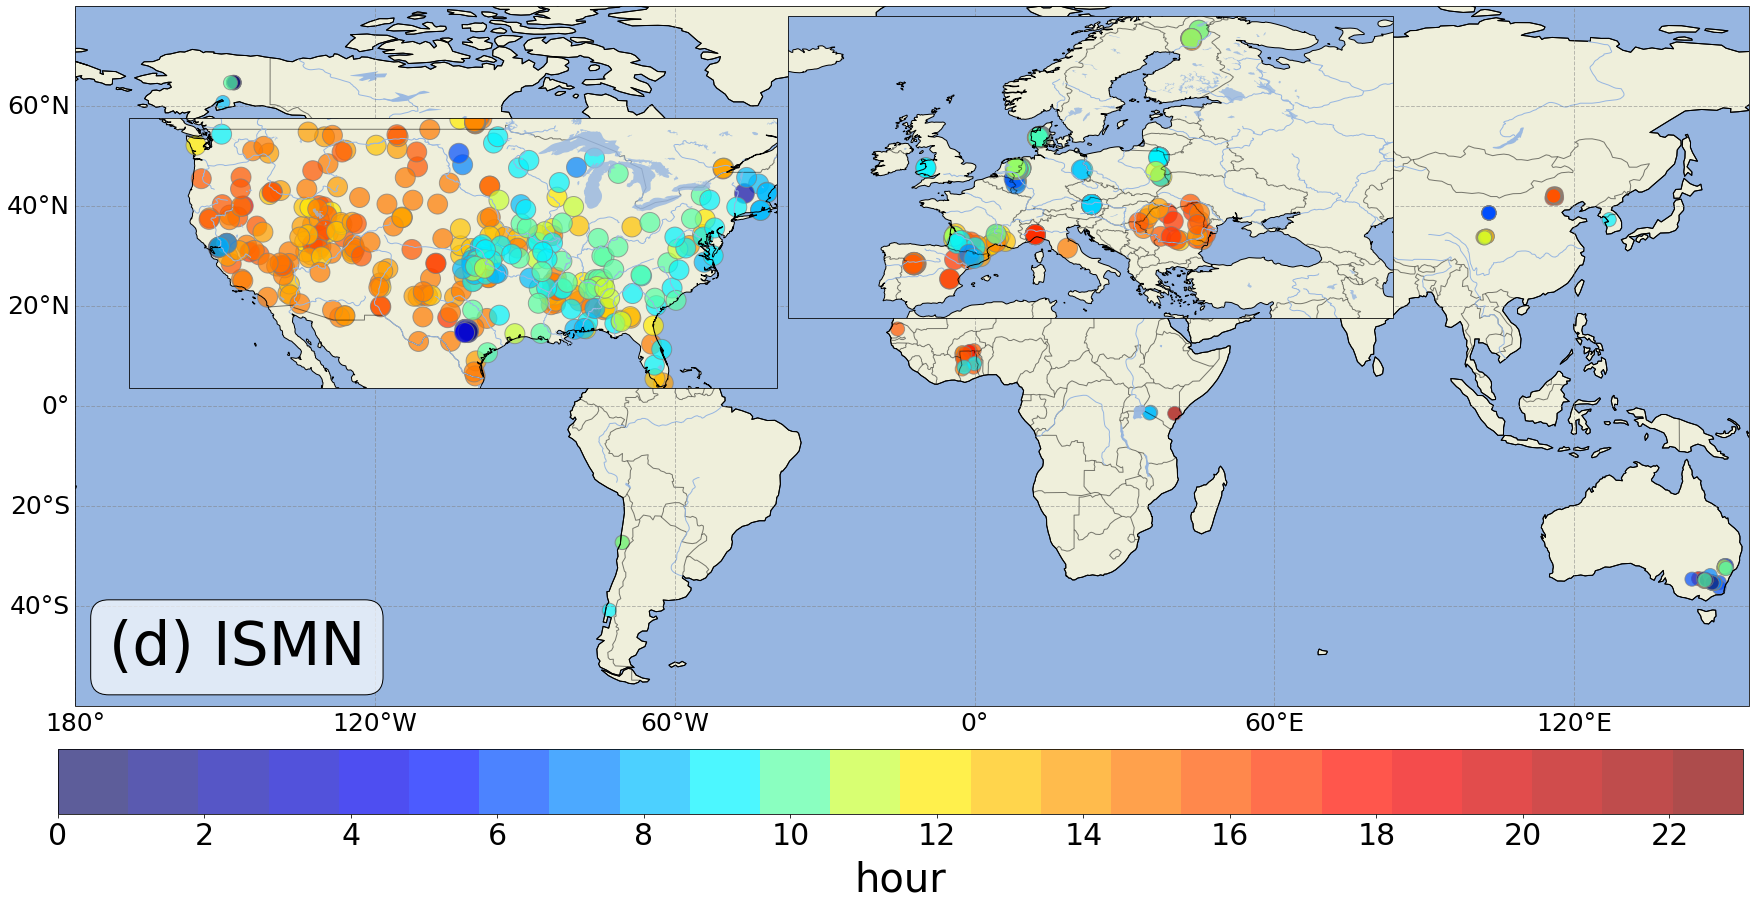

In [1324]:
fig ,axs= plt.subplots(figsize=(30, 30), subplot_kw={'projection': ccrs.PlateCarree()})
fig.set_facecolor('white')

axs.scatter(np.array(lon_all), np.array(lat_all), c=np.array(max_hr_ISMN_all), cmap=hour_cmap, transform=ccrs.PlateCarree(),s=200, edgecolor='gray',marker='o',alpha=0.7,vmin=0,vmax=23)

axs.coastlines()
axs.add_feature(cfeature.LAND)
axs.add_feature(cfeature.OCEAN)
axs.add_feature(cfeature.COASTLINE)
axs.add_feature(cfeature.BORDERS, linestyle='-', alpha=.5)
axs.add_feature(cfeature.LAKES, alpha=0.95)
axs.add_feature(cfeature.RIVERS)
axs.set_extent([-180, 160, -60, 80], crs=ccrs.PlateCarree())
axs.set_xlim(-180, 155)
axs.set_ylim(-60, 80)

gl = axs.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
gl.xlabel_style = {'size': 25}
gl.ylabel_style = {'size': 25}
axs.text(0.02,0.06,'(d) ISMN',transform=axs.transAxes,fontsize=60,bbox={'boxstyle': 'round,pad=0.3', 'facecolor': (1, 1, 1, 0.7), 'edgecolor': 'black'})

'ㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡ'
'CONUS'
ax_inset = fig.add_axes([0.15, 0.40, 0.3, 0.3], projection=ccrs.PlateCarree())
ax_inset.set_extent([-130, -70, 25, 50], crs=ccrs.PlateCarree())  # CONUS 지역

ax_inset.coastlines()
ax_inset.add_feature(cfeature.LAND)
ax_inset.add_feature(cfeature.OCEAN)
ax_inset.add_feature(cfeature.BORDERS, linestyle='-', alpha=0.5)
ax_inset.add_feature(cfeature.LAKES, alpha=0.8)
ax_inset.add_feature(cfeature.RIVERS)

ax_inset.scatter(np.array(lon_all), np.array(lat_all), c=np.array(max_hr_ISMN_all), cmap=hour_cmap, transform=ccrs.PlateCarree(),s=400, edgecolor='gray',marker='o',alpha=0.7,vmin=0,vmax=23)

'ㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡ'
'EU'
ax_inset2 = fig.add_axes([0.455, 0.5, 0.28, 0.18], projection=ccrs.PlateCarree())
ax_inset2.set_extent([-20, 50, 35, 70], crs=ccrs.PlateCarree())  # 유럽 지역 범위 설정

ax_inset2.coastlines()
ax_inset2.add_feature(cfeature.LAND)
ax_inset2.add_feature(cfeature.OCEAN)
ax_inset2.add_feature(cfeature.BORDERS, linestyle='-', alpha=0.5)
ax_inset2.add_feature(cfeature.LAKES, alpha=0.8)
ax_inset2.add_feature(cfeature.RIVERS)

ax_inset2.scatter(np.array(lon_all), np.array(lat_all), c=np.array(max_hr_ISMN_all), cmap=hour_cmap, transform=ccrs.PlateCarree(),s=400, edgecolor='gray',marker='o',alpha=0.7,vmin=0,vmax=23)

'ㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡ'
'colorbar'
axpos = axs.get_position()
cbar_ax = fig.add_axes([axpos.x0-0.008, axpos.y0-0.05, 0.78, 0.03])
cbar = fig.colorbar(axs.collections[0], cax=cbar_ax, ticks=np.arange(0,23,2),orientation='horizontal')
cbar.ax.tick_params(labelsize=30)
cbar.set_label('hour', fontsize=40,labelpad=10)
plt.savefig(fname+'figure 6 max hour ISMN2', dpi=600, bbox_inches = 'tight', pad_inches = 0.02)
plt.show()

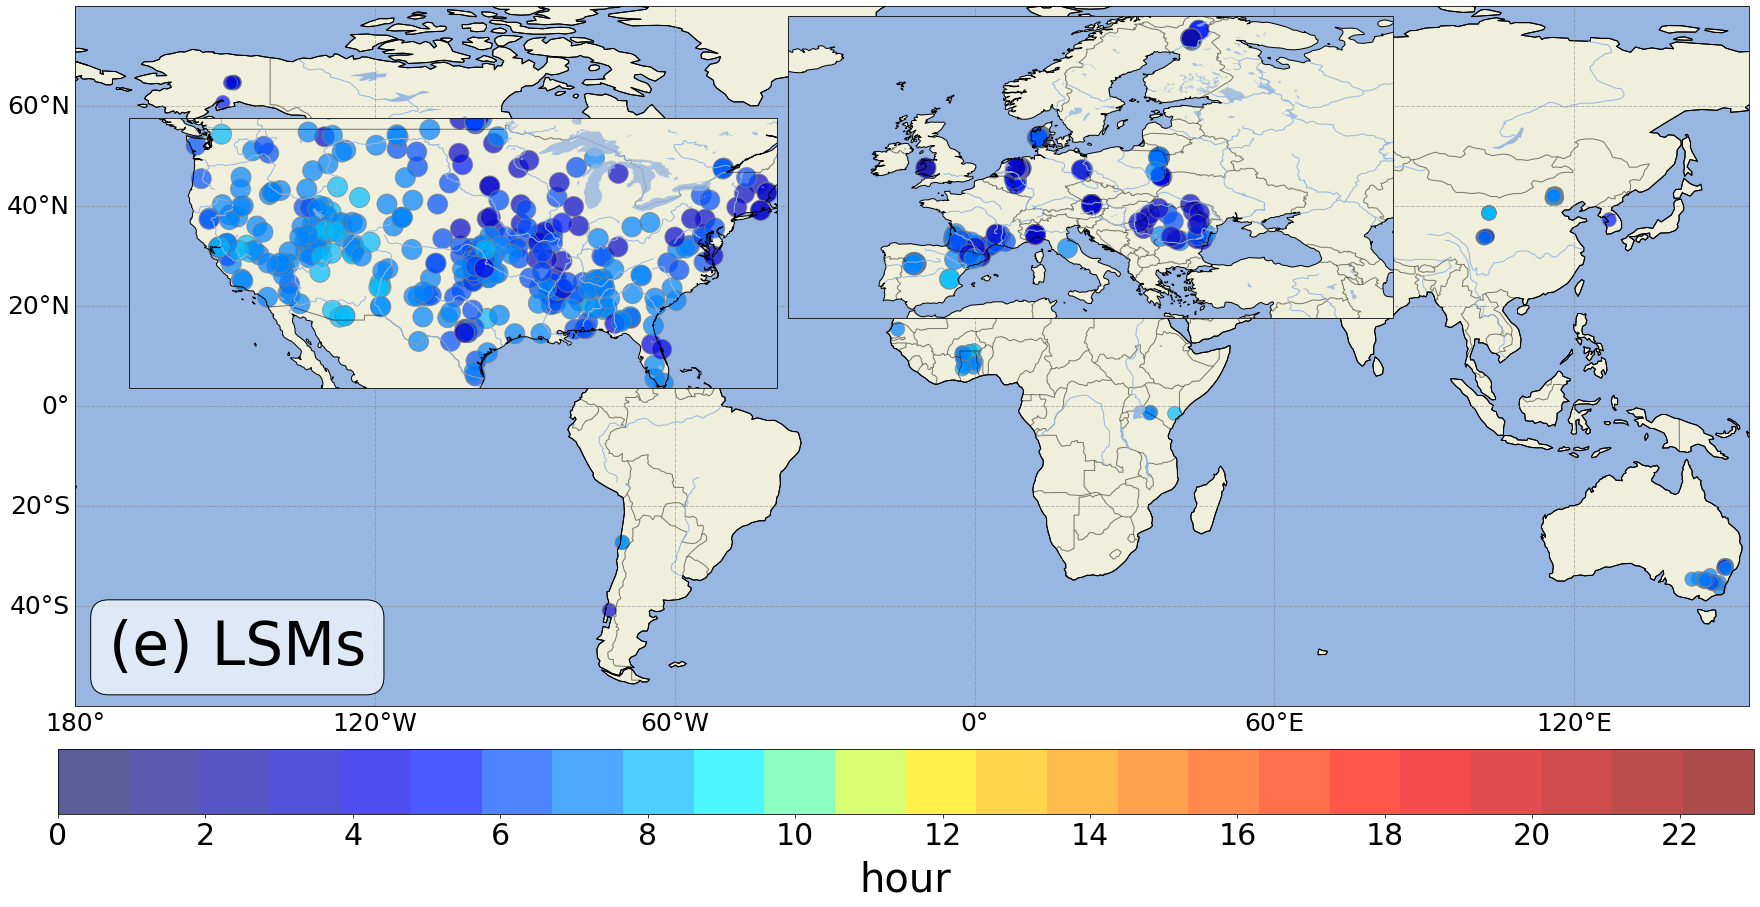

In [1325]:
fig ,axs= plt.subplots(figsize=(30, 30), subplot_kw={'projection': ccrs.PlateCarree()})
fig.set_facecolor('white')

axs.scatter(np.array(lon_all), np.array(lat_all), c=np.array(max_hr_LSM_all), cmap=hour_cmap, transform=ccrs.PlateCarree(),s=200, edgecolor='gray',marker='o',alpha=0.7,vmin=0,vmax=23)

axs.coastlines()
axs.add_feature(cfeature.LAND)
axs.add_feature(cfeature.OCEAN)
axs.add_feature(cfeature.COASTLINE)
axs.add_feature(cfeature.BORDERS, linestyle='-', alpha=.5)
axs.add_feature(cfeature.LAKES, alpha=0.95)
axs.add_feature(cfeature.RIVERS)
axs.set_extent([-180, 160, -60, 80], crs=ccrs.PlateCarree())
axs.set_xlim(-180, 155)
axs.set_ylim(-60, 80)

gl = axs.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
gl.xlabel_style = {'size': 25}
gl.ylabel_style = {'size': 25}
axs.text(0.02,0.06,'(e) LSMs',transform=axs.transAxes,fontsize=60,bbox={'boxstyle': 'round,pad=0.3', 'facecolor': (1, 1, 1, 0.7), 'edgecolor': 'black'})

'ㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡ'
'CONUS'
ax_inset = fig.add_axes([0.15, 0.40, 0.3, 0.3], projection=ccrs.PlateCarree())
ax_inset.set_extent([-130, -70, 25, 50], crs=ccrs.PlateCarree())  # CONUS 지역

ax_inset.coastlines()
ax_inset.add_feature(cfeature.LAND)
ax_inset.add_feature(cfeature.OCEAN)
ax_inset.add_feature(cfeature.BORDERS, linestyle='-', alpha=0.5)
ax_inset.add_feature(cfeature.LAKES, alpha=0.8)
ax_inset.add_feature(cfeature.RIVERS)

ax_inset.scatter(np.array(lon_all), np.array(lat_all), c=np.array(max_hr_LSM_all), cmap=hour_cmap, transform=ccrs.PlateCarree(),s=400, edgecolor='gray',marker='o',alpha=0.7,vmin=0,vmax=23)

'ㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡ'
'EU'
ax_inset2 = fig.add_axes([0.455, 0.5, 0.28, 0.18], projection=ccrs.PlateCarree())
ax_inset2.set_extent([-20, 50, 35, 70], crs=ccrs.PlateCarree())  # 유럽 지역 범위 설정

ax_inset2.coastlines()
ax_inset2.add_feature(cfeature.LAND)
ax_inset2.add_feature(cfeature.OCEAN)
ax_inset2.add_feature(cfeature.BORDERS, linestyle='-', alpha=0.5)
ax_inset2.add_feature(cfeature.LAKES, alpha=0.8)
ax_inset2.add_feature(cfeature.RIVERS)

ax_inset2.scatter(np.array(lon_all), np.array(lat_all), c=np.array(max_hr_LSM_all), cmap=hour_cmap, transform=ccrs.PlateCarree(),s=400, edgecolor='gray',marker='o',alpha=0.7,vmin=0,vmax=23)

'ㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡ'
'colorbar'
axpos = axs.get_position()
cbar_ax = fig.add_axes([axpos.x0-0.008, axpos.y0-0.05, 0.785, 0.03])
cbar = fig.colorbar(axs.collections[0], cax=cbar_ax, ticks=np.arange(0,23,2),orientation='horizontal')
cbar.ax.tick_params(labelsize=30)
cbar.set_label('hour', fontsize=40,labelpad=10)
plt.savefig(fname+'figure 6 max hour model', dpi=600, bbox_inches = 'tight', pad_inches = 0.02)
plt.show()

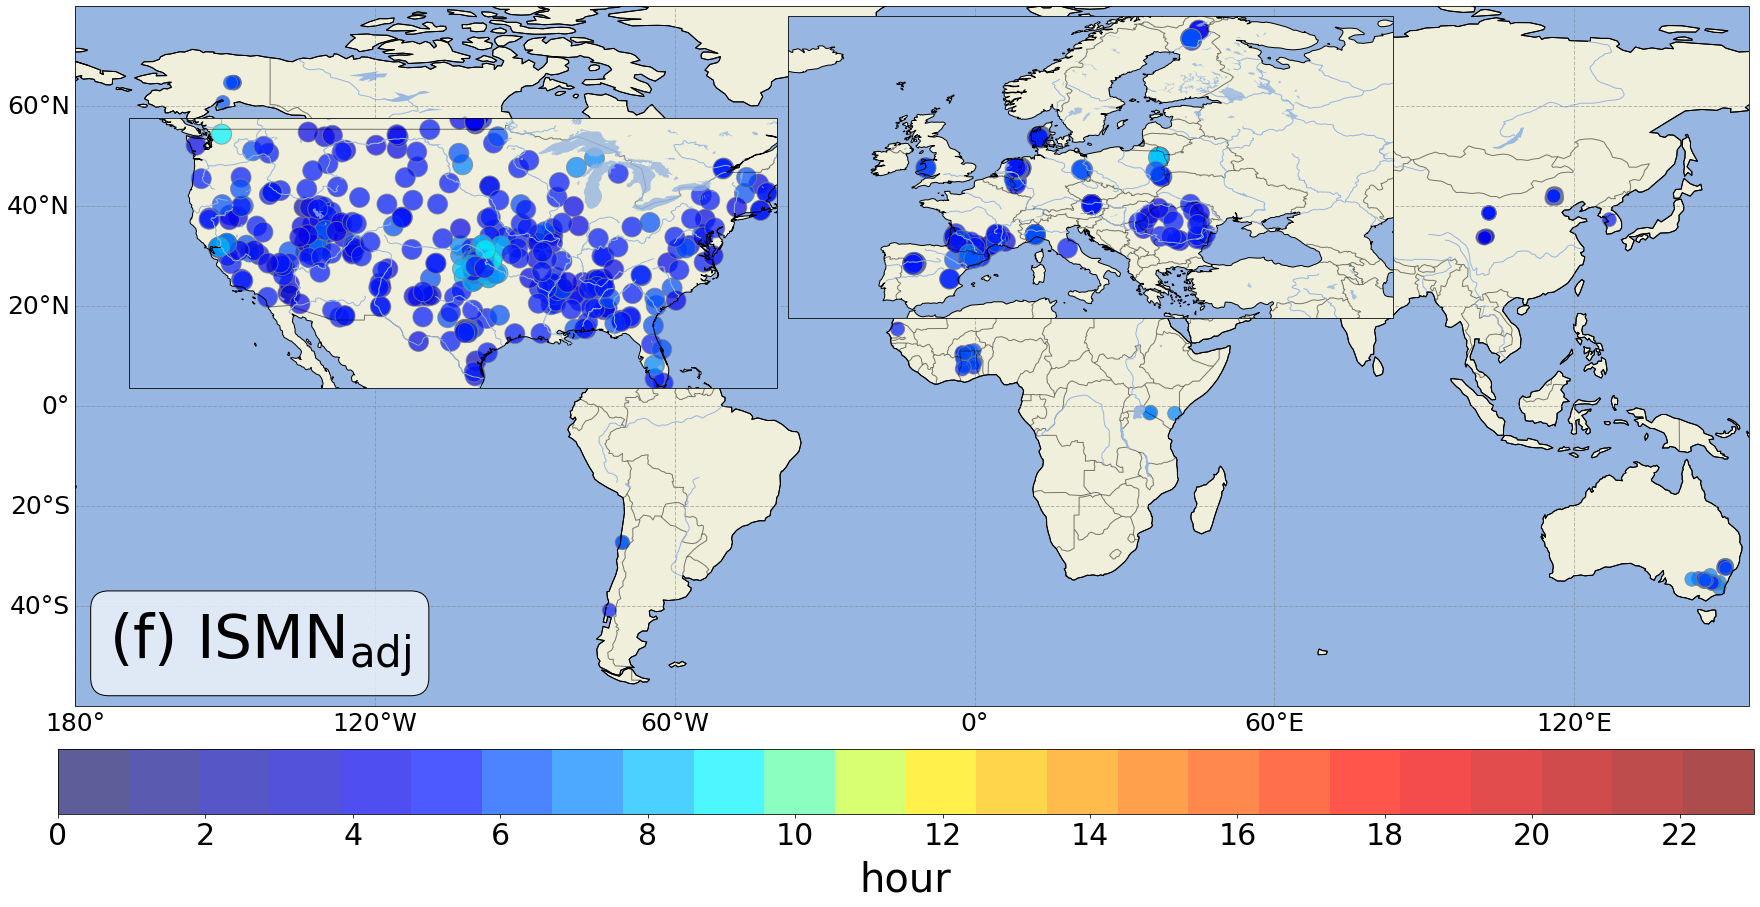

In [1326]:
fig ,axs= plt.subplots(figsize=(30, 30), subplot_kw={'projection': ccrs.PlateCarree()})
fig.set_facecolor('white')

axs.scatter(np.array(lon_all), np.array(lat_all), c=np.array(max_hr_adj_all), cmap=hour_cmap, transform=ccrs.PlateCarree(),s=200, edgecolor='gray',marker='o',alpha=0.7,vmin=0,vmax=23)

axs.coastlines()
axs.add_feature(cfeature.LAND)
axs.add_feature(cfeature.OCEAN)
axs.add_feature(cfeature.COASTLINE)
axs.add_feature(cfeature.BORDERS, linestyle='-', alpha=.5)
axs.add_feature(cfeature.LAKES, alpha=0.95)
axs.add_feature(cfeature.RIVERS)
axs.set_extent([-180, 160, -60, 80], crs=ccrs.PlateCarree())
axs.set_xlim(-180, 155)
axs.set_ylim(-60, 80)

gl = axs.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
gl.xlabel_style = {'size': 25}
gl.ylabel_style = {'size': 25}
axs.text(0.02,0.07,r'(f) ISMN$_{\text{adj}}$',transform=axs.transAxes,fontsize=60,bbox={'boxstyle': 'round,pad=0.3', 'facecolor': (1, 1, 1, 0.7), 'edgecolor': 'black'})

'ㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡ'
'CONUS'
ax_inset = fig.add_axes([0.15, 0.40, 0.3, 0.3], projection=ccrs.PlateCarree())
ax_inset.set_extent([-130, -70, 25, 50], crs=ccrs.PlateCarree())  # CONUS 지역

ax_inset.coastlines()
ax_inset.add_feature(cfeature.LAND)
ax_inset.add_feature(cfeature.OCEAN)
ax_inset.add_feature(cfeature.BORDERS, linestyle='-', alpha=0.5)
ax_inset.add_feature(cfeature.LAKES, alpha=0.8)
ax_inset.add_feature(cfeature.RIVERS)

ax_inset.scatter(np.array(lon_all), np.array(lat_all), c=np.array(max_hr_adj_all), cmap=hour_cmap, transform=ccrs.PlateCarree(),s=400, edgecolor='gray',marker='o',alpha=0.7,vmin=0,vmax=23)

'ㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡ'
'EU'
ax_inset2 = fig.add_axes([0.455, 0.5, 0.28, 0.18], projection=ccrs.PlateCarree())
ax_inset2.set_extent([-20, 50, 35, 70], crs=ccrs.PlateCarree())  # 유럽 지역 범위 설정

ax_inset2.coastlines()
ax_inset2.add_feature(cfeature.LAND)
ax_inset2.add_feature(cfeature.OCEAN)
ax_inset2.add_feature(cfeature.BORDERS, linestyle='-', alpha=0.5)
ax_inset2.add_feature(cfeature.LAKES, alpha=0.8)
ax_inset2.add_feature(cfeature.RIVERS)

ax_inset2.scatter(np.array(lon_all), np.array(lat_all), c=np.array(max_hr_adj_all), cmap=hour_cmap, transform=ccrs.PlateCarree(),s=400, edgecolor='gray',marker='o',alpha=0.7,vmin=0,vmax=23)

'ㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡ'
'colorbar'
axpos = axs.get_position()
cbar_ax = fig.add_axes([axpos.x0-0.008, axpos.y0-0.05, 0.785, 0.03])
cbar = fig.colorbar(axs.collections[0], cax=cbar_ax, ticks=np.arange(0,23,2),orientation='horizontal')
cbar.ax.tick_params(labelsize=30)
cbar.set_label('hour', fontsize=40,labelpad=10)
plt.savefig(fname+'figure 6 max hour ISMN_adj', dpi=600, bbox_inches = 'tight', pad_inches = 0.02)
plt.show()

# Figure 7

## data

In [1040]:
ISMN_sm=sorted(glob.glob('/home/jnhan/python/power spectrum/data/final filter/sm/ISMN_filter/*.csv'))
ISMN_ts=sorted(glob.glob('/home/jnhan/python/power spectrum/data/final filter/ts/ISMN_filter/*.csv'))

ERA_data=sorted(glob.glob('/home/jnhan/python/power spectrum/data/ERA5/p_remove_250608/*.csv'))
MERRA_data=sorted(glob.glob('/home/jnhan/python/power spectrum/data/MERRA2/p_remove_250608/*.csv'))

TLO_sm=glob.glob('/home/jnhan/python/power spectrum/data/reference sensor/sm/TLO/*')
TDT_sm=glob.glob('/home/jnhan/python/power spectrum/data/reference sensor/sm/TDT/*')

TLO_st=[i.split('/')[-1][:-7] for i in TLO_sm]
TDT_st=[i.split('/')[-1][:-7] for i in TDT_sm]

In [1041]:
ISMN_sm=[item for item in ISMN_sm if not any(tlo in item for tlo in TLO_st)]
ISMN_sm=[item for item in ISMN_sm if not any(tlo in item for tlo in TDT_st)]

ISMN_ts=[item for item in ISMN_ts if not any(tlo in item for tlo in TLO_st)]
ISMN_ts=[item for item in ISMN_ts if not any(tlo in item for tlo in TDT_st)]

ERA_data=[item for item in ERA_data if not any(tlo in item for tlo in TDT_st)]
ERA_data=[item for item in ERA_data if not any(tlo in item for tlo in TLO_st)]

MERRA_data=[item for item in MERRA_data if not any(tlo in item for tlo in TDT_st)]
MERRA_data=[item for item in MERRA_data if not any(tlo in item for tlo in TLO_st)]

In [1042]:
ISMN_order=[i.split('/')[-1][:-7] for i in ISMN_sm]

ERA_data = sorted(ERA_data, key=lambda path: ISMN_order.index(next(a for a in ISMN_order if a in path)))
MERRA_data = sorted(MERRA_data, key=lambda path: ISMN_order.index(next(a for a in ISMN_order if a in path)))

In [1052]:
ERA_v,MERRA_v=(0.5, 0.5)
lat=[]
lon=[]
ISMN_cor_ano=[]
ISMN_cor_adj=[]
max_ts=[]
min_ts=[]
range_ts=[]
merge_list=[]
hourly_list=[]
bn_lat=[]
bn_lon=[]
bn_ISMN_cor_ano=[]
bn_ISMN_cor_adj=[]
bn_max_ts=[]
bn_min_ts=[]
bn_range_ts=[]
bn_merge_list=[]
bn_hourly_list=[]
before_noon=[]
error=[]
low_len=[]
idx=[]
bn_idx=[]
for i in range(len(ISMN_sm)):
    print(i,end='\r')
    try:
        ISMN=pd.read_csv(ISMN_sm[i],usecols={'date_time','soil_moisture','flag','anomaly','rm'},index_col='date_time',parse_dates=['date_time'])
        ERA=pd.read_csv(ERA_data[i],usecols={'date_time','sm','sm ano','ts','ts ano'},index_col='date_time',parse_dates=['date_time'])
        MERRA=pd.read_csv(MERRA_data[i],usecols={'date_time','sm','sm ano','ts','ts ano'},index_col='date_time',parse_dates=['date_time'])
        ts_ISMN=pd.read_csv(ISMN_ts[i],usecols={'date_time','soil_temperature','flag','anomaly'},index_col='date_time',parse_dates=['date_time'])
        ISMN2=pd.read_csv(ISMN_sm[i])
        
        ISMN=ISMN[ISMN['flag']=='G']
        ts_ISMN=ts_ISMN[ts_ISMN['flag']=='G']
        ISMN=ISMN[['soil_moisture','anomaly','rm']]
        ts_ISMN=ts_ISMN[['soil_temperature','anomaly']]
        
        ISMN.rename(columns={'soil_moisture':'ISMN sm','anomaly':'ISMN sm ano','rm':'ISMN rm'},inplace=True)
        ERA.rename(columns={'sm':'ERA sm','sm ano':'ERA sm ano','ts':'ERA ts','ts ano':'ERA ts ano'},inplace=True)
        MERRA.rename(columns={'sm':'MERRA sm','sm ano':'MERRA sm ano','ts':'MERRA ts','ts ano':'MERRA ts ano'},inplace=True)
        ts_ISMN.rename(columns={'soil_temperature':'ISMN ts','anomaly':'ISMN ts ano'},inplace=True)
        
        merged = ISMN.merge(ERA, left_index=True, right_index=True, how='inner')
        merged = merged.merge(MERRA, left_index=True, right_index=True, how='inner')
        merged = merged.merge(ts_ISMN, left_index=True, right_index=True, how='inner')
        merged = merged.dropna()

        if len(merged) > 2200:
            'ㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡ'
            'anomaly'
            fft_ISMN_ano=np.fft.fft(merged['ISMN sm ano'])
            ps_ISMN_ano=np.abs(fft_ISMN_ano)
            freq_ISMN_ano=np.fft.fftfreq(len(merged),d=1.0/len(fft_ISMN_ano))
            
            fft_ERA_ano=np.fft.fft(merged['ERA sm ano'])
            ps_ERA_ano=np.abs(fft_ERA_ano)
            freq_ERA_ano=np.fft.fftfreq(len(merged),d=1.0/len(fft_ERA_ano))
            
            fft_MERRA_ano=np.fft.fft(merged['MERRA sm ano'])
            ps_MERRA_ano=np.abs(fft_MERRA_ano)
            freq_MERRA_ano=np.fft.fftfreq(len(merged),d=1.0/len(fft_MERRA_ano))
            
            freq_24=int(len(freq_ISMN_ano)/24)
            freq_36=int(len(freq_ISMN_ano)/36)
            freq_12=int(len(freq_ISMN_ano)/12)
            
            df_ano=pd.DataFrame()
            df_ano['fft_ISMN_r']=fft_ISMN_ano.real
            df_ano['fft_ERA_r']=fft_ERA_ano.real
            df_ano['fft_MERRA_r']=fft_MERRA_ano.real
            df_ano['fft_m_r']=((ERA_v*df_ano['fft_ERA_r'])+(MERRA_v*df_ano['fft_MERRA_r']))
            df_ano['fft_ISMN_i']=fft_ISMN_ano.imag
            df_ano['fft_ERA_i']=fft_ERA_ano.imag
            df_ano['fft_MERRA_i']=fft_MERRA_ano.imag
            df_ano['fft_m_i']=((ERA_v*df_ano['fft_ERA_i'])+(MERRA_v*df_ano['fft_MERRA_i']))
            df_ano['ps_ISMN']=ps_ISMN_ano
            df_ano['ps_ERA']=ps_ERA_ano
            df_ano['ps_MERRA']=ps_MERRA_ano
            df_ano['ps_m']=((ERA_v*df_ano['ps_ERA'])+(MERRA_v*df_ano['ps_MERRA']))
            
            mv_ano=df_ano.rolling(window=24,center=True).mean()
            
            sf_ano_E=mv_ano['ps_ISMN']/mv_ano['ps_ERA']
            sf_ano_M=mv_ano['ps_ISMN']/mv_ano['ps_MERRA']
            sf_ano_all=mv_ano['ps_ISMN']/mv_ano['ps_m']
            
            fft_ano_r_E=sf_ano_E*df_ano['fft_ERA_r']
            fft_ano_i_E=sf_ano_E*df_ano['fft_ERA_i']
            fft_ano_r_M=sf_ano_M*df_ano['fft_MERRA_r']
            fft_ano_i_M=sf_ano_M*df_ano['fft_MERRA_i']
            fft_ano_r_all=sf_ano_all*df_ano['fft_m_r']
            fft_ano_i_all=sf_ano_all*df_ano['fft_m_i']
            
            fft_ano_resc_E=fft_ano_r_E+fft_ano_i_E*1j
            fft_ano_resc_M=fft_ano_r_M+fft_ano_i_M*1j
            fft_ano_resc_all=fft_ano_r_all+fft_ano_i_all*1j
            
            fft_ISMN_adj_ano_E=fft_ISMN_ano.copy()
            fft_ISMN_adj_ano_M=fft_ISMN_ano.copy()
            fft_ISMN_adj_ano_all=fft_ISMN_ano.copy()
            
            fft_ISMN_adj_ano_E[freq_36:freq_12]=fft_ano_resc_E[freq_36:freq_12]
            fft_ISMN_adj_ano_E[-freq_12:-freq_36]=fft_ano_resc_E[-freq_12:-freq_36]
            fft_ISMN_adj_ano_M[freq_36:freq_12]=fft_ano_resc_M[freq_36:freq_12]
            fft_ISMN_adj_ano_M[-freq_12:-freq_36]=fft_ano_resc_M[-freq_12:-freq_36]
            fft_ISMN_adj_ano_all[freq_36:freq_12]=fft_ano_resc_all[freq_36:freq_12]
            fft_ISMN_adj_ano_all[-freq_12:-freq_36]=fft_ano_resc_all[-freq_12:-freq_36]
            
            ps_ano_adj_E=np.abs(fft_ISMN_adj_ano_E)
            ps_ano_adj_M=np.abs(fft_ISMN_adj_ano_M)
            ps_ano_adj_all=np.abs(fft_ISMN_adj_ano_all)
            
            ifft_ISMN_ano_E=np.fft.ifft(fft_ISMN_adj_ano_E)
            ifft_ISMN_ano_real_E=ifft_ISMN_ano_E.real
            ifft_ISMN_ano_M=np.fft.ifft(fft_ISMN_adj_ano_M)
            ifft_ISMN_ano_real_M=ifft_ISMN_ano_M.real
            ifft_ISMN_ano_all=np.fft.ifft(fft_ISMN_adj_ano_all)
            ifft_ISMN_ano_real_all=ifft_ISMN_ano_all.real
            
            merged['ano_adj_E']=ifft_ISMN_ano_real_E
            merged['ano_adj_M']=ifft_ISMN_ano_real_M
            merged['ano_adj_all']=ifft_ISMN_ano_real_all
            
            merged_copy=merged.copy()
            merged_copy['date']=merged_copy.index.date
            merged_copy['hour']=merged_copy.index.hour
            merged_copy=merged_copy.groupby('date', group_keys=False).apply(adjust_night)
            filter_date=merged_copy.loc[merged_copy['night_adj'] < 0, 'date'].unique()
            merged_copy['night_adj2']=merged_copy['night_adj']
        
            for j in filter_date:
                filter_start=merged_copy[merged_copy['date'] == j][['night_adj']].copy()
                night_mean=np.mean(filter_start['night_adj'])
                filter_start['step1']=filter_start['night_adj']-night_mean
                filter_min=np.min(filter_start['step1'])
                if night_mean > 0 : 
                    if abs(filter_min) < 1:
                        filter_start['step2']=filter_start['step1']*abs(filter_min)
                        filter_start['step3']=filter_start['step2']+night_mean
                        merged_copy.loc[filter_start.index, 'night_adj2'] = filter_start['step3']
                    elif abs(filter_min) > 1:
                        filter_start['step2']=filter_start['step1']/abs(filter_min)
                        filter_start['step3']=filter_start['step2']+night_mean
                        merged_copy.loc[filter_start.index, 'night_adj2'] = filter_start['step3']
                elif night_mean < 0 :
                    if abs(filter_min) < 1:
                        filter_start['step2']=filter_start['step1']*abs(filter_min)
                        filter_start['step3']=filter_start['step2']+abs(np.min(filter_start['step2']))
                        merged_copy.loc[filter_start.index, 'night_adj2'] = filter_start['step3']
                    elif abs(filter_min) > 1:
                        filter_start['step2']=filter_start['step1']/abs(filter_min)
                        filter_start['step3']=filter_start['step2']+abs(np.min(filter_start['step2']))
                        merged_copy.loc[filter_start.index, 'night_adj2'] = filter_start['step3']

            merged_copy=merged_copy.drop(columns=['date','hour'])
            hourly=merged_copy.groupby(merged_copy.index.hour).mean()            
            
            if (np.argmax(hourly['ISMN sm ano']) >= 12):
                lat.append(ISMN2.latitude[0])
                lon.append(ISMN2.longitude[0])
                ISMN_cor_ano.append(np.corrcoef(hourly['ISMN sm ano'],hourly['ISMN ts ano'])[0,1])       # ISMN ano R(sm,ts)
                ISMN_cor_adj.append(np.corrcoef(hourly['night_adj'],hourly['ISMN ts ano'])[0,1])             # ISMN R(sm_adj,ts)
                max_ts.append(np.max(hourly['ISMN ts']))
                min_ts.append(np.min(hourly['ISMN ts']))
                range_ts.append(np.max(hourly['ISMN ts'])-np.min(hourly['ISMN ts']))
                merge_list.append(merged_copy)
                hourly_list.append(hourly)
                idx.append(i)
            else : 
                bn_lat.append(ISMN2.latitude[0])
                bn_lon.append(ISMN2.longitude[0])
                bn_ISMN_cor_ano.append(np.corrcoef(hourly['ISMN sm ano'],hourly['ISMN ts ano'])[0,1])       # ISMN ano R(sm,ts)
                bn_ISMN_cor_adj.append(np.corrcoef(hourly['night_adj'],hourly['ISMN ts ano'])[0,1])             # ISMN R(sm_adj,ts)
                bn_max_ts.append(np.max(hourly['ISMN ts']))
                bn_min_ts.append(np.min(hourly['ISMN ts']))
                bn_range_ts.append(np.max(hourly['ISMN ts'])-np.min(hourly['ISMN ts']))
                bn_merge_list.append(merged_copy)
                bn_hourly_list.append(hourly)
                bn_idx.append(i)
            del night,hourly
        else:
            low_len.append(i)
    except Exception as e:
        error.append((i,e))

In [1053]:
lat_all=lat+bn_lat
lon_all=lon+bn_lon
R_ISMN_all=ISMN_cor_ano+bn_ISMN_cor_ano
R_adj_all=ISMN_cor_adj+bn_ISMN_cor_adj
max_ts_all=max_ts+bn_max_ts
min_ts_all=min_ts+bn_min_ts
range_ts_all=range_ts+bn_range_ts
merged_all=merge_list+bn_merge_list
hourly_all=hourly_list+bn_hourly_list

### (a)

In [1068]:
range_ts1_idx,range_ts1=zip(*[(i,j) for i,j in enumerate(range_ts_all) if j<5])
range_ts2_idx,range_ts2=zip(*[(i,j) for i,j in enumerate(range_ts_all) if 5<=j<8])
range_ts3_idx,range_ts3=zip(*[(i,j) for i,j in enumerate(range_ts_all) if 8<=j])

len_trange1=len(range_ts1)
len_trange2=len(range_ts2)
len_trange3=len(range_ts3)

In [1070]:
trange1_lat=np.array([lat_all[i] for i in range_ts1_idx])
trange2_lat=np.array([lat_all[i] for i in range_ts2_idx])
trange3_lat=np.array([lat_all[i] for i in range_ts3_idx])

trange1_lon=np.array([lon_all[i] for i in range_ts1_idx])
trange2_lon=np.array([lon_all[i] for i in range_ts2_idx])
trange3_lon=np.array([lon_all[i] for i in range_ts3_idx])

trange1_ISMN=np.array([R_ISMN_all[i] for i in range_ts1_idx])
trange2_ISMN=np.array([R_ISMN_all[i] for i in range_ts2_idx])
trange3_ISMN=np.array([R_ISMN_all[i] for i in range_ts3_idx])

trange1_adj=np.array([R_adj_all[i] for i in range_ts1_idx])
trange2_adj=np.array([R_adj_all[i] for i in range_ts2_idx])
trange3_adj=np.array([R_adj_all[i] for i in range_ts3_idx])

### (b)

In [1072]:
R_ISMN_trange1=pd.DataFrame()
R_ISMN_trange1['R']=[R_ISMN_all[i] for i in range_ts1_idx]
R_ISMN_trange1['lat']=[lat_all[i] for i in range_ts1_idx]
R_ISMN_trange1['lon']=[lon_all[i] for i in range_ts1_idx]
R_ISMN_trange1['data']='ISMN'
R_ISMN_trange1['range']='trange1'

R_ISMN_trange2=pd.DataFrame()
R_ISMN_trange2['R']=[R_ISMN_all[i] for i in range_ts2_idx]
R_ISMN_trange2['lat']=[lat_all[i] for i in range_ts2_idx]
R_ISMN_trange2['lon']=[lon_all[i] for i in range_ts2_idx]
R_ISMN_trange2['data']='ISMN'
R_ISMN_trange2['range']='trange2'

R_ISMN_trange3=pd.DataFrame()
R_ISMN_trange3['R']=[R_ISMN_all[i] for i in range_ts3_idx]
R_ISMN_trange3['lat']=[lat_all[i] for i in range_ts3_idx]
R_ISMN_trange3['lon']=[lon_all[i] for i in range_ts3_idx]
R_ISMN_trange3['data']='ISMN'
R_ISMN_trange3['range']='trange3'

R_ISMN_trange=pd.concat([R_ISMN_trange1,R_ISMN_trange2,R_ISMN_trange3])

R_adj_trange1=pd.DataFrame()
R_adj_trange1['R']=[R_adj_all[i] for i in range_ts1_idx]
R_adj_trange1['lat']=[lat_all[i] for i in range_ts1_idx]
R_adj_trange1['lon']=[lon_all[i] for i in range_ts1_idx]
R_adj_trange1['data']='adj'
R_adj_trange1['range']='trange1'

R_adj_trange2=pd.DataFrame()
R_adj_trange2['R']=[R_adj_all[i] for i in range_ts2_idx]
R_adj_trange2['lat']=[lat_all[i] for i in range_ts2_idx]
R_adj_trange2['lon']=[lon_all[i] for i in range_ts2_idx]
R_adj_trange2['data']='adj'
R_adj_trange2['range']='trange2'

R_adj_trange3=pd.DataFrame()
R_adj_trange3['R']=[R_adj_all[i] for i in range_ts3_idx]
R_adj_trange3['lat']=[lat_all[i] for i in range_ts3_idx]
R_adj_trange3['lon']=[lon_all[i] for i in range_ts3_idx]
R_adj_trange3['data']='adj'
R_adj_trange3['range']='trange3'

R_adj_trange=pd.concat([R_adj_trange1,R_adj_trange2,R_adj_trange3])

R_trange=pd.concat([R_ISMN_trange,R_adj_trange])

### (c)

In [1364]:
sm_mean=[]
T_min=[]
T_max=[]
T_range=[]
for i in range(len(hourly_all)):
    print(i,end='\r')
    T_min.append(np.min(hourly_all[i]['ISMN ts']))
    T_max.append(np.max(hourly_all[i]['ISMN ts']))
    T_range.append(np.max(hourly_all[i]['ISMN ts'])-np.min(hourly_all[i]['ISMN ts']))
    sm_mean.append(np.mean(hourly_all[i]['ISMN sm']))

In [1365]:
T_min = np.array(T_min)
T_max = np.array(T_max)
T_range = np.array(T_range)
sm_mean = np.array(sm_mean)

In [1366]:
slope_range_l, intercept_range_l, r_value_range_l, p_value_range_l, std_err_range_l = linregress(T_range, sm_mean)
sm_pred_range_l = slope_range_l * T_range + intercept_range_l
RSS_range_l=np.sum((sm_mean-sm_pred_range_l)**2)

In [1367]:
T_range1=[T_range[i] for i in range_ts1_idx]
T_range2=[T_range[i] for i in range_ts2_idx]
T_range3=[T_range[i] for i in range_ts3_idx]

sm_mean1=[sm_mean[i] for i in range_ts1_idx]
sm_mean2=[sm_mean[i] for i in range_ts2_idx]
sm_mean3=[sm_mean[i] for i in range_ts3_idx]

## plot

### (a)

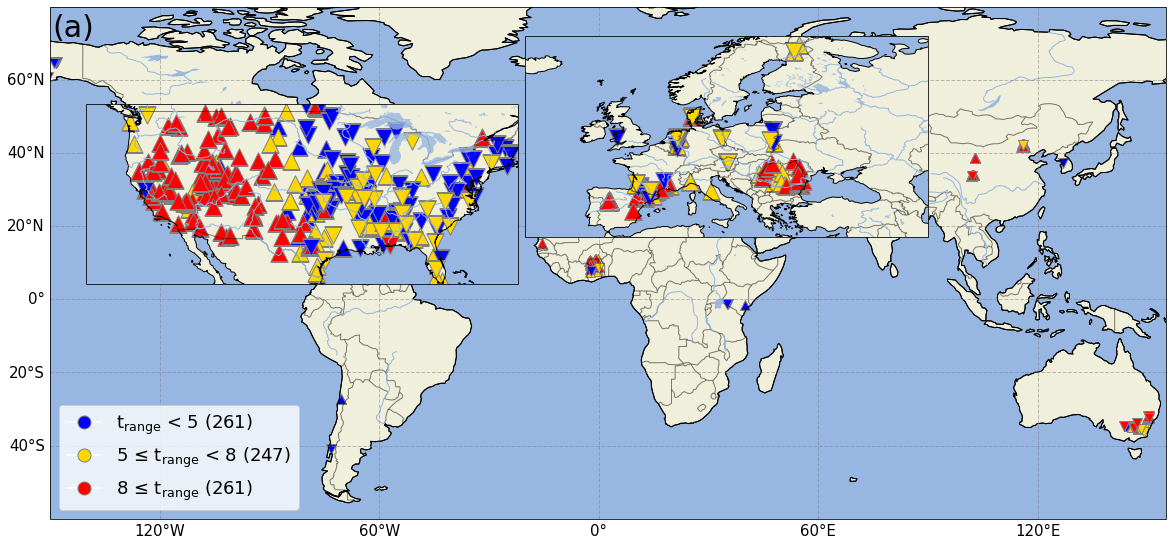

In [1361]:
fig ,ax= plt.subplots(figsize=(20, 20), subplot_kw={'projection': ccrs.PlateCarree()})
fig.set_facecolor('white')

R_p1 = np.array([value > 0 for value in trange1_ISMN])
R_n1 = np.array([value < 0 for value in trange1_ISMN])
R_p2 = np.array([value > 0 for value in trange2_ISMN])
R_n2 = np.array([value < 0 for value in trange2_ISMN])
R_p3 = np.array([value > 0 for value in trange3_ISMN])
R_n3 = np.array([value < 0 for value in trange3_ISMN])

plt.scatter(trange1_lon[R_p1], trange1_lat[R_p1],transform=cartopy.crs.PlateCarree(), s=100, color='blue',edgecolor='gray', marker='^',)
plt.scatter(trange2_lon[R_p2], trange2_lat[R_p2],transform=cartopy.crs.PlateCarree(),s=100,color='gold',edgecolor='gray', marker='^')
plt.scatter(trange3_lon[R_p3], trange3_lat[R_p3],transform=cartopy.crs.PlateCarree(),s=100,color='red',edgecolor='gray', marker='^')

plt.scatter(trange1_lon[R_n1], trange1_lat[R_n1],transform=cartopy.crs.PlateCarree(), s=100, color='blue',edgecolor='gray', marker='v')
plt.scatter(trange2_lon[R_n2], trange2_lat[R_n2],transform=cartopy.crs.PlateCarree(),s=100,color='gold',edgecolor='gray', marker='v')
plt.scatter(trange3_lon[R_n3], trange3_lat[R_n3],transform=cartopy.crs.PlateCarree(),s=100,color='red',edgecolor='gray', marker='v')

ax.coastlines()
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle='-', alpha=.5)
ax.add_feature(cfeature.LAKES, alpha=0.95)
ax.add_feature(cfeature.RIVERS)
ax.set_extent([-150, 160, -60, 80], crs=ccrs.PlateCarree())
ax.set_xlim(-150, 155)
ax.set_ylim(-60, 80)

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
gl.xlabel_style = {'size': 15}
gl.ylabel_style = {'size': 15}

# plt.title('Distribution by sm',fontsize=30,pad=10)
custom_legend = [
    Line2D([0], [0], marker='o', color='w', label=fr'$\mathrm{{t}}_{{\mathrm{{range}}}}$ < 5 ({len_trange1})',
           markerfacecolor='blue', markersize=13, markeredgecolor='gray'),
    Line2D([0], [0], marker='o', color='w', label=fr'5 ≤ $\mathrm{{t}}_{{\mathrm{{range}}}}$ < 8 ({len_trange2})',
           markerfacecolor='gold', markersize=13, markeredgecolor='gray'),
    Line2D([0], [0], marker='o', color='w', label=fr'8 ≤ $\mathrm{{t}}_{{\mathrm{{range}}}}$ ({len_trange3})',
           markerfacecolor='red', markersize=13, markeredgecolor='gray')]
plt.legend(handles=custom_legend, loc='lower left', fontsize=18)

'ㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡ'
'CONUS'
ax_inset = fig.add_axes([0.15, 0.40, 0.3, 0.3], projection=ccrs.PlateCarree())
ax_inset.set_extent([-130, -70, 25, 50], crs=ccrs.PlateCarree())  # CONUS 지역

ax_inset.coastlines()
ax_inset.add_feature(cfeature.LAND)
ax_inset.add_feature(cfeature.OCEAN)
ax_inset.add_feature(cfeature.BORDERS, linestyle='-', alpha=0.5)
ax_inset.add_feature(cfeature.LAKES, alpha=0.8)
ax_inset.add_feature(cfeature.RIVERS)

ax_inset.scatter(trange1_lon[R_p1], trange1_lat[R_p1],transform=cartopy.crs.PlateCarree(), s=300, color='blue',edgecolor='gray', marker='^',)
ax_inset.scatter(trange2_lon[R_p2], trange2_lat[R_p2],transform=cartopy.crs.PlateCarree(),s=300,color='gold',edgecolor='gray', marker='^')
ax_inset.scatter(trange3_lon[R_p3], trange3_lat[R_p3],transform=cartopy.crs.PlateCarree(),s=300,color='red',edgecolor='gray', marker='^')

ax_inset.scatter(trange1_lon[R_n1], trange1_lat[R_n1],transform=cartopy.crs.PlateCarree(), s=300, color='blue',edgecolor='gray', marker='v')
ax_inset.scatter(trange2_lon[R_n2], trange2_lat[R_n2],transform=cartopy.crs.PlateCarree(),s=300,color='gold',edgecolor='gray', marker='v')
ax_inset.scatter(trange3_lon[R_n3], trange3_lat[R_n3],transform=cartopy.crs.PlateCarree(),s=300,color='red',edgecolor='gray', marker='v')

'ㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡ'
'EU'
ax_inset2 = fig.add_axes([0.455, 0.5, 0.28, 0.18], projection=ccrs.PlateCarree())
ax_inset2.set_extent([-20, 50, 35, 70], crs=ccrs.PlateCarree())  # 유럽 지역 범위 설정

ax_inset2.coastlines()
ax_inset2.add_feature(cfeature.LAND)
ax_inset2.add_feature(cfeature.OCEAN)
ax_inset2.add_feature(cfeature.BORDERS, linestyle='-', alpha=0.5)
ax_inset2.add_feature(cfeature.LAKES, alpha=0.8)
ax_inset2.add_feature(cfeature.RIVERS)

ax_inset2.scatter(trange1_lon[R_p1], trange1_lat[R_p1],transform=cartopy.crs.PlateCarree(), s=300, color='blue',edgecolor='gray', marker='^',)
ax_inset2.scatter(trange2_lon[R_p2], trange2_lat[R_p2],transform=cartopy.crs.PlateCarree(),s=300,color='gold',edgecolor='gray', marker='^')
ax_inset2.scatter(trange3_lon[R_p3], trange3_lat[R_p3],transform=cartopy.crs.PlateCarree(),s=300,color='red',edgecolor='gray', marker='^')

ax_inset2.scatter(trange1_lon[R_n1], trange1_lat[R_n1],transform=cartopy.crs.PlateCarree(), s=300, color='blue',edgecolor='gray', marker='v')
ax_inset2.scatter(trange2_lon[R_n2], trange2_lat[R_n2],transform=cartopy.crs.PlateCarree(),s=300,color='gold',edgecolor='gray', marker='v')
ax_inset2.scatter(trange3_lon[R_n3], trange3_lat[R_n3],transform=cartopy.crs.PlateCarree(),s=300,color='red',edgecolor='gray', marker='v')

'ㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡ'
plt.text(-102., 70., '(a)', fontsize=30)
plt.savefig(fname+'figure 7 R by trange map', dpi=600, bbox_inches = 'tight', pad_inches = 0.02)

plt.show()

### (b)

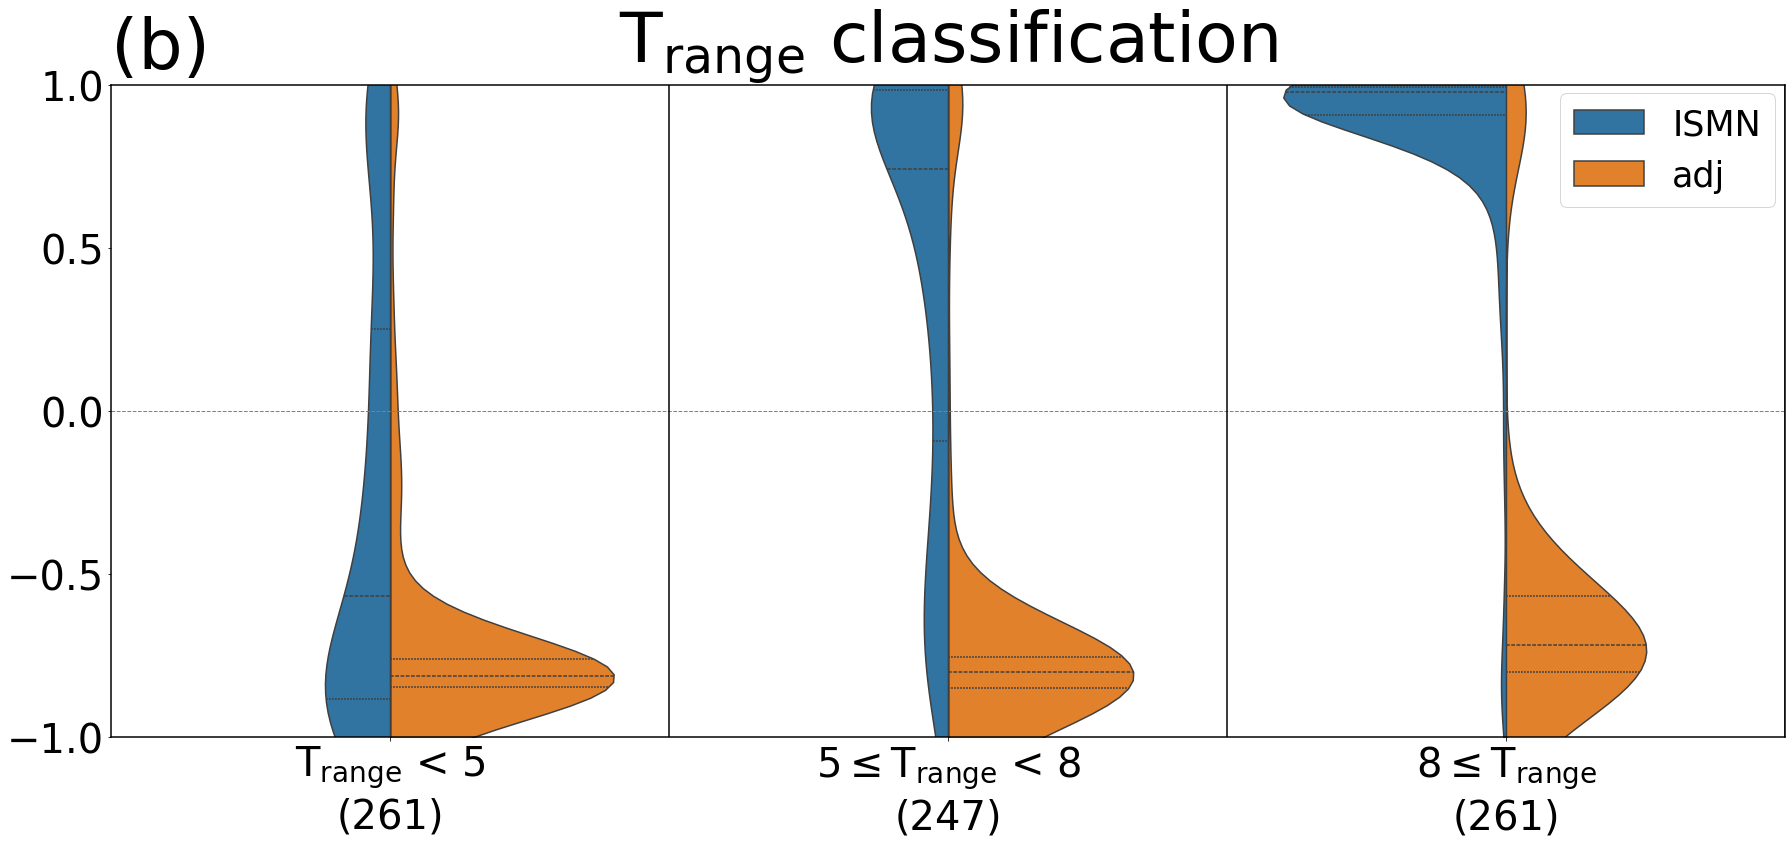

In [1362]:
# ISMN, adj, LSMs climate violin
fig, axs = plt.subplots(1, 1, figsize=(30, 12))
fig.set_facecolor('white')

sns.violinplot(x='range', y='R', hue='data', data=R_trange.dropna(), linewidth=1.5, split=True, inner='quart', order=['trange1','trange2','trange3'],ax=axs)
axs.set_title(r'T$_{\text{range}}$ classification',fontsize=70,pad=10)
axs.set_xlabel(' ',fontsize=25, labelpad=10)
axs.set_ylim(-1.,1.)
# axs.axhline(0.41, linestyle='--', c='r', linewidth=1)
# axs.axhline(-0.41, linestyle='--', c='r', linewidth=1)
axs.axhline(0.0, linestyle='--', c='gray', linewidth=1)
for x in [0.5, 1.5, 2.5]:
    axs.axvline(x=x, color='k', linestyle='-', linewidth=1.5)
# axs.set_xticks(Tropical_len,Dry_len,Temperate_len,Continental_len,Polar_len,Unknown_len])
labels = [fr'$\mathrm{{T}}_{{\mathrm{{range}}}}$ < 5' + f'\n({len_trange1})',
    fr'$5 \leq \mathrm{{T}}_{{\mathrm{{range}}}}$ < 8' + f'\n({len_trange2})',
    fr'$8 \leq \mathrm{{T}}_{{\mathrm{{range}}}}$' + f'\n({len_trange3})']
axs.set_xticklabels(labels)
axs.set_yticks([-1.0,-0.5,0,0.5,1])
axs.tick_params(axis='both', labelsize=40)
axs.text(-.5,1.05,'(b)',fontsize=70)
axs.yaxis.label.set_visible(False)
axs.xaxis.label.set_visible(False)
# axs.legend_.remove()
# axs.set_ylim(0,1)
axs.legend(loc='center left', bbox_to_anchor=(.855, .9), fontsize=35)

for spine in axs.spines.values():
    spine.set_edgecolor('black')
    spine.set_linewidth(1.5)
    
plt.savefig(fname+'figure 7 violin trange classify (ISMN,adj) legend inside2', dpi=600, bbox_inches = 'tight', pad_inches = 0.02)
plt.show()

### (c)

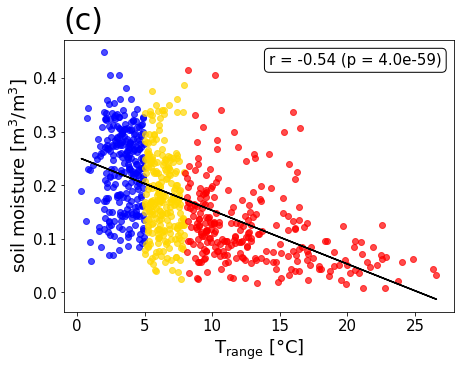

In [1368]:
kde = gaussian_kde(T_range)  # Variance 데이터로 KDE (PDF) 계산
y_pdf = np.linspace(min(T_range), max(T_range), 100)  # PDF를 위한 y축 범위
pdf_values = kde(y_pdf)  # PDF 값 계산

fig,ax1=plt.subplots(figsize=(7,5))
fig.set_facecolor('white')
ax1.scatter(T_range1, sm_mean1, label='Data', alpha=0.7, c='blue')
ax1.scatter(T_range2, sm_mean2, label='Data', alpha=0.7, c='gold')
ax1.scatter(T_range3, sm_mean3, label='Data', alpha=0.7, c='red')
plt.plot(T_range, sm_pred_range_l, color='k')
ax1.set_xlabel(r'$\text{T}_{\text{range}}$ [°C]', fontsize=18)
ax1.set_ylabel('soil moisture [m$^3$/m$^3$]',fontsize=18)
ax1.tick_params(axis='both', labelsize=15)
ax1.text(-1.,.49,'(c)',fontsize=30)
# ax1.set_title('SM Trange',fontsize=20)
# plt.ylim(0,10)
# plt.yscale('log')
# plt.legend()

ax1.text(14.2,.425, f'r = {r_value_range_l:.2f} (p = {p_value_range_l:.1e})',fontsize=15,bbox={'boxstyle': 'round,pad=0.3', 'facecolor': (1, 1, 1, 0.7), 'edgecolor': 'black'})
plt.subplots_adjust(wspace=0.3)
plt.savefig(fname+'figure 7 SM-Trange scatter 1line', dpi=600, bbox_inches = 'tight', pad_inches = 0.02)
plt.show()

# Figure 8

## data

In [1093]:
ISMN_sm=sorted(glob.glob('/home/jnhan/python/power spectrum/data/final filter/sm/ISMN_filter/*.csv'))
ISMN_ts=sorted(glob.glob('/home/jnhan/python/power spectrum/data/final filter/ts/ISMN_filter/*.csv'))

ERA_data=sorted(glob.glob('/home/jnhan/python/power spectrum/data/ERA5/p_remove_250608/*.csv'))
MERRA_data=sorted(glob.glob('/home/jnhan/python/power spectrum/data/MERRA2/p_remove_250608/*.csv'))

TLO_sm=glob.glob('/home/jnhan/python/power spectrum/data/reference sensor/sm/TLO/*')
TDT_sm=glob.glob('/home/jnhan/python/power spectrum/data/reference sensor/sm/TDT/*')

TLO_st=[i.split('/')[-1][:-7] for i in TLO_sm]
TDT_st=[i.split('/')[-1][:-7] for i in TDT_sm]

In [1094]:
ISMN_sm=[item for item in ISMN_sm if not any(tlo in item for tlo in TLO_st)]
ISMN_sm=[item for item in ISMN_sm if not any(tlo in item for tlo in TDT_st)]

ISMN_ts=[item for item in ISMN_ts if not any(tlo in item for tlo in TLO_st)]
ISMN_ts=[item for item in ISMN_ts if not any(tlo in item for tlo in TDT_st)]

ERA_data=[item for item in ERA_data if not any(tlo in item for tlo in TDT_st)]
ERA_data=[item for item in ERA_data if not any(tlo in item for tlo in TLO_st)]

MERRA_data=[item for item in MERRA_data if not any(tlo in item for tlo in TDT_st)]
MERRA_data=[item for item in MERRA_data if not any(tlo in item for tlo in TLO_st)]

In [1095]:
ISMN_order=[i.split('/')[-1][:-7] for i in ISMN_sm]

ERA_data = sorted(ERA_data, key=lambda path: ISMN_order.index(next(a for a in ISMN_order if a in path)))
MERRA_data = sorted(MERRA_data, key=lambda path: ISMN_order.index(next(a for a in ISMN_order if a in path)))

In [1119]:
ERA_v,MERRA_v=(0.5, 0.5)
lat=[]
lon=[]
ISMN_cor_ano=[]
ISMN_cor_adj=[]
ERA_cor_ano=[]
MERA_cor_ano=[]
ISMN_climate=[]
merge_list=[]
hourly_list=[]
bn_lat=[]
bn_lon=[]
bn_ISMN_cor_ano=[]
bn_ISMN_cor_adj=[]
bn_ERA_cor_ano=[]
bn_MERA_cor_ano=[]
bn_ISMN_climate=[]
bn_merge_list=[]
bn_hourly_list=[]
before_noon=[]
error=[]
low_len=[]
idx=[]
bn_idx=[]
for i in range(len(ISMN_sm)):
    print(i,end='\r')
    try:
        ISMN=pd.read_csv(ISMN_sm[i],usecols={'date_time','soil_moisture','flag','anomaly','rm'},index_col='date_time',parse_dates=['date_time'])
        ERA=pd.read_csv(ERA_data[i],usecols={'date_time','sm','sm ano','ts','ts ano'},index_col='date_time',parse_dates=['date_time'])
        MERRA=pd.read_csv(MERRA_data[i],usecols={'date_time','sm','sm ano','ts','ts ano'},index_col='date_time',parse_dates=['date_time'])
        ts_ISMN=pd.read_csv(ISMN_ts[i],usecols={'date_time','soil_temperature','flag','anomaly'},index_col='date_time',parse_dates=['date_time'])
        ISMN2=pd.read_csv(ISMN_sm[i])
        
        ISMN=ISMN[ISMN['flag']=='G']
        ts_ISMN=ts_ISMN[ts_ISMN['flag']=='G']
        ISMN=ISMN[['soil_moisture','anomaly','rm']]
        ts_ISMN=ts_ISMN[['soil_temperature','anomaly']]
        
        ISMN.rename(columns={'soil_moisture':'ISMN sm','anomaly':'ISMN sm ano','rm':'ISMN rm'},inplace=True)
        ERA.rename(columns={'sm':'ERA sm','sm ano':'ERA sm ano','ts':'ERA ts','ts ano':'ERA ts ano'},inplace=True)
        MERRA.rename(columns={'sm':'MERRA sm','sm ano':'MERRA sm ano','ts':'MERRA ts','ts ano':'MERRA ts ano'},inplace=True)
        ts_ISMN.rename(columns={'soil_temperature':'ISMN ts','anomaly':'ISMN ts ano'},inplace=True)
        
        merged = ISMN.merge(ERA, left_index=True, right_index=True, how='inner')
        merged = merged.merge(MERRA, left_index=True, right_index=True, how='inner')
        merged = merged.merge(ts_ISMN, left_index=True, right_index=True, how='inner')
        merged = merged.dropna()

        if len(merged) > 2200:
            'ㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡ'
            'anomaly'
            fft_ISMN_ano=np.fft.fft(merged['ISMN sm ano'])
            ps_ISMN_ano=np.abs(fft_ISMN_ano)
            freq_ISMN_ano=np.fft.fftfreq(len(merged),d=1.0/len(fft_ISMN_ano))
            
            fft_ERA_ano=np.fft.fft(merged['ERA sm ano'])
            ps_ERA_ano=np.abs(fft_ERA_ano)
            freq_ERA_ano=np.fft.fftfreq(len(merged),d=1.0/len(fft_ERA_ano))
            
            fft_MERRA_ano=np.fft.fft(merged['MERRA sm ano'])
            ps_MERRA_ano=np.abs(fft_MERRA_ano)
            freq_MERRA_ano=np.fft.fftfreq(len(merged),d=1.0/len(fft_MERRA_ano))
            
            freq_24=int(len(freq_ISMN_ano)/24)
            freq_36=int(len(freq_ISMN_ano)/36)
            freq_12=int(len(freq_ISMN_ano)/12)
            
            df_ano=pd.DataFrame()
            df_ano['fft_ISMN_r']=fft_ISMN_ano.real
            df_ano['fft_ERA_r']=fft_ERA_ano.real
            df_ano['fft_MERRA_r']=fft_MERRA_ano.real
            df_ano['fft_m_r']=((ERA_v*df_ano['fft_ERA_r'])+(MERRA_v*df_ano['fft_MERRA_r']))
            df_ano['fft_ISMN_i']=fft_ISMN_ano.imag
            df_ano['fft_ERA_i']=fft_ERA_ano.imag
            df_ano['fft_MERRA_i']=fft_MERRA_ano.imag
            df_ano['fft_m_i']=((ERA_v*df_ano['fft_ERA_i'])+(MERRA_v*df_ano['fft_MERRA_i']))
            df_ano['ps_ISMN']=ps_ISMN_ano
            df_ano['ps_ERA']=ps_ERA_ano
            df_ano['ps_MERRA']=ps_MERRA_ano
            df_ano['ps_m']=((ERA_v*df_ano['ps_ERA'])+(MERRA_v*df_ano['ps_MERRA']))
            
            mv_ano=df_ano.rolling(window=24,center=True).mean()
            
            sf_ano_E=mv_ano['ps_ISMN']/mv_ano['ps_ERA']
            sf_ano_M=mv_ano['ps_ISMN']/mv_ano['ps_MERRA']
            sf_ano_all=mv_ano['ps_ISMN']/mv_ano['ps_m']
            
            fft_ano_r_E=sf_ano_E*df_ano['fft_ERA_r']
            fft_ano_i_E=sf_ano_E*df_ano['fft_ERA_i']
            fft_ano_r_M=sf_ano_M*df_ano['fft_MERRA_r']
            fft_ano_i_M=sf_ano_M*df_ano['fft_MERRA_i']
            fft_ano_r_all=sf_ano_all*df_ano['fft_m_r']
            fft_ano_i_all=sf_ano_all*df_ano['fft_m_i']
            
            fft_ano_resc_E=fft_ano_r_E+fft_ano_i_E*1j
            fft_ano_resc_M=fft_ano_r_M+fft_ano_i_M*1j
            fft_ano_resc_all=fft_ano_r_all+fft_ano_i_all*1j
            
            fft_ISMN_adj_ano_E=fft_ISMN_ano.copy()
            fft_ISMN_adj_ano_M=fft_ISMN_ano.copy()
            fft_ISMN_adj_ano_all=fft_ISMN_ano.copy()
            
            fft_ISMN_adj_ano_E[freq_36:freq_12]=fft_ano_resc_E[freq_36:freq_12]
            fft_ISMN_adj_ano_E[-freq_12:-freq_36]=fft_ano_resc_E[-freq_12:-freq_36]
            fft_ISMN_adj_ano_M[freq_36:freq_12]=fft_ano_resc_M[freq_36:freq_12]
            fft_ISMN_adj_ano_M[-freq_12:-freq_36]=fft_ano_resc_M[-freq_12:-freq_36]
            fft_ISMN_adj_ano_all[freq_36:freq_12]=fft_ano_resc_all[freq_36:freq_12]
            fft_ISMN_adj_ano_all[-freq_12:-freq_36]=fft_ano_resc_all[-freq_12:-freq_36]
            
            ps_ano_adj_E=np.abs(fft_ISMN_adj_ano_E)
            ps_ano_adj_M=np.abs(fft_ISMN_adj_ano_M)
            ps_ano_adj_all=np.abs(fft_ISMN_adj_ano_all)
            
            ifft_ISMN_ano_E=np.fft.ifft(fft_ISMN_adj_ano_E)
            ifft_ISMN_ano_real_E=ifft_ISMN_ano_E.real
            ifft_ISMN_ano_M=np.fft.ifft(fft_ISMN_adj_ano_M)
            ifft_ISMN_ano_real_M=ifft_ISMN_ano_M.real
            ifft_ISMN_ano_all=np.fft.ifft(fft_ISMN_adj_ano_all)
            ifft_ISMN_ano_real_all=ifft_ISMN_ano_all.real
            
            merged['ano_adj_E']=ifft_ISMN_ano_real_E
            merged['ano_adj_M']=ifft_ISMN_ano_real_M
            merged['ano_adj_all']=ifft_ISMN_ano_real_all
            
            merged_copy=merged.copy()
            merged_copy['date']=merged_copy.index.date
            merged_copy['hour']=merged_copy.index.hour
            merged_copy=merged_copy.groupby('date', group_keys=False).apply(adjust_night)
            filter_date=merged_copy.loc[merged_copy['night_adj'] < 0, 'date'].unique()
            merged_copy['night_adj2']=merged_copy['night_adj']
        
            for j in filter_date:
                filter_start=merged_copy[merged_copy['date'] == j][['night_adj']].copy()
                night_mean=np.mean(filter_start['night_adj'])
                filter_start['step1']=filter_start['night_adj']-night_mean
                filter_min=np.min(filter_start['step1'])
                if night_mean > 0 : 
                    if abs(filter_min) < 1:
                        filter_start['step2']=filter_start['step1']*abs(filter_min)
                        filter_start['step3']=filter_start['step2']+night_mean
                        merged_copy.loc[filter_start.index, 'night_adj2'] = filter_start['step3']
                    elif abs(filter_min) > 1:
                        filter_start['step2']=filter_start['step1']/abs(filter_min)
                        filter_start['step3']=filter_start['step2']+night_mean
                        merged_copy.loc[filter_start.index, 'night_adj2'] = filter_start['step3']
                elif night_mean < 0 :
                    if abs(filter_min) < 1:
                        filter_start['step2']=filter_start['step1']*abs(filter_min)
                        filter_start['step3']=filter_start['step2']+abs(np.min(filter_start['step2']))
                        merged_copy.loc[filter_start.index, 'night_adj2'] = filter_start['step3']
                    elif abs(filter_min) > 1:
                        filter_start['step2']=filter_start['step1']/abs(filter_min)
                        filter_start['step3']=filter_start['step2']+abs(np.min(filter_start['step2']))
                        merged_copy.loc[filter_start.index, 'night_adj2'] = filter_start['step3']

            merged_copy=merged_copy.drop(columns=['date','hour'])
            hourly=merged_copy.groupby(merged_copy.index.hour).mean()            
            
            if (np.argmax(hourly['ISMN sm ano']) >= 12):
                lat.append(ISMN2.latitude[0])
                lon.append(ISMN2.longitude[0])
                ISMN_cor_ano.append(np.corrcoef(hourly['ISMN sm ano'],hourly['ISMN ts ano'])[0,1])       # ISMN ano R(sm,ts)
                ISMN_cor_adj.append(np.corrcoef(hourly['night_adj'],hourly['ISMN ts ano'])[0,1])             # ISMN R(sm_adj,ts)
                ERA_cor_ano.append(np.corrcoef(hourly['ERA sm ano'],hourly['ERA ts ano'])[0,1])
                MERA_cor_ano.append(np.corrcoef(hourly['MERRA sm ano'],hourly['MERRA ts ano'])[0,1])
                ISMN_climate.append(ISMN2.climate[0])
                merge_list.append(merged_copy)
                hourly_list.append(hourly)
                idx.append(i)
            else : 
                bn_lat.append(ISMN2.latitude[0])
                bn_lon.append(ISMN2.longitude[0])
                bn_ISMN_cor_ano.append(np.corrcoef(hourly['ISMN sm ano'],hourly['ISMN ts ano'])[0,1])       # ISMN ano R(sm,ts)
                bn_ISMN_cor_adj.append(np.corrcoef(hourly['night_adj'],hourly['ISMN ts ano'])[0,1])             # ISMN R(sm_adj,ts)
                bn_ERA_cor_ano.append(np.corrcoef(hourly['ERA sm ano'],hourly['ERA ts ano'])[0,1])
                bn_MERA_cor_ano.append(np.corrcoef(hourly['MERRA sm ano'],hourly['MERRA ts ano'])[0,1])                
                bn_ISMN_climate.append(ISMN2.climate[0])
                bn_merge_list.append(merged_copy)
                bn_hourly_list.append(hourly)
                bn_idx.append(i)
            del night,hourly
        else:
            low_len.append(i)
    except Exception as e:
        error.append((i,e))

In [1120]:
lat_all=lat+bn_lat
lon_all=lon+bn_lon
R_ISMN_all=ISMN_cor_ano+bn_ISMN_cor_ano
R_adj_all=ISMN_cor_adj+bn_ISMN_cor_adj
R_ERA_all=ERA_cor_ano+bn_ERA_cor_ano
R_MERRA_all=MERRA_cor_ano+bn_MERRA_cor_ano
merged_all=merge_list+bn_merge_list
hourly_all=hourly_list+bn_hourly_list
climate_all=ISMN_climate+bn_ISMN_climate

In [1121]:
climate_1st = [
    'Tropical' if key.startswith('A') else
    'Dry' if key.startswith('B') else
    'Temperate' if key.startswith('C') else
    'Continental' if key.startswith('D')  else
    'Polar' if key.startswith('E') else
    'Unknown'
    for key in climate_all
]

climate_2nd = [
    'Tropical Dry' if key.startswith(('As','Aw')) else
    'Tropical Wet' if key.startswith(('Am','Af')) else
    'Dry' if key.startswith('B') else
    'Temperate Dry' if key.startswith(('Cs','Cw')) else
    'Temperate Wet' if key.startswith(('Cm','Cf')) else
    'Continental Dry' if key.startswith(('Ds','Dw'))  else
    'Continental Wet' if key.startswith(('Dm','Df'))  else
    'Polar' if key.startswith('E') else
    'Unknown'
    for key in climate_all
]

In [1127]:
R_df_ISMN=pd.DataFrame()
R_df_ISMN['climate']=climate_all
R_df_ISMN['climate 1st']=climate_1st
R_df_ISMN['climate 2nd']=climate_2nd
R_df_ISMN['R']=R_ISMN_all
R_df_ISMN['lat']=lat_all
R_df_ISMN['lon']=lon_all
R_df_ISMN['data']='ISMN'

R_df_adj=pd.DataFrame()
R_df_adj['climate']=climate_all
R_df_adj['climate 1st']=climate_1st
R_df_adj['climate 2nd']=climate_2nd
R_df_adj['R']=R_adj_all
R_df_adj['lat']=lat_all
R_df_adj['lon']=lon_all
R_df_adj['data']=r'ISMN$_{\text{adj}}$'

R_df_ERA=pd.DataFrame()
R_df_ERA['climate']=climate_all
R_df_ERA['climate 1st']=climate_1st
R_df_ERA['climate 2nd']=climate_2nd
R_df_ERA['R']=R_ERA_all
R_df_ERA['lat']=lat_all
R_df_ERA['lon']=lon_all
R_df_ERA['data']='ERA5-Land'

R_df_MERRA=pd.DataFrame()
R_df_MERRA['climate']=climate_all
R_df_MERRA['climate 1st']=climate_1st
R_df_MERRA['climate 2nd']=climate_2nd
R_df_MERRA['R']=R_MERRA_all
R_df_MERRA['lat']=lat_all
R_df_MERRA['lon']=lon_all
R_df_MERRA['data']='MERRA-2'

R_df_obs=pd.concat([R_df_ISMN,R_df_adj])
R_df_all=pd.concat([R_df_ISMN,R_df_adj,R_df_ERA,R_df_MERRA])
R_df_all=R_df_all[R_df_all['climate 1st']!='Unknown']

In [1128]:
R_df_all_Con=R_df_all[R_df_all['climate 1st']=='Continental']
R_df_all_Tem=R_df_all[R_df_all['climate 1st']=='Temperate']

In [1130]:
Tropical_len=len(R_df_ISMN[R_df_ISMN['climate 1st']=='Tropical'])
Dry_len=len(R_df_ISMN[R_df_ISMN['climate 1st']=='Dry'])
Temperate_len=len(R_df_ISMN[R_df_ISMN['climate 1st']=='Temperate'])
Continental_len=len(R_df_ISMN[R_df_ISMN['climate 1st']=='Continental'])
Polar_len=len(R_df_ISMN[R_df_ISMN['climate 1st']=='Polar'])
Unknown_len=len(R_df_ISMN[R_df_ISMN['climate 1st']=='Unknown'])

In [1133]:
Tem_dry_len2=len(R_df_ISMN[R_df_ISMN['climate 2nd']=='Temperate Dry'])
Tem_wet_len2=len(R_df_ISMN[R_df_ISMN['climate 2nd']=='Temperate Wet'])
Con_dry_len2=len(R_df_ISMN[R_df_ISMN['climate 2nd']=='Continental Dry'])
Con_wet_len2=len(R_df_ISMN[R_df_ISMN['climate 2nd']=='Continental Wet'])

## plot

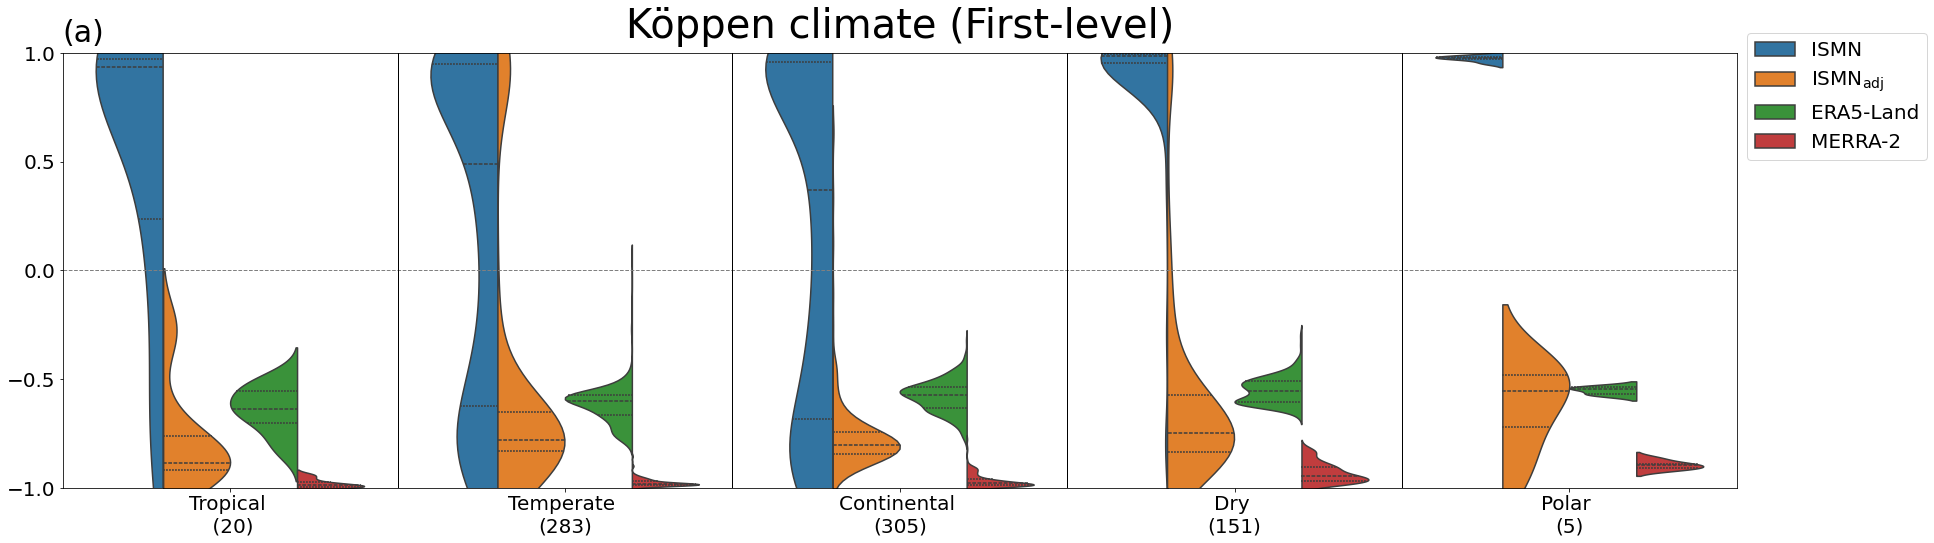

In [1369]:
fig, axs = plt.subplots(1, 1, figsize=(30, 8))
fig.set_facecolor('white')

sns.violinplot(x='climate 1st', y='R', hue='data', data=R_df_all, linewidth=1.5, split=True, inner='quart', order=['Tropical','Temperate', 'Continental','Dry','Polar'],ax=axs, scale='width')
axs.set_title(r'Köppen climate (First-level)',fontsize=40,pad=15)
axs.xaxis.label.set_visible(False)
axs.set_ylim(-1.,1.)
axs.axhline(0.0, linestyle='--', c='gray', linewidth=1)
for x in [0.5, 1.5, 2.5, 3.5]:
    axs.axvline(x=x, color='k', linestyle='-', linewidth=1)
axs.set_xticklabels([f'Tropical \n ({Tropical_len})',f'Temperate \n({Temperate_len})',f'Continental \n({Continental_len})', f'Dry \n({Dry_len})',f'Polar \n({Polar_len})'], fontsize= 20)
axs.set_yticks([-1.0,-0.5,0,0.5,1])
axs.tick_params(axis='both', labelsize=20)
axs.text(-.5,1.05,'(a)',fontsize=30)
axs.yaxis.label.set_visible(False)
# axs.set_ylim(0,1)
handles, labels = axs.get_legend_handles_labels()
axs.legend(handles[:4], labels[:4], loc='center left', bbox_to_anchor=(1., .9), fontsize=20)

plt.savefig(fname+'figure 8 violin climate2-1 all', dpi=600, bbox_inches = 'tight', pad_inches = 0.02)
plt.show()

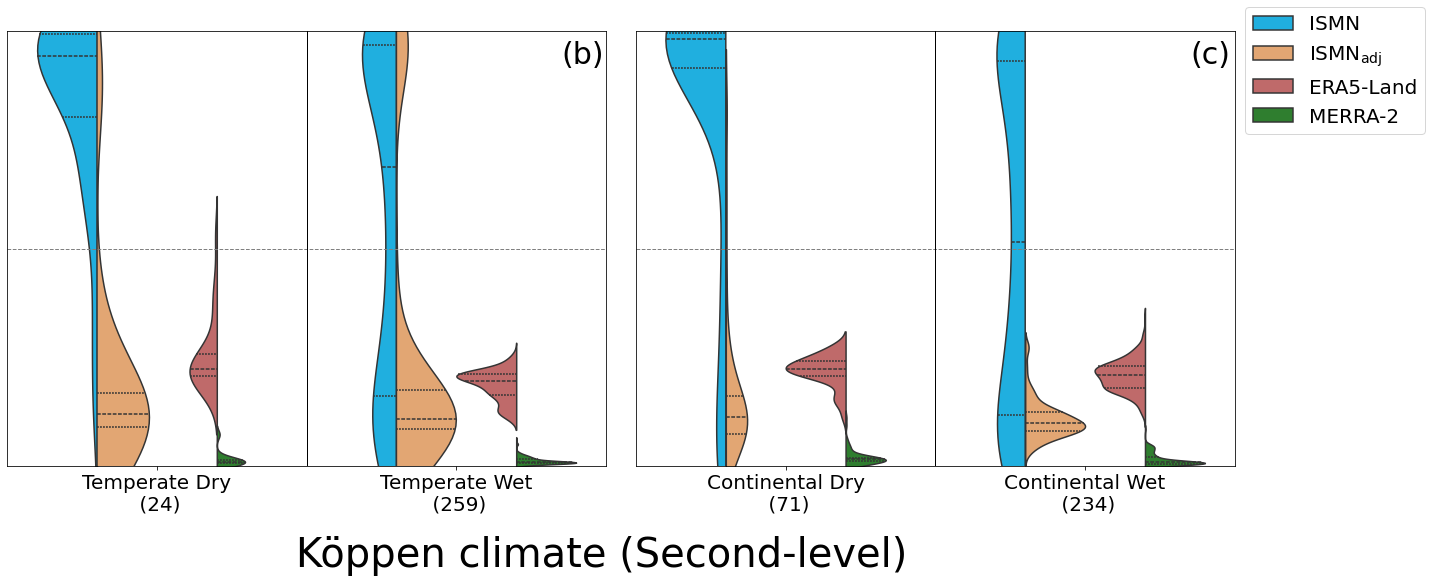

In [1370]:
fig, axs = plt.subplots(1, 2, figsize=(22, 8),gridspec_kw={'wspace': 0.05})
fig.set_facecolor('white')

'(b) ㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡ'
sns.violinplot(x='climate 2nd', y='R', hue='data', data=R_df_all_Tem, palette={'ISMN': 'deepskyblue', r'ISMN$_{\text{adj}}$': 'sandybrown', 'ERA5-Land': 'indianred', 'MERRA-2': 'forestgreen'},linewidth=1.5, split=True, inner='quart', order=['Temperate Dry','Temperate Wet'],ax=axs[0])
axs[0].set_xlabel('')
axs[0].set_ylim(-1.,1.)
axs[0].axhline(0.0, linestyle='--', c='gray', linewidth=1)
for x in [0.5, 1.5]:
    axs[0].axvline(x=x, color='k', linestyle='-', linewidth=1)
axs[0].set_xticklabels([f'Temperate Dry\n ({Tem_dry_len2})',f'Temperate Wet\n ({Tem_wet_len2})'], fontsize= 20)
axs[0].set_yticks([-1.0,-0.5,0,0.5,1])
axs[0].tick_params(axis='both', labelsize=20)
axs[0].text(1.35,.85,'(b)',fontsize=30)
axs[0].yaxis.label.set_visible(False)
axs[0].yaxis.set_visible(False)
axs[0].legend().set_visible(False)

'(c) ㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡ'
sns.violinplot(x='climate 2nd', y='R', hue='data', data=R_df_all_Con, palette={'ISMN': 'deepskyblue', r'ISMN$_{\text{adj}}$': 'sandybrown', 'ERA5-Land': 'indianred', 'MERRA-2': 'forestgreen'},linewidth=1.5, split=True, inner='quart', order=['Continental Dry','Continental Wet'],ax=axs[1])
axs[1].set_xlabel('')
axs[1].set_ylim(-1.,1.)
axs[1].axhline(0.0, linestyle='--', c='gray', linewidth=1)
for x in [0.5, 1.5]:
    axs[1].axvline(x=x, color='k', linestyle='-', linewidth=1)
axs[1].set_xticklabels([f'Continental Dry\n ({Con_dry_len2})',f'Continental Wet\n ({Con_wet_len2})'], fontsize= 20)
axs[1].set_yticks([-1.0,-0.5,0,0.5,1])
axs[1].tick_params(axis='both', labelsize=20)
axs[1].text(1.35,.85,'(c)',fontsize=30)
axs[1].yaxis.label.set_visible(False)
axs[1].yaxis.set_visible(False)
axs[1].legend(loc='center left', bbox_to_anchor=(1., 0.91), fontsize=20)

fig.text(0.5, -0.05, 'Köppen climate (Second-level)', ha='center', fontsize=40)
plt.savefig(fname+'figure 8 climate level2 classify2 all', dpi=600, bbox_inches = 'tight', pad_inches = 0.02)
plt.show()


# Figure 9

## data

In [1234]:
flux_hourly=sorted(glob.glob('/home/jnhan/python/power spectrum/data/FLUXNET/merged_250612/hourly/*'))
flux_daily=sorted(glob.glob('/home/jnhan/python/power spectrum/data/FLUXNET/merged_250612/daily/*'))
flux_monthly=sorted(glob.glob('/home/jnhan/python/power spectrum/data/FLUXNET/merged_250612/monthly/*'))

In [1235]:
len(flux_hourly),len(flux_daily),len(flux_monthly)

(178, 178, 178)

In [1236]:
R_hourly=[]
R_adj_hourly=[]
p_hourly=[]
p_adj_hourly=[]
std_hourly=[]
for i in range(len(flux_hourly)):
    print(i,end='\r')
    hourly=pd.read_csv(flux_hourly[i],index_col='time',parse_dates=['time'])

    if hourly.latitude[0] >= 0:
        months = [5, 6, 7, 8, 9]  
    else:
        months = [11, 12, 1, 2, 3]
    hourly = hourly[hourly.index.month.isin(months)]
    hourly=hourly.groupby(hourly.index.hour).mean()

    R_hourly.append(stats.pearsonr(hourly['sm ano'],hourly['LH'])[0])
    R_adj_hourly.append(stats.pearsonr(hourly['adj'],hourly['LH'])[0])
    p_hourly.append(stats.pearsonr(hourly['sm ano'],hourly['LH'])[1])
    p_adj_hourly.append(stats.pearsonr(hourly['adj'],hourly['LH'])[1])
    std_hourly.append(np.std(hourly['LH']))
    del hourly

In [1238]:
R_daily=[]
p_daily=[]
std_daily=[]
for i in range(len(flux_daily)):
    print(i,end='\r')
    daily=pd.read_csv(flux_daily[i],index_col='time',parse_dates=['time'])

    if daily.latitude[0] >= 0:
        months = [5, 6, 7, 8, 9]  
    else:
        months = [11, 12, 1, 2, 3]
    daily = daily[daily.index.month.isin(months)]

    R_daily.append(stats.pearsonr(daily['sm ano'],daily['LH'])[0])
    p_daily.append(stats.pearsonr(daily['sm ano'],daily['LH'])[1])
    std_daily.append(np.std(daily['LH']))
    del daily

In [1239]:
R_monthly=[]
p_monthly=[]
std_monthly=[]
for i in range(len(flux_monthly)):
    print(i,end='\r')
    monthly=pd.read_csv(flux_monthly[i],index_col='time',parse_dates=['time'])

    if monthly.latitude[0] >= 0:
        months = [5, 6, 7, 8, 9]  
    else:
        months = [11, 12, 1, 2, 3]
    monthly = monthly[monthly.index.month.isin(months)]

    R_monthly.append(stats.pearsonr(monthly['sm ano'],monthly['LH'])[0])
    p_monthly.append(stats.pearsonr(monthly['sm ano'],monthly['LH'])[1])
    std_monthly.append(np.std(monthly['LH']))
    del monthly

In [1245]:
TCI_hourly=[i*j for i,j in zip(R_hourly,std_hourly)]
TCI_adj_hourly=[i*j for i,j in zip(R_adj_hourly,std_hourly)]
TCI_daily=[i*j for i,j in zip(R_daily,std_daily)]
TCI_monthly=[i*j for i,j in zip(R_monthly,std_monthly)]

In [1243]:
R_m=pd.DataFrame()
R_m['R']=R_monthly
R_m['time']='Monthly'
R_m['season']='warm'

R_d=pd.DataFrame()
R_d['R']=R_daily
R_d['time']='Daily'
R_d['season']='warm'

R_h=pd.DataFrame()
R_h['R']=R_hourly
R_h['time']='Hourly'
R_h['season']='warm'

R_a=pd.DataFrame()
R_a['R']=R_adj_hourly
R_a['time']='Adjust'
R_a['season']='warm'

R_violin=pd.concat([R_m,R_d,R_h,R_a])

In [1246]:
TCI_m=pd.DataFrame()
TCI_m['R']=TCI_monthly
TCI_m['time']='Monthly'
TCI_m['season']='warm'

TCI_d=pd.DataFrame()
TCI_d['R']=TCI_daily
TCI_d['time']='Daily'
TCI_d['season']='warm'

TCI_h=pd.DataFrame()
TCI_h['R']=TCI_hourly
TCI_h['time']='Hourly'
TCI_h['season']='warm'

TCI_a=pd.DataFrame()
TCI_a['R']=TCI_adj_hourly
TCI_a['time']='Adjust'
TCI_a['season']='warm'

TCI_violin=pd.concat([TCI_m,TCI_d,TCI_h,TCI_a])

In [1257]:
std_m=pd.DataFrame()
std_m['std']=std_monthly
std_m['time']='Monthly'
std_m['season']='warm'

std_d=pd.DataFrame()
std_d['std']=std_daily
std_d['time']='Daily'
std_d['season']='warm'

std_h=pd.DataFrame()
std_h['std']=std_hourly
std_h['time']='Hourly'
std_h['season']='warm'

std_violin=pd.concat([std_m,std_d,std_h])

In [1250]:
std_m_med=np.median(std_monthly)
std_d_med=np.median(std_daily)
std_h_med=np.median(std_hourly)

TCI_m_med=np.median(TCI_monthly)
TCI_d_med=np.median(TCI_daily)
TCI_h_med=np.median(TCI_hourly)
TCI_a_med=np.median(TCI_adj_hourly)

R_m_med=np.median(R_monthly)
R_d_med=np.median(R_daily)
R_h_med=np.median(R_hourly)
R_a_med=np.median(R_adj_hourly)

p_m_med=np.median(p_monthly)
p_d_med=np.median(p_daily)
p_h_med=np.median(p_hourly)
p_a_med=np.median(p_adj_hourly)

## plot

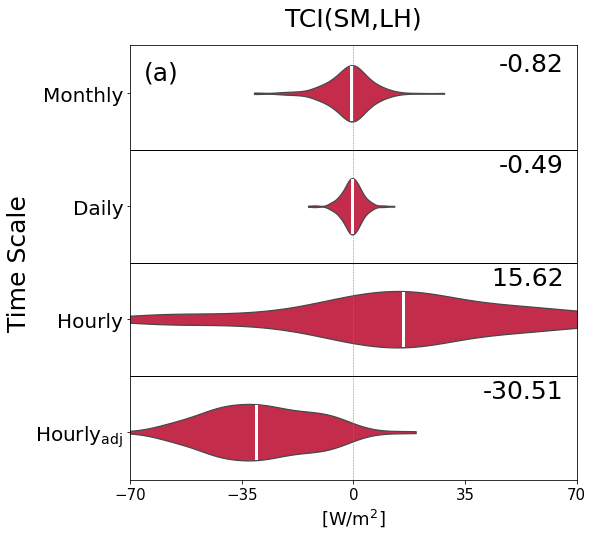

In [1378]:
category_sizes = R_violin.groupby('time').size()

# 최대 크기에 비례한 폭 설정
max_size = category_sizes.max()
categoryidths = category_sizes / (2*max_size) 

fig, ax = plt.subplots(figsize=(8, 8))
fig.set_facecolor('white')

for i, (category, data) in enumerate(TCI_violin.groupby('time')):
    sns.violinplot(
        data=data,
        x='R',
        y=np.full(len(data), category),
        color='crimson',
        inner=None,
        width=categoryidths[category], 
        ax=ax,
        order=['Monthly','Daily','Hourly','Adjust'],
        cut=0,
        legend=False
    )

plt.xticks([-70,-35,0,35,70],fontsize=15)
plt.xlim(-70,70)
categories = ['Monthly', 'Daily', 'Hourly', r'$\mathrm{Hourly_{adj}}$'] 
plt.yticks(range(len(categories)), categories, fontsize=20)
plt.ylabel('Time Scale', fontsize=25)
plt.xlabel(r'$\mathrm{[W/m^2]}$', fontsize=18)
plt.axvline(0,linestyle='--',c='gray',linewidth=.5)
plt.axhline(0.5,c='k',linewidth=1.)
plt.axhline(1.5,c='k',linewidth=1.)
plt.axhline(2.5,c='k',linewidth=1.)
plt.title('TCI(SM,LH)',fontsize=25,pad=20)

plt.text(66.,0-.20,f'{TCI_m_med: .2f}',fontsize=25, c='k', ha='right')
plt.text(66.,1-.30,f'{TCI_d_med: .2f}',fontsize=25, c='k', ha='right')
plt.text(66.,2-.30,f'{TCI_h_med: .2f}',fontsize=25, c='k', ha='right')
plt.text(66.,3-.30,f'{TCI_a_med: .2f}',fontsize=25, c='k', ha='right')

ax = plt.gca()  
ax.text(0.03, 0.92, '(a)', fontsize=25, transform=ax.transAxes)

ax.plot([TCI_m_med, TCI_m_med], [-0.23, 0.23], color='white', linewidth=3)
ax.plot([TCI_d_med, TCI_d_med], [1-0.23, 1+0.23], color='white', linewidth=3)
ax.plot([TCI_h_med, TCI_h_med], [2-0.23, 2+0.23], color='white', linewidth=3)
ax.plot([TCI_a_med, TCI_a_med], [3-0.23, 3+0.23], color='white', linewidth=3)

plt.savefig(fname+'figure 9 TCI violin warm mid white', dpi=600, bbox_inches = 'tight', pad_inches = 0.02)
plt.show()

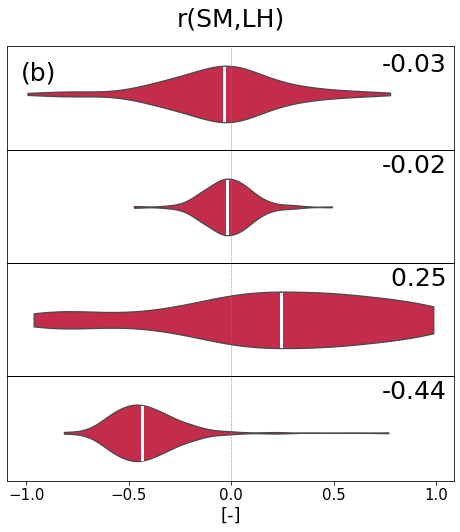

In [1379]:
category_sizes = R_violin.groupby('time').size()

max_size = category_sizes.max()
category_widths = category_sizes / (2*max_size)

fig, ax = plt.subplots(figsize=(8, 8))
fig.set_facecolor('white')

for i, (category, data) in enumerate(R_violin.groupby('time')):
    sns.violinplot(
        data=data,
        x='R',
        y=np.full(len(data), category),
        color='crimson',
        inner=None,
        width=category_widths[category],
        ax=ax,
        order=['Monthly','Daily','Hourly','Adjust'],
        cut=0,
        legend=False
    )

plt.xticks([-1.,-.5,0.,.5,1.],fontsize=15)
ax.yaxis.set_visible(False)
plt.xlabel('[-]', fontsize=18)
plt.axvline(0,linestyle='--',c='gray',linewidth=.5)
plt.axhline(0.5,c='k',linewidth=1.)
plt.axhline(1.5,c='k',linewidth=1.)
plt.axhline(2.5,c='k',linewidth=1.)
plt.title('r(SM,LH)',fontsize=25,pad=20)

plt.text(1.05,0-.20,f'{R_m_med: .2f}',fontsize=25, c='k', ha='right')
plt.text(1.05,1-.30,f'{R_d_med: .2f}',fontsize=25, c='k', ha='right')
plt.text(1.05,2-.30,f'{R_h_med: .2f}',fontsize=25, c='k', ha='right')
plt.text(1.05,3-.30,f'{R_a_med: .2f}',fontsize=25, c='k', ha='right')

ax = plt.gca()  
ax.text(0.03, 0.92, '(b)', fontsize=25, transform=ax.transAxes)

ax.plot([R_m_med, R_m_med], [-0.23, 0.23], color='white', linewidth=3)
ax.plot([R_d_med, R_d_med], [1-0.23, 1+0.23], color='white', linewidth=3)
ax.plot([R_h_med, R_h_med], [2-0.23, 2+0.23], color='white', linewidth=3)
ax.plot([R_a_med, R_a_med], [3-0.23, 3+0.23], color='white', linewidth=3)
plt.savefig(fname+'figure 9 R(SSM,LH) violin warm mid white', dpi=600, bbox_inches = 'tight', pad_inches = 0.02)
plt.show()

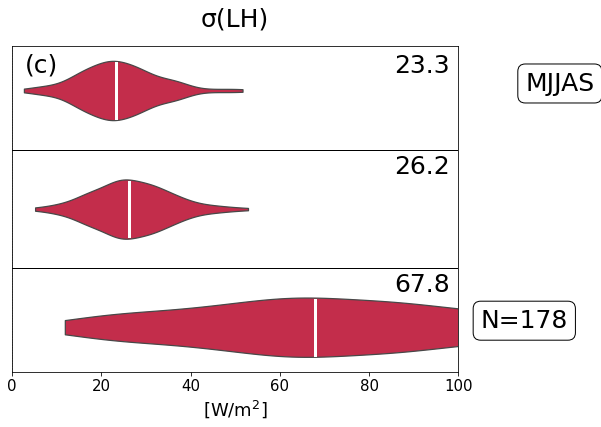

In [1387]:
category_sizes = R_violin.groupby('time').size()

max_size = category_sizes.max()
categoryidths = category_sizes / (2*max_size)

fig, ax = plt.subplots(figsize=(8, 6))
fig.set_facecolor('white')

for i, (category, data) in enumerate(std_violin.groupby('time')):
    sns.violinplot(
        data=data,
        x='std',
        y=np.full(len(data), category),
        color='crimson',
        inner=None,
        width=categoryidths[category],
        ax=ax,
        order=['Monthly','Daily','Hourly'],
        cut=0,
    )

plt.xticks(fontsize=15)
plt.xlim(0,100)
ax.yaxis.set_visible(False)
plt.xlabel(r'$\mathrm{[W/m^2]}$', fontsize=18)
plt.axvline(0,linestyle='--',c='gray',linewidth=.5)
plt.axhline(0.5,c='k',linewidth=1.)
plt.axhline(1.5,c='k',linewidth=1.)
plt.title('σ(LH)',fontsize=25,pad=20)

plt.text(98.,0-.15,f'{round(std_m_med, 1)}',fontsize=25, c='k', ha='right')
plt.text(98.,1-.30,f'{round(std_d_med, 1)}',fontsize=25, c='k', ha='right')
plt.text(98.,2-.30,f'{round(std_h_med, 1)}',fontsize=25, c='k', ha='right')

plt.text(105.,2,'N=178',fontsize=25, bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3'))
plt.text(115.,0,'MJJAS',fontsize=25, bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3'))

ax = plt.gca()  
ax.text(0.03, 0.92, '(c)', fontsize=25, transform=ax.transAxes)

ax.plot([std_m_med, std_m_med], [-0.23, 0.23], color='white', linewidth=3)
ax.plot([std_d_med, std_d_med], [1-0.23, 1+0.23], color='white', linewidth=3)
ax.plot([std_h_med, std_h_med], [2-0.23, 2+0.23], color='white', linewidth=3)

plt.savefig(fname+'figure 9 std violin warm mid white', dpi=600, bbox_inches = 'tight', pad_inches = 0.02)
plt.show()

# Figure S1

## data

In [1135]:
flux_195=sorted(glob.glob('/home/jnhan/python/power spectrum/data/FLUXNET/250406/hourly/*.csv'))

In [1136]:
lat_195=[]
lon_195=[]
IGBP_195=[]
for i in range(len(flux_195)):
    print(i,end='\r')
    flux=pd.read_csv(flux_195[i]).dropna()
    flux=flux.reset_index(drop=True)
    
    lat_195.append(flux.latitude[0])
    lon_195.append(flux.longitude[0])
    IGBP_195.append(flux.IGBP[0])

In [1138]:
IGBP_195_copy=IGBP_195.copy()

for i in range(len(IGBP_195_copy)):
    if IGBP_195_copy[i] in [1, 2, 3, 4, 5]:
        IGBP_195_copy[i] = 'Forest'
    elif IGBP_195_copy[i] in [6, 7]:
        IGBP_195_copy[i] = 'Shrubland'
    elif IGBP_195_copy[i] in [8, 9]:
        IGBP_195_copy[i] = 'Savanna'
    elif IGBP_195_copy[i] in [10]:
        IGBP_195_copy[i] = 'Grassland'
    elif IGBP_195_copy[i] in [11]:
        IGBP_195_copy[i] = 'Wetland'
    elif IGBP_195_copy[i] in [12, 14]:
        IGBP_195_copy[i] = 'Cropland'
    elif IGBP_195_copy[i] in [13]:
        IGBP_195_copy[i] = 'Urban'
    elif IGBP_195_copy[i] in [15]:
        IGBP_195_copy[i] = 'Snow'
    elif IGBP_195_copy[i] in [16]:
        IGBP_195_copy[i] = 'Barren'
    elif IGBP_195_copy[i] in [17]:
        IGBP_195_copy[i] = 'Water'

In [1139]:
def ismn_lc(lc_year):
    lc_type={}
    for index,item in enumerate(lc_year):
        if item not in lc_type:
            lc_type[item]=[index]
        else:
            lc_type[item].append(index)
    
    result=dict(sorted(lc_type.items()))
    
    return result

def lc_lat_lon(ISMN_lc_classify,lat,lon):
    lat_dict={}
    lon_dict={}
    
    for i in ISMN_lc_classify.keys():
        lat_dict[f'lat_{i}']=[]
        lon_dict[f'lon_{i}']=[]
        for j in ISMN_lc_classify[i]:
            lat_dict[ f'lat_{i}'].append(lat[j])    
            lon_dict[ f'lon_{i}'].append(lon[j])

    return lat_dict,lon_dict

In [1140]:
lc_dict_195=ismn_lc(IGBP_195_copy)

In [1141]:
lc_lat_195,lc_lon_195=lc_lat_lon(lc_dict_195,lat_195,lon_195)

## plot

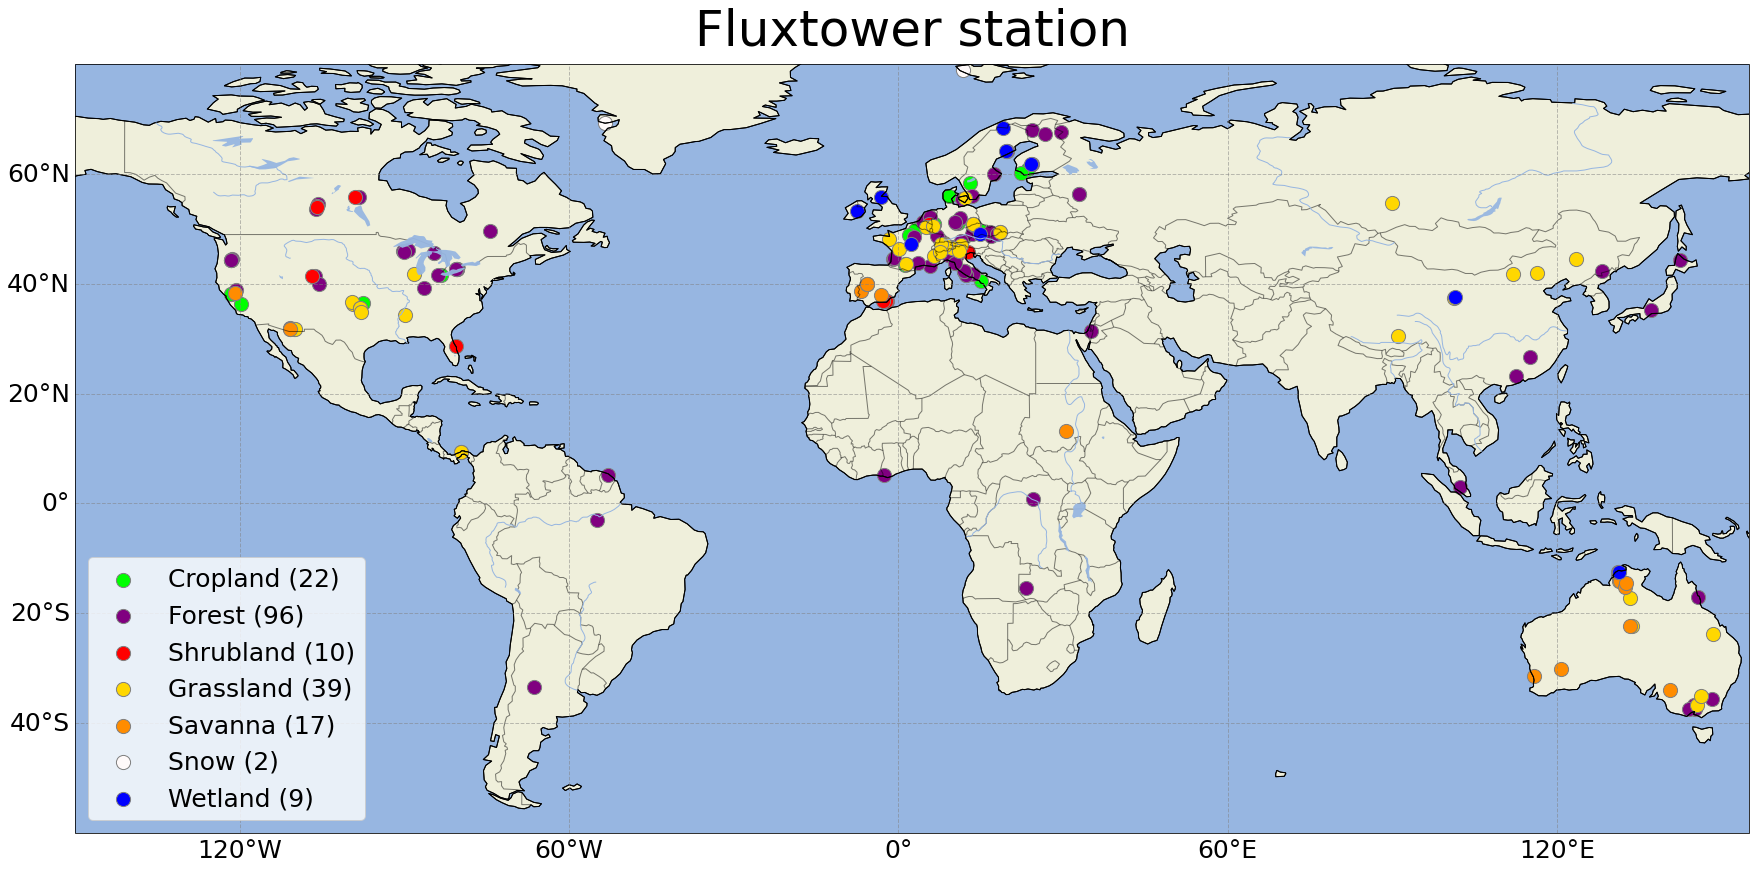

In [1381]:
fig ,ax= plt.subplots(figsize=(30, 30), subplot_kw={'projection': ccrs.PlateCarree()})
fig.set_facecolor('white')

plt.scatter(lc_lon_195['lon_Cropland'], lc_lat_195['lat_Cropland'], transform=cartopy.crs.PlateCarree(), s=200, color='lime',edgecolor='gray', label='Cropland ({})'.format(len(lc_lon_195["lon_Cropland"])))
plt.scatter(lc_lon_195['lon_Forest'], lc_lat_195['lat_Forest'], transform=cartopy.crs.PlateCarree(),s=200,color='purple',edgecolor='gray',label='Forest ({})'.format(len(lc_lon_195["lon_Forest"])))
plt.scatter(lc_lon_195['lon_Shrubland'], lc_lat_195['lat_Shrubland'], transform=cartopy.crs.PlateCarree(),s=200,color='red',edgecolor='gray',label='Shrubland ({})'.format(len(lc_lon_195["lon_Shrubland"])))
plt.scatter(lc_lon_195['lon_Grassland'], lc_lat_195['lat_Grassland'], transform=cartopy.crs.PlateCarree(),s=200,color='gold',edgecolor='gray',label='Grassland ({})'.format(len(lc_lon_195["lon_Grassland"])))
plt.scatter(lc_lon_195['lon_Savanna'], lc_lat_195['lat_Savanna'], transform=cartopy.crs.PlateCarree(),s=200,color='darkorange',edgecolor='gray',label='Savanna ({})'.format(len(lc_lon_195["lon_Savanna"])))
plt.scatter(lc_lon_195['lon_Snow'], lc_lat_195['lat_Snow'], transform=cartopy.crs.PlateCarree(),s=200,color='snow',edgecolor='gray',label='Snow ({})'.format(len(lc_lon_195["lon_Snow"])))
plt.scatter(lc_lon_195['lon_Wetland'], lc_lat_195['lat_Wetland'], transform=cartopy.crs.PlateCarree(),s=200,color='blue',edgecolor='gray',label='Wetland ({})'.format(len(lc_lon_195["lon_Wetland"])))

ax.coastlines()
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle='-', alpha=.5)
ax.add_feature(cfeature.LAKES, alpha=0.95)
ax.add_feature(cfeature.RIVERS)
ax.set_extent([-150, 160, -60, 80], crs=ccrs.PlateCarree())
ax.set_xlim(-150, 155)
ax.set_ylim(-60, 80)

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
gl.xlabel_style = {'size': 25}
gl.ylabel_style = {'size': 25}

plt.title('Fluxtower station',fontsize=50,pad=20)
plt.legend(loc='lower left',fontsize=25)
plt.savefig(fname+'figure S1 supplymentary fluxtower station', dpi=600, bbox_inches = 'tight', pad_inches = 0.02)

plt.show()

# Figure S2

## data

In [1093]:
ISMN_sm=sorted(glob.glob('/home/jnhan/python/power spectrum/data/final filter/sm/ISMN_filter/*.csv'))
ISMN_ts=sorted(glob.glob('/home/jnhan/python/power spectrum/data/final filter/ts/ISMN_filter/*.csv'))

ERA_data=sorted(glob.glob('/home/jnhan/python/power spectrum/data/ERA5/p_remove_250608/*.csv'))
MERRA_data=sorted(glob.glob('/home/jnhan/python/power spectrum/data/MERRA2/p_remove_250608/*.csv'))

TLO_sm=glob.glob('/home/jnhan/python/power spectrum/data/reference sensor/sm/TLO/*')
TDT_sm=glob.glob('/home/jnhan/python/power spectrum/data/reference sensor/sm/TDT/*')

TLO_st=[i.split('/')[-1][:-7] for i in TLO_sm]
TDT_st=[i.split('/')[-1][:-7] for i in TDT_sm]

In [1094]:
ISMN_sm=[item for item in ISMN_sm if not any(tlo in item for tlo in TLO_st)]
ISMN_sm=[item for item in ISMN_sm if not any(tlo in item for tlo in TDT_st)]

ISMN_ts=[item for item in ISMN_ts if not any(tlo in item for tlo in TLO_st)]
ISMN_ts=[item for item in ISMN_ts if not any(tlo in item for tlo in TDT_st)]

ERA_data=[item for item in ERA_data if not any(tlo in item for tlo in TDT_st)]
ERA_data=[item for item in ERA_data if not any(tlo in item for tlo in TLO_st)]

MERRA_data=[item for item in MERRA_data if not any(tlo in item for tlo in TDT_st)]
MERRA_data=[item for item in MERRA_data if not any(tlo in item for tlo in TLO_st)]

In [1095]:
ISMN_order=[i.split('/')[-1][:-7] for i in ISMN_sm]

ERA_data = sorted(ERA_data, key=lambda path: ISMN_order.index(next(a for a in ISMN_order if a in path)))
MERRA_data = sorted(MERRA_data, key=lambda path: ISMN_order.index(next(a for a in ISMN_order if a in path)))

In [1119]:
ERA_v,MERRA_v=(0.5, 0.5)
lat=[]
lon=[]
ISMN_cor_ano=[]
merge_list=[]
hourly_list=[]
bn_lat=[]
bn_lon=[]
bn_ISMN_cor_ano=[]
bn_merge_list=[]
bn_hourly_list=[]
before_noon=[]
error=[]
low_len=[]
idx=[]
bn_idx=[]
for i in range(len(ISMN_sm)):
    print(i,end='\r')
    try:
        ISMN=pd.read_csv(ISMN_sm[i],usecols={'date_time','soil_moisture','flag','anomaly','rm'},index_col='date_time',parse_dates=['date_time'])
        ERA=pd.read_csv(ERA_data[i],usecols={'date_time','sm','sm ano','ts','ts ano'},index_col='date_time',parse_dates=['date_time'])
        MERRA=pd.read_csv(MERRA_data[i],usecols={'date_time','sm','sm ano','ts','ts ano'},index_col='date_time',parse_dates=['date_time'])
        ts_ISMN=pd.read_csv(ISMN_ts[i],usecols={'date_time','soil_temperature','flag','anomaly'},index_col='date_time',parse_dates=['date_time'])
        ISMN2=pd.read_csv(ISMN_sm[i])
        
        ISMN=ISMN[ISMN['flag']=='G']
        ts_ISMN=ts_ISMN[ts_ISMN['flag']=='G']
        ISMN=ISMN[['soil_moisture','anomaly','rm']]
        ts_ISMN=ts_ISMN[['soil_temperature','anomaly']]
        
        ISMN.rename(columns={'soil_moisture':'ISMN sm','anomaly':'ISMN sm ano','rm':'ISMN rm'},inplace=True)
        ERA.rename(columns={'sm':'ERA sm','sm ano':'ERA sm ano','ts':'ERA ts','ts ano':'ERA ts ano'},inplace=True)
        MERRA.rename(columns={'sm':'MERRA sm','sm ano':'MERRA sm ano','ts':'MERRA ts','ts ano':'MERRA ts ano'},inplace=True)
        ts_ISMN.rename(columns={'soil_temperature':'ISMN ts','anomaly':'ISMN ts ano'},inplace=True)
        
        merged = ISMN.merge(ERA, left_index=True, right_index=True, how='inner')
        merged = merged.merge(MERRA, left_index=True, right_index=True, how='inner')
        merged = merged.merge(ts_ISMN, left_index=True, right_index=True, how='inner')
        merged = merged.dropna()

        if len(merged) > 2200:
            'ㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡ'
            'anomaly'
            fft_ISMN_ano=np.fft.fft(merged['ISMN sm ano'])
            ps_ISMN_ano=np.abs(fft_ISMN_ano)
            freq_ISMN_ano=np.fft.fftfreq(len(merged),d=1.0/len(fft_ISMN_ano))
            
            fft_ERA_ano=np.fft.fft(merged['ERA sm ano'])
            ps_ERA_ano=np.abs(fft_ERA_ano)
            freq_ERA_ano=np.fft.fftfreq(len(merged),d=1.0/len(fft_ERA_ano))
            
            fft_MERRA_ano=np.fft.fft(merged['MERRA sm ano'])
            ps_MERRA_ano=np.abs(fft_MERRA_ano)
            freq_MERRA_ano=np.fft.fftfreq(len(merged),d=1.0/len(fft_MERRA_ano))
            
            freq_24=int(len(freq_ISMN_ano)/24)
            freq_36=int(len(freq_ISMN_ano)/36)
            freq_12=int(len(freq_ISMN_ano)/12)
            
            df_ano=pd.DataFrame()
            df_ano['fft_ISMN_r']=fft_ISMN_ano.real
            df_ano['fft_ERA_r']=fft_ERA_ano.real
            df_ano['fft_MERRA_r']=fft_MERRA_ano.real
            df_ano['fft_m_r']=((ERA_v*df_ano['fft_ERA_r'])+(MERRA_v*df_ano['fft_MERRA_r']))
            df_ano['fft_ISMN_i']=fft_ISMN_ano.imag
            df_ano['fft_ERA_i']=fft_ERA_ano.imag
            df_ano['fft_MERRA_i']=fft_MERRA_ano.imag
            df_ano['fft_m_i']=((ERA_v*df_ano['fft_ERA_i'])+(MERRA_v*df_ano['fft_MERRA_i']))
            df_ano['ps_ISMN']=ps_ISMN_ano
            df_ano['ps_ERA']=ps_ERA_ano
            df_ano['ps_MERRA']=ps_MERRA_ano
            df_ano['ps_m']=((ERA_v*df_ano['ps_ERA'])+(MERRA_v*df_ano['ps_MERRA']))
            
            mv_ano=df_ano.rolling(window=24,center=True).mean()
            
            sf_ano_E=mv_ano['ps_ISMN']/mv_ano['ps_ERA']
            sf_ano_M=mv_ano['ps_ISMN']/mv_ano['ps_MERRA']
            sf_ano_all=mv_ano['ps_ISMN']/mv_ano['ps_m']
            
            fft_ano_r_E=sf_ano_E*df_ano['fft_ERA_r']
            fft_ano_i_E=sf_ano_E*df_ano['fft_ERA_i']
            fft_ano_r_M=sf_ano_M*df_ano['fft_MERRA_r']
            fft_ano_i_M=sf_ano_M*df_ano['fft_MERRA_i']
            fft_ano_r_all=sf_ano_all*df_ano['fft_m_r']
            fft_ano_i_all=sf_ano_all*df_ano['fft_m_i']
            
            fft_ano_resc_E=fft_ano_r_E+fft_ano_i_E*1j
            fft_ano_resc_M=fft_ano_r_M+fft_ano_i_M*1j
            fft_ano_resc_all=fft_ano_r_all+fft_ano_i_all*1j
            
            fft_ISMN_adj_ano_E=fft_ISMN_ano.copy()
            fft_ISMN_adj_ano_M=fft_ISMN_ano.copy()
            fft_ISMN_adj_ano_all=fft_ISMN_ano.copy()
            
            fft_ISMN_adj_ano_E[freq_36:freq_12]=fft_ano_resc_E[freq_36:freq_12]
            fft_ISMN_adj_ano_E[-freq_12:-freq_36]=fft_ano_resc_E[-freq_12:-freq_36]
            fft_ISMN_adj_ano_M[freq_36:freq_12]=fft_ano_resc_M[freq_36:freq_12]
            fft_ISMN_adj_ano_M[-freq_12:-freq_36]=fft_ano_resc_M[-freq_12:-freq_36]
            fft_ISMN_adj_ano_all[freq_36:freq_12]=fft_ano_resc_all[freq_36:freq_12]
            fft_ISMN_adj_ano_all[-freq_12:-freq_36]=fft_ano_resc_all[-freq_12:-freq_36]
            
            ps_ano_adj_E=np.abs(fft_ISMN_adj_ano_E)
            ps_ano_adj_M=np.abs(fft_ISMN_adj_ano_M)
            ps_ano_adj_all=np.abs(fft_ISMN_adj_ano_all)
            
            ifft_ISMN_ano_E=np.fft.ifft(fft_ISMN_adj_ano_E)
            ifft_ISMN_ano_real_E=ifft_ISMN_ano_E.real
            ifft_ISMN_ano_M=np.fft.ifft(fft_ISMN_adj_ano_M)
            ifft_ISMN_ano_real_M=ifft_ISMN_ano_M.real
            ifft_ISMN_ano_all=np.fft.ifft(fft_ISMN_adj_ano_all)
            ifft_ISMN_ano_real_all=ifft_ISMN_ano_all.real
            
            merged['ano_adj_E']=ifft_ISMN_ano_real_E
            merged['ano_adj_M']=ifft_ISMN_ano_real_M
            merged['ano_adj_all']=ifft_ISMN_ano_real_all
            
            hourly=merged.groupby(merged.index.hour).mean()

            if (np.argmax(hourly['ISMN sm ano']) >= 12):
                lat.append(ISMN2.latitude[0])
                lon.append(ISMN2.longitude[0])
                ISMN_cor_ano.append(np.corrcoef(hourly['ISMN sm ano'],hourly['ISMN ts ano'])[0,1])       # ISMN ano R(sm,ts)
                merge_list.append(merged_copy)
                hourly_list.append(hourly)
                idx.append(i)
            else : 
                bn_lat.append(ISMN2.latitude[0])
                bn_lon.append(ISMN2.longitude[0])
                bn_ISMN_cor_ano.append(np.corrcoef(hourly['ISMN sm ano'],hourly['ISMN ts ano'])[0,1])       # ISMN ano R(sm,ts)
                bn_merge_list.append(merged_copy)
                bn_hourly_list.append(hourly)
                bn_idx.append(i)
            del night,hourly
        else:
            low_len.append(i)
    except Exception as e:
        error.append((i,e))

In [1120]:
lat_all=lat+bn_lat
lon_all=lon+bn_lon
R_ISMN_all=ISMN_cor_ano+bn_ISMN_cor_ano
merged_all=merge_list+bn_merge_list
hourly_all=hourly_list+bn_hourly_list

In [1137]:
sm_mean=[]
for i in range(len(hourly_all)):
    print(i,end='\r')
    sm_mean.append(np.mean(hourly_all[i]['ISMN sm']))

In [1174]:
sm_mean1_idx,sm_mean1=zip(*[(i,j) for i,j in enumerate(sm_mean) if j<0.13])
sm_mean2_idx,sm_mean2=zip(*[(i,j) for i,j in enumerate(sm_mean) if 0.13<=j<0.23])
sm_mean3_idx,sm_mean3=zip(*[(i,j) for i,j in enumerate(sm_mean) if 0.23<=j])

len_sm1=len(sm_mean1)
len_sm2=len(sm_mean2)
len_sm3=len(sm_mean3)

In [1176]:
sm1_lat=np.array([lat_all[i] for i in sm_mean1_idx])
sm2_lat=np.array([lat_all[i] for i in sm_mean2_idx])
sm3_lat=np.array([lat_all[i] for i in sm_mean3_idx])

sm1_lon=np.array([lon_all[i] for i in sm_mean1_idx])
sm2_lon=np.array([lon_all[i] for i in sm_mean2_idx])
sm3_lon=np.array([lon_all[i] for i in sm_mean3_idx])

sm1_ISMN=np.array([R_ISMN_all[i] for i in sm_mean1_idx])
sm2_ISMN=np.array([R_ISMN_all[i] for i in sm_mean2_idx])
sm3_ISMN=np.array([R_ISMN_all[i] for i in sm_mean3_idx])

## plot

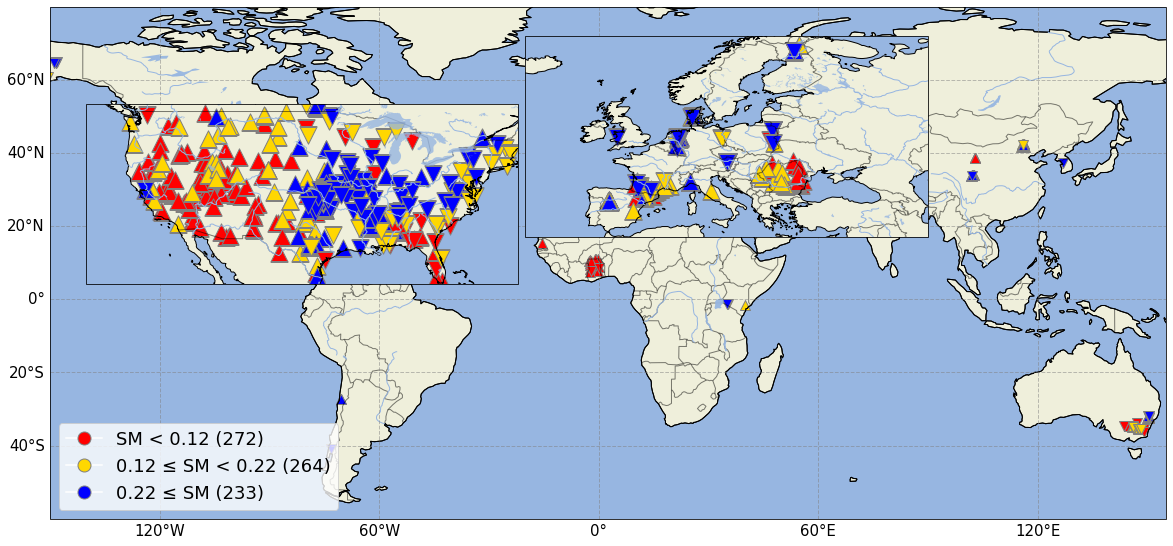

In [1376]:
fig ,ax= plt.subplots(figsize=(20, 20), subplot_kw={'projection': ccrs.PlateCarree()})
fig.set_facecolor('white')

R_p1 = np.array([value > 0 for value in sm1_ISMN])
R_n1 = np.array([value < 0 for value in sm1_ISMN])
R_p2 = np.array([value > 0 for value in sm2_ISMN])
R_n2 = np.array([value < 0 for value in sm2_ISMN])
R_p3 = np.array([value > 0 for value in sm3_ISMN])
R_n3 = np.array([value < 0 for value in sm3_ISMN])

plt.scatter(sm1_lon[R_p1], sm1_lat[R_p1],transform=cartopy.crs.PlateCarree(), s=100, color='red',edgecolor='gray', marker='^',)
plt.scatter(sm2_lon[R_p2], sm2_lat[R_p2],transform=cartopy.crs.PlateCarree(),s=100,color='gold',edgecolor='gray', marker='^')
plt.scatter(sm3_lon[R_p3], sm3_lat[R_p3],transform=cartopy.crs.PlateCarree(),s=100,color='blue',edgecolor='gray', marker='^')

plt.scatter(sm1_lon[R_n1], sm1_lat[R_n1],transform=cartopy.crs.PlateCarree(), s=100, color='red',edgecolor='gray', marker='v')
plt.scatter(sm2_lon[R_n2], sm2_lat[R_n2],transform=cartopy.crs.PlateCarree(),s=100,color='gold',edgecolor='gray', marker='v')
plt.scatter(sm3_lon[R_n3], sm3_lat[R_n3],transform=cartopy.crs.PlateCarree(),s=100,color='blue',edgecolor='gray', marker='v')

ax.coastlines()
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle='-', alpha=.5)
ax.add_feature(cfeature.LAKES, alpha=0.95)
ax.add_feature(cfeature.RIVERS)
ax.set_extent([-150, 160, -60, 80], crs=ccrs.PlateCarree())
ax.set_xlim(-150, 155)
ax.set_ylim(-60, 80)

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
gl.xlabel_style = {'size': 15}
gl.ylabel_style = {'size': 15}

custom_legend = [
    Line2D([0], [0], marker='o', color='w', label=fr'SM < 0.12 ({len_sm1})',
           markerfacecolor='red', markersize=13, markeredgecolor='gray'),
    Line2D([0], [0], marker='o', color='w', label=fr'0.12 ≤ SM < 0.22 ({len_sm2})',
           markerfacecolor='gold', markersize=13, markeredgecolor='gray'),
    Line2D([0], [0], marker='o', color='w', label=fr'0.22 ≤ SM ({len_sm3})',
           markerfacecolor='blue', markersize=13, markeredgecolor='gray')]
plt.legend(handles=custom_legend, loc='lower left', fontsize=18)

'ㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡ'
'CONUS'
ax_inset = fig.add_axes([0.15, 0.40, 0.3, 0.3], projection=ccrs.PlateCarree())
ax_inset.set_extent([-130, -70, 25, 50], crs=ccrs.PlateCarree())  # CONUS 지역

ax_inset.coastlines()
ax_inset.add_feature(cfeature.LAND)
ax_inset.add_feature(cfeature.OCEAN)
ax_inset.add_feature(cfeature.BORDERS, linestyle='-', alpha=0.5)
ax_inset.add_feature(cfeature.LAKES, alpha=0.8)
ax_inset.add_feature(cfeature.RIVERS)

ax_inset.scatter(sm1_lon[R_p1], sm1_lat[R_p1],transform=cartopy.crs.PlateCarree(), s=300, color='red',edgecolor='gray', marker='^',)
ax_inset.scatter(sm2_lon[R_p2], sm2_lat[R_p2],transform=cartopy.crs.PlateCarree(),s=300,color='gold',edgecolor='gray', marker='^')
ax_inset.scatter(sm3_lon[R_p3], sm3_lat[R_p3],transform=cartopy.crs.PlateCarree(),s=300,color='blue',edgecolor='gray', marker='^')

ax_inset.scatter(sm1_lon[R_n1], sm1_lat[R_n1],transform=cartopy.crs.PlateCarree(), s=300, color='red',edgecolor='gray', marker='v')
ax_inset.scatter(sm2_lon[R_n2], sm2_lat[R_n2],transform=cartopy.crs.PlateCarree(),s=300,color='gold',edgecolor='gray', marker='v')
ax_inset.scatter(sm3_lon[R_n3], sm3_lat[R_n3],transform=cartopy.crs.PlateCarree(),s=300,color='blue',edgecolor='gray', marker='v')

'ㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡ'
'EU'
ax_inset2 = fig.add_axes([0.455, 0.5, 0.28, 0.18], projection=ccrs.PlateCarree())
ax_inset2.set_extent([-20, 50, 35, 70], crs=ccrs.PlateCarree())  # 유럽 지역 범위 설정

ax_inset2.coastlines()
ax_inset2.add_feature(cfeature.LAND)
ax_inset2.add_feature(cfeature.OCEAN)
ax_inset2.add_feature(cfeature.BORDERS, linestyle='-', alpha=0.5)
ax_inset2.add_feature(cfeature.LAKES, alpha=0.8)
ax_inset2.add_feature(cfeature.RIVERS)

ax_inset2.scatter(sm1_lon[R_p1], sm1_lat[R_p1],transform=cartopy.crs.PlateCarree(), s=300, color='red',edgecolor='gray', marker='^',)
ax_inset2.scatter(sm2_lon[R_p2], sm2_lat[R_p2],transform=cartopy.crs.PlateCarree(),s=300,color='gold',edgecolor='gray', marker='^')
ax_inset2.scatter(sm3_lon[R_p3], sm3_lat[R_p3],transform=cartopy.crs.PlateCarree(),s=300,color='blue',edgecolor='gray', marker='^')

ax_inset2.scatter(sm1_lon[R_n1], sm1_lat[R_n1],transform=cartopy.crs.PlateCarree(), s=300, color='red',edgecolor='gray', marker='v')
ax_inset2.scatter(sm2_lon[R_n2], sm2_lat[R_n2],transform=cartopy.crs.PlateCarree(),s=300,color='gold',edgecolor='gray', marker='v')
ax_inset2.scatter(sm3_lon[R_n3], sm3_lat[R_n3],transform=cartopy.crs.PlateCarree(),s=300,color='blue',edgecolor='gray', marker='v')

'ㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡ'
plt.savefig(fname+'figure S2 R by sm map class3', dpi=600, bbox_inches = 'tight', pad_inches = 0.02)

plt.show()

# Figure S3

## data

In [1178]:
ISMN_sm=sorted(glob.glob('/home/jnhan/python/power spectrum/data/final filter/sm/ISMN_filter/*.csv'))

In [1180]:
climate=[]
lat=[]
lon=[]
for i in range(len(ISMN_sm)):
    print(i,end='\r')
    a=pd.read_csv(ISMN_sm[i])
    climate.append(a.climate[0])
    lat.append(a.latitude[0])
    lon.append(a.longitude[0])
    del a

In [1181]:
climate_classify = [
    'Tropical' if key.startswith('A') else
    'Dry' if key.startswith('B') else
    'Temperate' if key.startswith('C') else
    'Continental' if key.startswith('D')  else
    'Polar' if key.startswith('E') else
    'Unknown'
    for key in climate
]

In [1183]:
climate_dict_ISMN=ismn_lc(climate_classify)

In [1184]:
climate_lat_ISMN,climate_lon_ISMN=lc_lat_lon(climate_dict_ISMN,lat,lon)

## plot

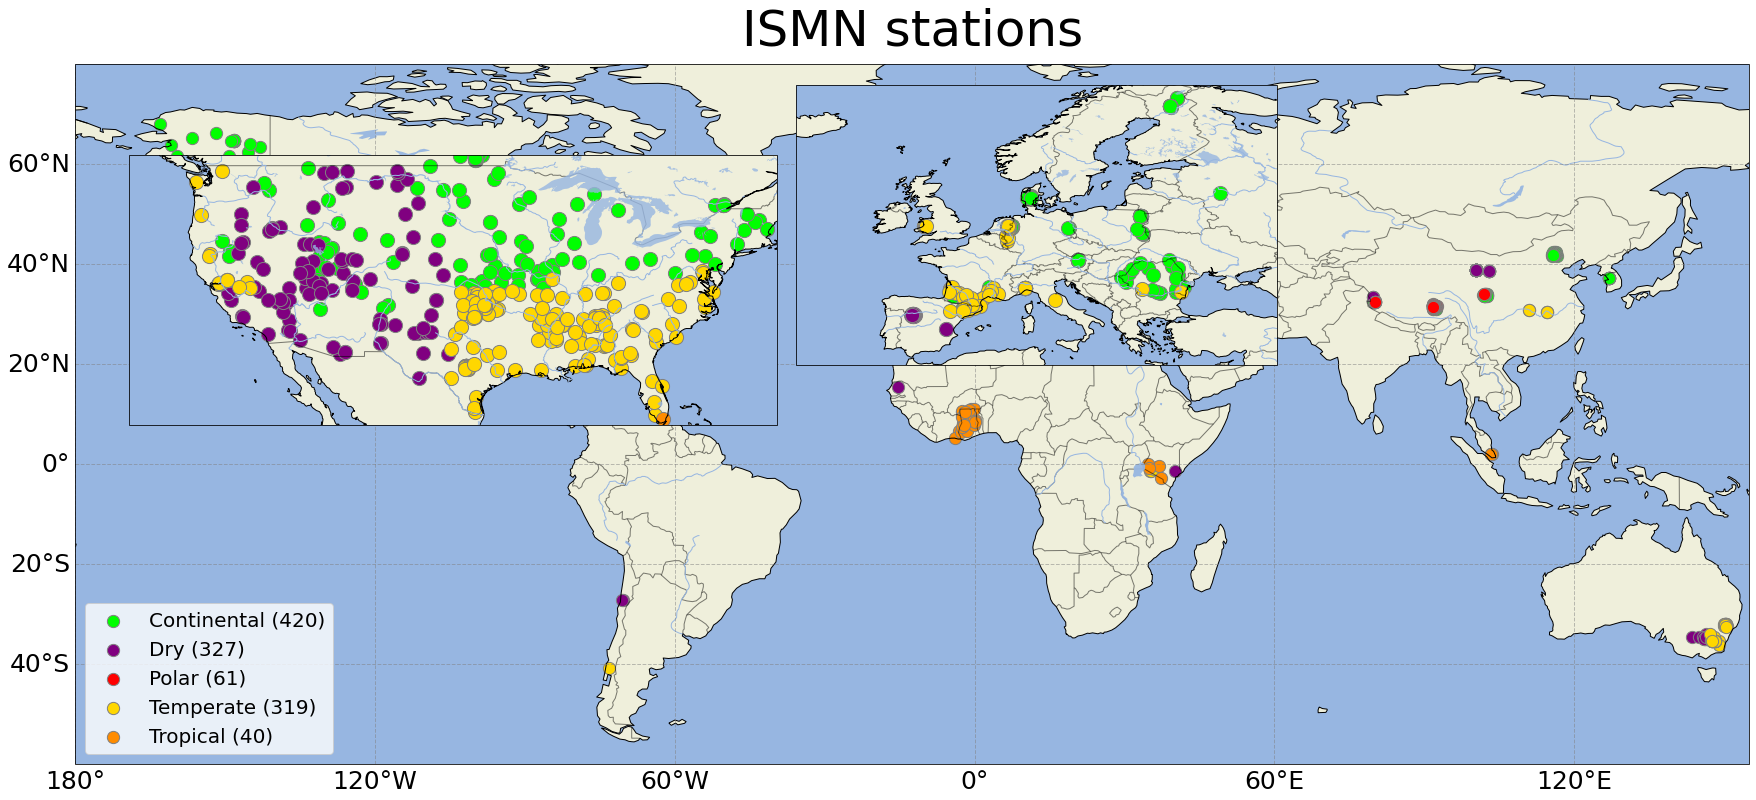

In [1382]:
fig = plt.figure(figsize=(30, 30))
fig.set_facecolor('white')

ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
ax.set_extent([-180, 155, -60, 80], crs=ccrs.PlateCarree())
ax.coastlines()
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.BORDERS, linestyle='-', alpha=.5)
ax.add_feature(cfeature.LAKES, alpha=0.95)
ax.add_feature(cfeature.RIVERS)

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 25}
gl.ylabel_style = {'size': 25}

ax.scatter(climate_lon_ISMN['lon_Continental'], climate_lat_ISMN['lat_Continental'], transform=cartopy.crs.PlateCarree(), s=150, color='lime',edgecolor='gray', label='Continental ({})'.format(len(climate_lon_ISMN["lon_Continental"])))
ax.scatter(climate_lon_ISMN['lon_Dry'], climate_lat_ISMN['lat_Dry'], transform=cartopy.crs.PlateCarree(),s=150,color='purple',edgecolor='gray',label='Dry ({})'.format(len(climate_lon_ISMN["lon_Dry"])))
ax.scatter(climate_lon_ISMN['lon_Polar'], climate_lat_ISMN['lat_Polar'], transform=cartopy.crs.PlateCarree(),s=150,color='red',edgecolor='gray',label='Polar ({})'.format(len(climate_lon_ISMN["lon_Polar"])))
ax.scatter(climate_lon_ISMN['lon_Temperate'], climate_lat_ISMN['lat_Temperate'], transform=cartopy.crs.PlateCarree(),s=150,color='gold',edgecolor='gray',label='Temperate ({})'.format(len(climate_lon_ISMN["lon_Temperate"])))
ax.scatter(climate_lon_ISMN['lon_Tropical'], climate_lat_ISMN['lat_Tropical'], transform=cartopy.crs.PlateCarree(),s=150,color='darkorange',edgecolor='gray',label='Tropical ({})'.format(len(climate_lon_ISMN["lon_Tropical"])))

ax.set_title('ISMN stations',fontsize=50,pad=20)
ax.legend(loc='lower left',fontsize=20)

# CONUS
ax_inset = fig.add_axes([0.15, 0.41, 0.3, 0.3], projection=ccrs.PlateCarree())
ax_inset.set_extent([-130, -70, 25, 50], crs=ccrs.PlateCarree())
ax_inset.coastlines()
ax_inset.add_feature(cfeature.LAND)
ax_inset.add_feature(cfeature.OCEAN)
ax_inset.add_feature(cfeature.BORDERS, linestyle='-', alpha=0.5)
ax_inset.add_feature(cfeature.LAKES, alpha=0.8)
ax_inset.add_feature(cfeature.RIVERS)

ax_inset.scatter(climate_lon_ISMN['lon_Continental'], climate_lat_ISMN['lat_Continental'], transform=cartopy.crs.PlateCarree(), s=200, color='lime',edgecolor='gray', label='Continental ({})'.format(len(climate_lon_ISMN["lon_Continental"])))
ax_inset.scatter(climate_lon_ISMN['lon_Dry'], climate_lat_ISMN['lat_Dry'], transform=cartopy.crs.PlateCarree(),s=200,color='purple',edgecolor='gray',label='Dry ({})'.format(len(climate_lon_ISMN["lon_Dry"])))
ax_inset.scatter(climate_lon_ISMN['lon_Polar'], climate_lat_ISMN['lat_Polar'], transform=cartopy.crs.PlateCarree(),s=200,color='red',edgecolor='gray',label='Polar ({})'.format(len(climate_lon_ISMN["lon_Polar"])))
ax_inset.scatter(climate_lon_ISMN['lon_Temperate'], climate_lat_ISMN['lat_Temperate'], transform=cartopy.crs.PlateCarree(),s=200,color='gold',edgecolor='gray',label='Temperate ({})'.format(len(climate_lon_ISMN["lon_Temperate"])))
ax_inset.scatter(climate_lon_ISMN['lon_Tropical'], climate_lat_ISMN['lat_Tropical'], transform=cartopy.crs.PlateCarree(),s=200,color='darkorange',edgecolor='gray',label='Tropical ({})'.format(len(climate_lon_ISMN["lon_Tropical"])))

# EU
ax_inset2 = fig.add_axes([0.455, 0.525, 0.23, 0.13], projection=ccrs.PlateCarree())
ax_inset2.set_extent([-20, 40, 35, 70], crs=ccrs.PlateCarree()) 
ax_inset2.coastlines()
ax_inset2.add_feature(cfeature.LAND)
ax_inset2.add_feature(cfeature.OCEAN)
ax_inset2.add_feature(cfeature.BORDERS, linestyle='-', alpha=0.5)
ax_inset2.add_feature(cfeature.LAKES, alpha=0.8)
ax_inset2.add_feature(cfeature.RIVERS)

ax_inset2.scatter(climate_lon_ISMN['lon_Continental'], climate_lat_ISMN['lat_Continental'], transform=cartopy.crs.PlateCarree(), s=200, color='lime',edgecolor='gray', label='Continental ({})'.format(len(climate_lon_ISMN["lon_Continental"])))
ax_inset2.scatter(climate_lon_ISMN['lon_Dry'], climate_lat_ISMN['lat_Dry'], transform=cartopy.crs.PlateCarree(),s=200,color='purple',edgecolor='gray',label='Dry ({})'.format(len(climate_lon_ISMN["lon_Dry"])))
ax_inset2.scatter(climate_lon_ISMN['lon_Polar'], climate_lat_ISMN['lat_Polar'], transform=cartopy.crs.PlateCarree(),s=200,color='red',edgecolor='gray',label='Polar ({})'.format(len(climate_lon_ISMN["lon_Polar"])))
ax_inset2.scatter(climate_lon_ISMN['lon_Temperate'], climate_lat_ISMN['lat_Temperate'], transform=cartopy.crs.PlateCarree(),s=200,color='gold',edgecolor='gray',label='Temperate ({})'.format(len(climate_lon_ISMN["lon_Temperate"])))
ax_inset2.scatter(climate_lon_ISMN['lon_Tropical'], climate_lat_ISMN['lat_Tropical'], transform=cartopy.crs.PlateCarree(),s=200,color='darkorange',edgecolor='gray',label='Tropical ({})'.format(len(climate_lon_ISMN["lon_Tropical"])))

plt.savefig(fname+'figure S3 ISMN station cli4', dpi=600, bbox_inches = 'tight', pad_inches = 0.02)

plt.show()

캡션에서 unknown type은 뺏다고 해야할듯